# Matlab testbench model state-space matrices

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import scipy.linalg as LA
from scipy.signal import lsim, dlsim
import opentorsion as ot
import cvxpy as cp

In [2]:
plt.style.use(['science', 'ieee'])
plt.rcParams["figure.figsize"] = (6,4)

In [3]:
def c2d(A, B, Ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time T_s.
    The function returns matrices A,B of the discrete-time system.
    """
    m, n = A.shape
    nb = B.shape[1]

    s = np.concatenate([A,B], axis=1)
    s = np.concatenate([s, np.zeros((nb, n+nb))], axis=0)
    S = LA.expm(s*Ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]
    
    return Ad, Bd

In [4]:
time_steps = np.genfromtxt('../data/ice_excitation/times.csv', delimiter=',')
motor = np.genfromtxt('../data/ice_excitation/motor.csv', delimiter=',')
propeller = np.genfromtxt('../data/ice_excitation/propeller.csv', delimiter=',')
angular_speeds = np.genfromtxt('../data/ice_excitation/speed_measurements.csv', delimiter=',')
shaft_torque = np.genfromtxt('../data/ice_excitation/torque_measurements.csv', delimiter=',')

In [5]:
A_mat = np.genfromtxt('../data/testbench_A.csv', delimiter=',')
B_mat = np.genfromtxt('../data/testbench_B.csv', delimiter=',')
C_mat = np.genfromtxt('../data/testbench_C.csv', delimiter=',')
D_mat = np.genfromtxt('../data/testbench_D.csv', delimiter=',')

ts = np.mean(np.diff(time_steps))
A_mat_d, B_mat_d = c2d(A_mat, B_mat, ts)
UU = np.vstack((motor, propeller)).T

In [6]:
# calculate an initial state for the discrete-time simulation
CCc = np.eye(B_mat.shape[0])
DDc = np.zeros((CCc.shape[0], B_mat.shape[1]))
_, initial_states_c, _ = lsim((A_mat, B_mat, CCc, DDc), UU, time_steps)

In [7]:
# continuous-time simulation
tout_mat, yout_mat, xout_mat = lsim((A_mat, B_mat, C_mat, D_mat), UU, time_steps, X0=initial_states_c[-1,:])

In [8]:
# calculate an initial state for the discrete-time simulation
CC = np.eye(B_mat_d.shape[0])
DD = np.zeros((CC.shape[0], B_mat_d.shape[1]))
_, initial_states, _ = dlsim((A_mat_d, B_mat_d, CC, DD, ts), UU, t=time_steps)

In [9]:
dtout_mat, dyout_mat, dxout_mat = dlsim((A_mat_d, B_mat_d, C_mat, D_mat, ts), UU, t=time_steps, x0=initial_states[-1,:])

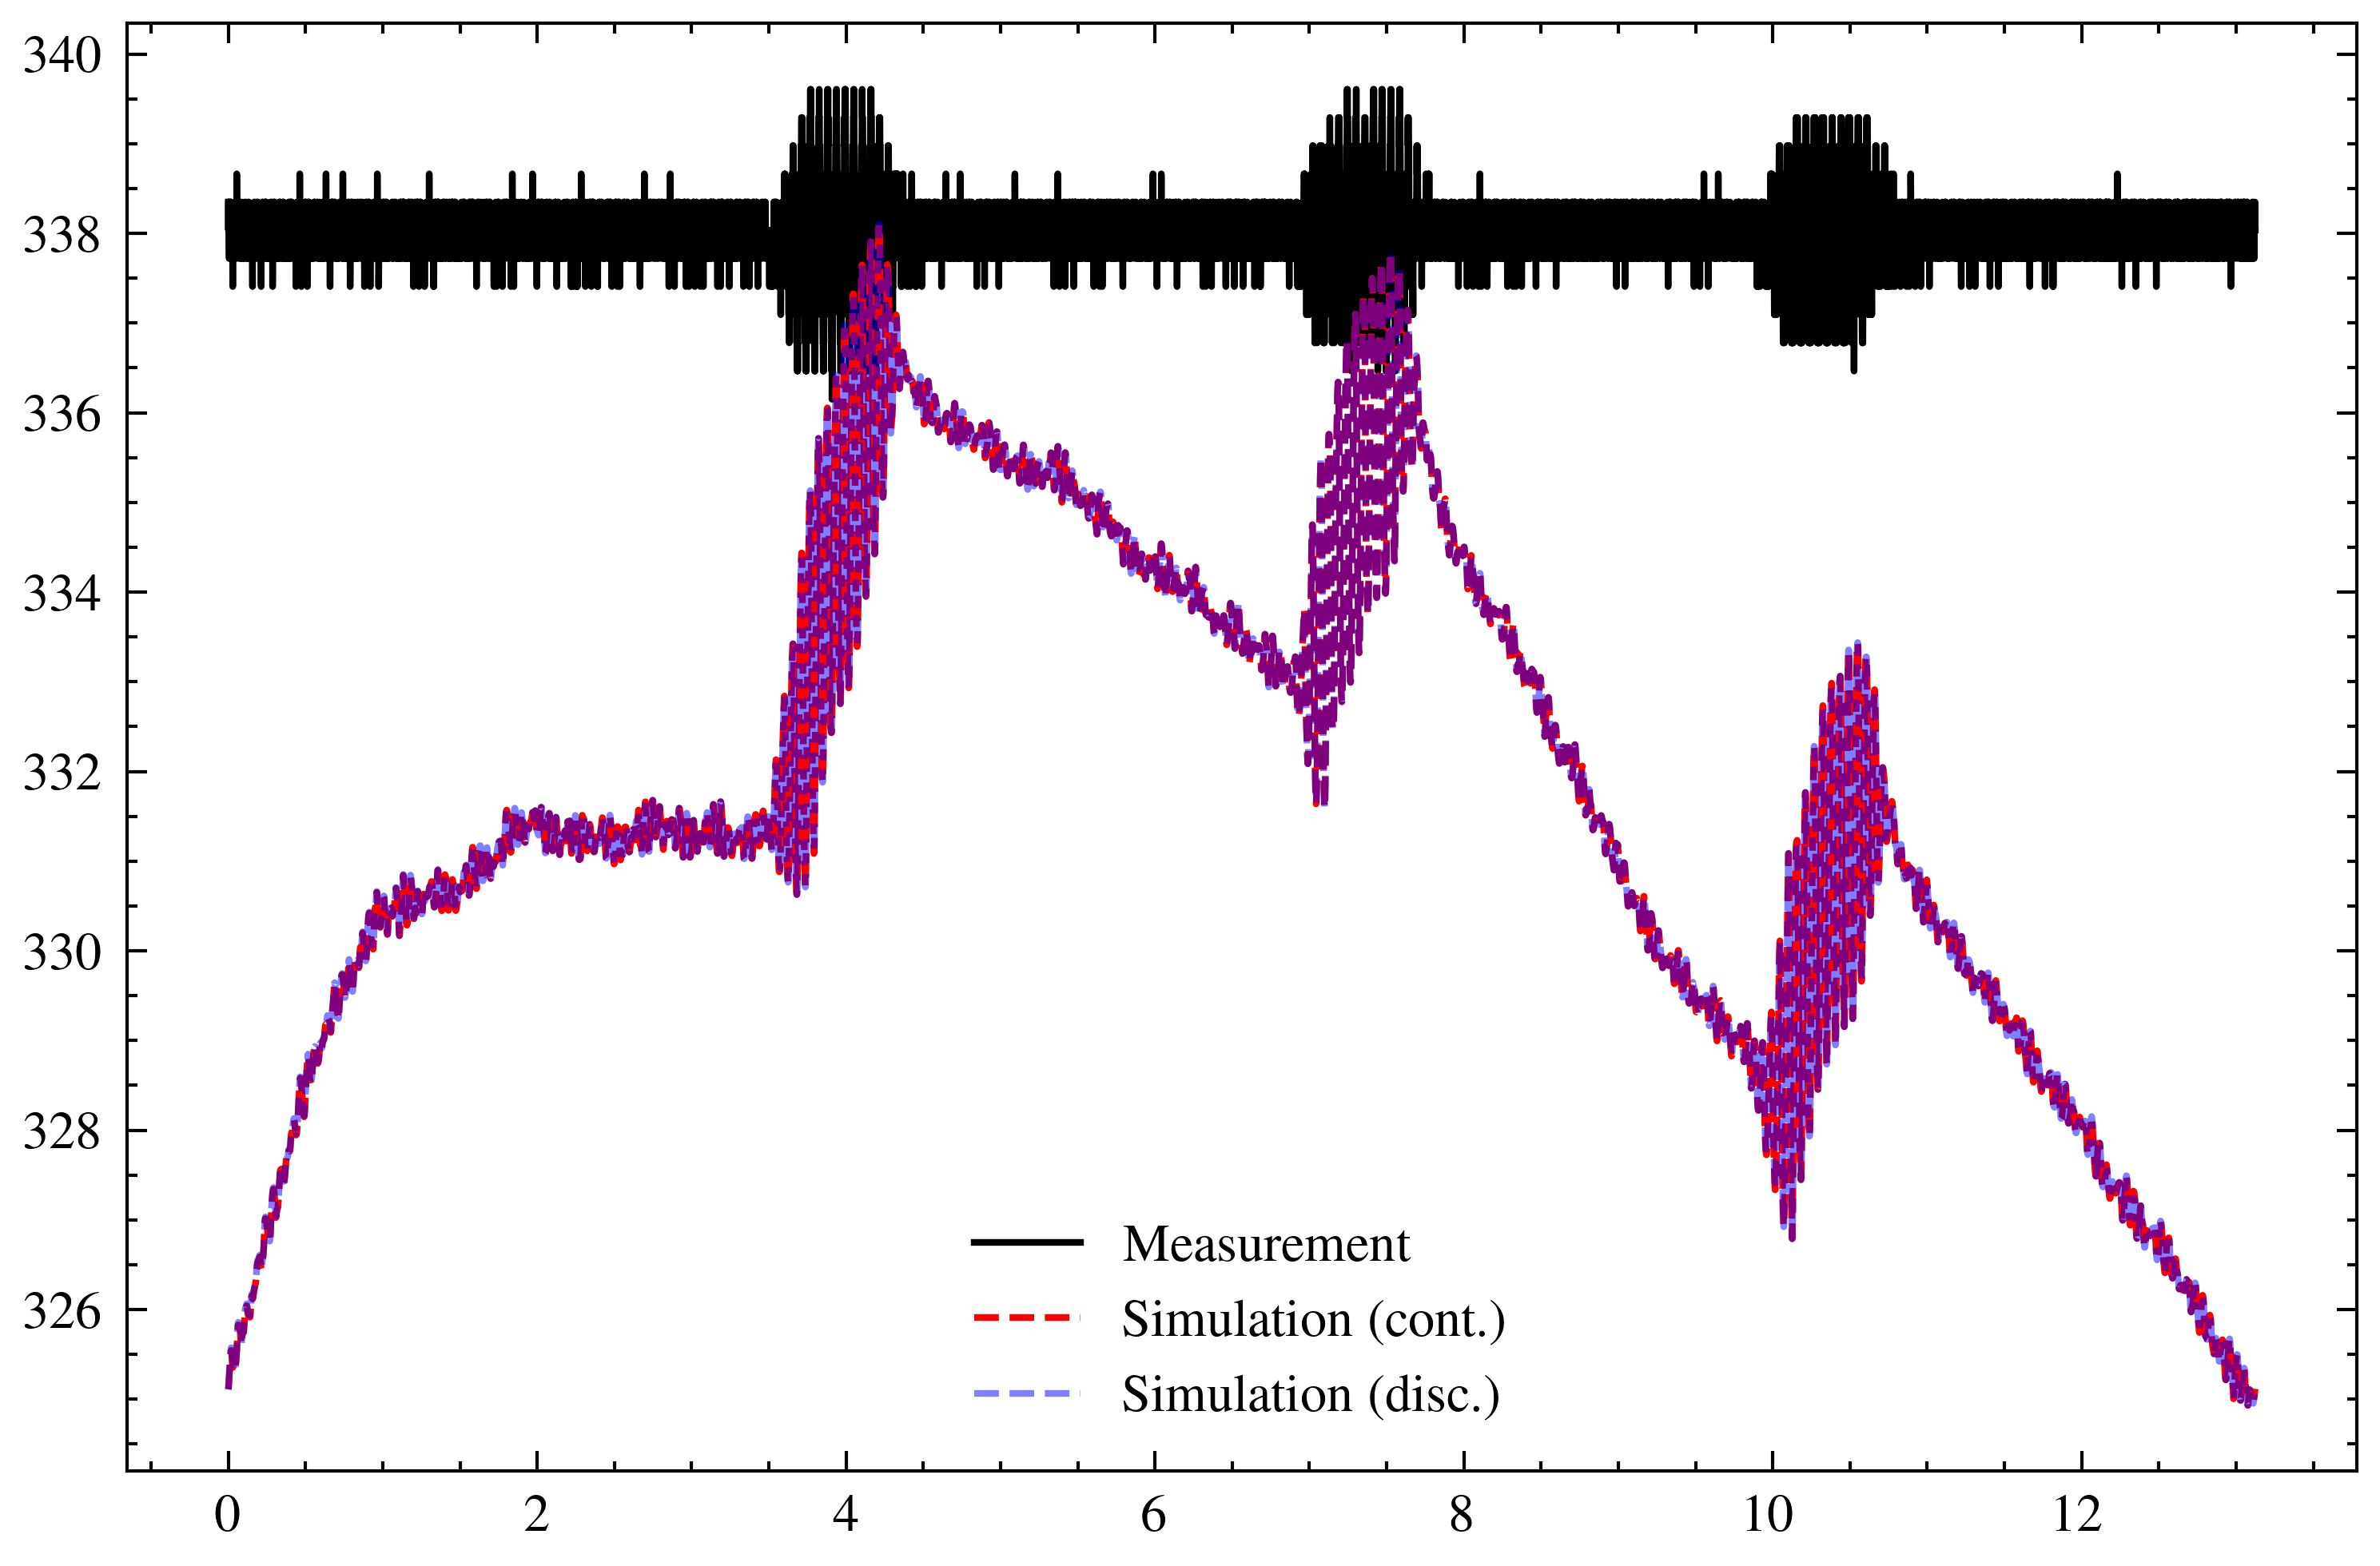

In [10]:
plt.plot(time_steps, angular_speeds[0,:], label='Measurement')
plt.plot(tout_mat, yout_mat[:,0], '--', label='Simulation (cont.)')
plt.plot(dtout_mat, dyout_mat[:,0], '--', label='Simulation (disc.)', alpha=0.5)
plt.legend()
plt.show()

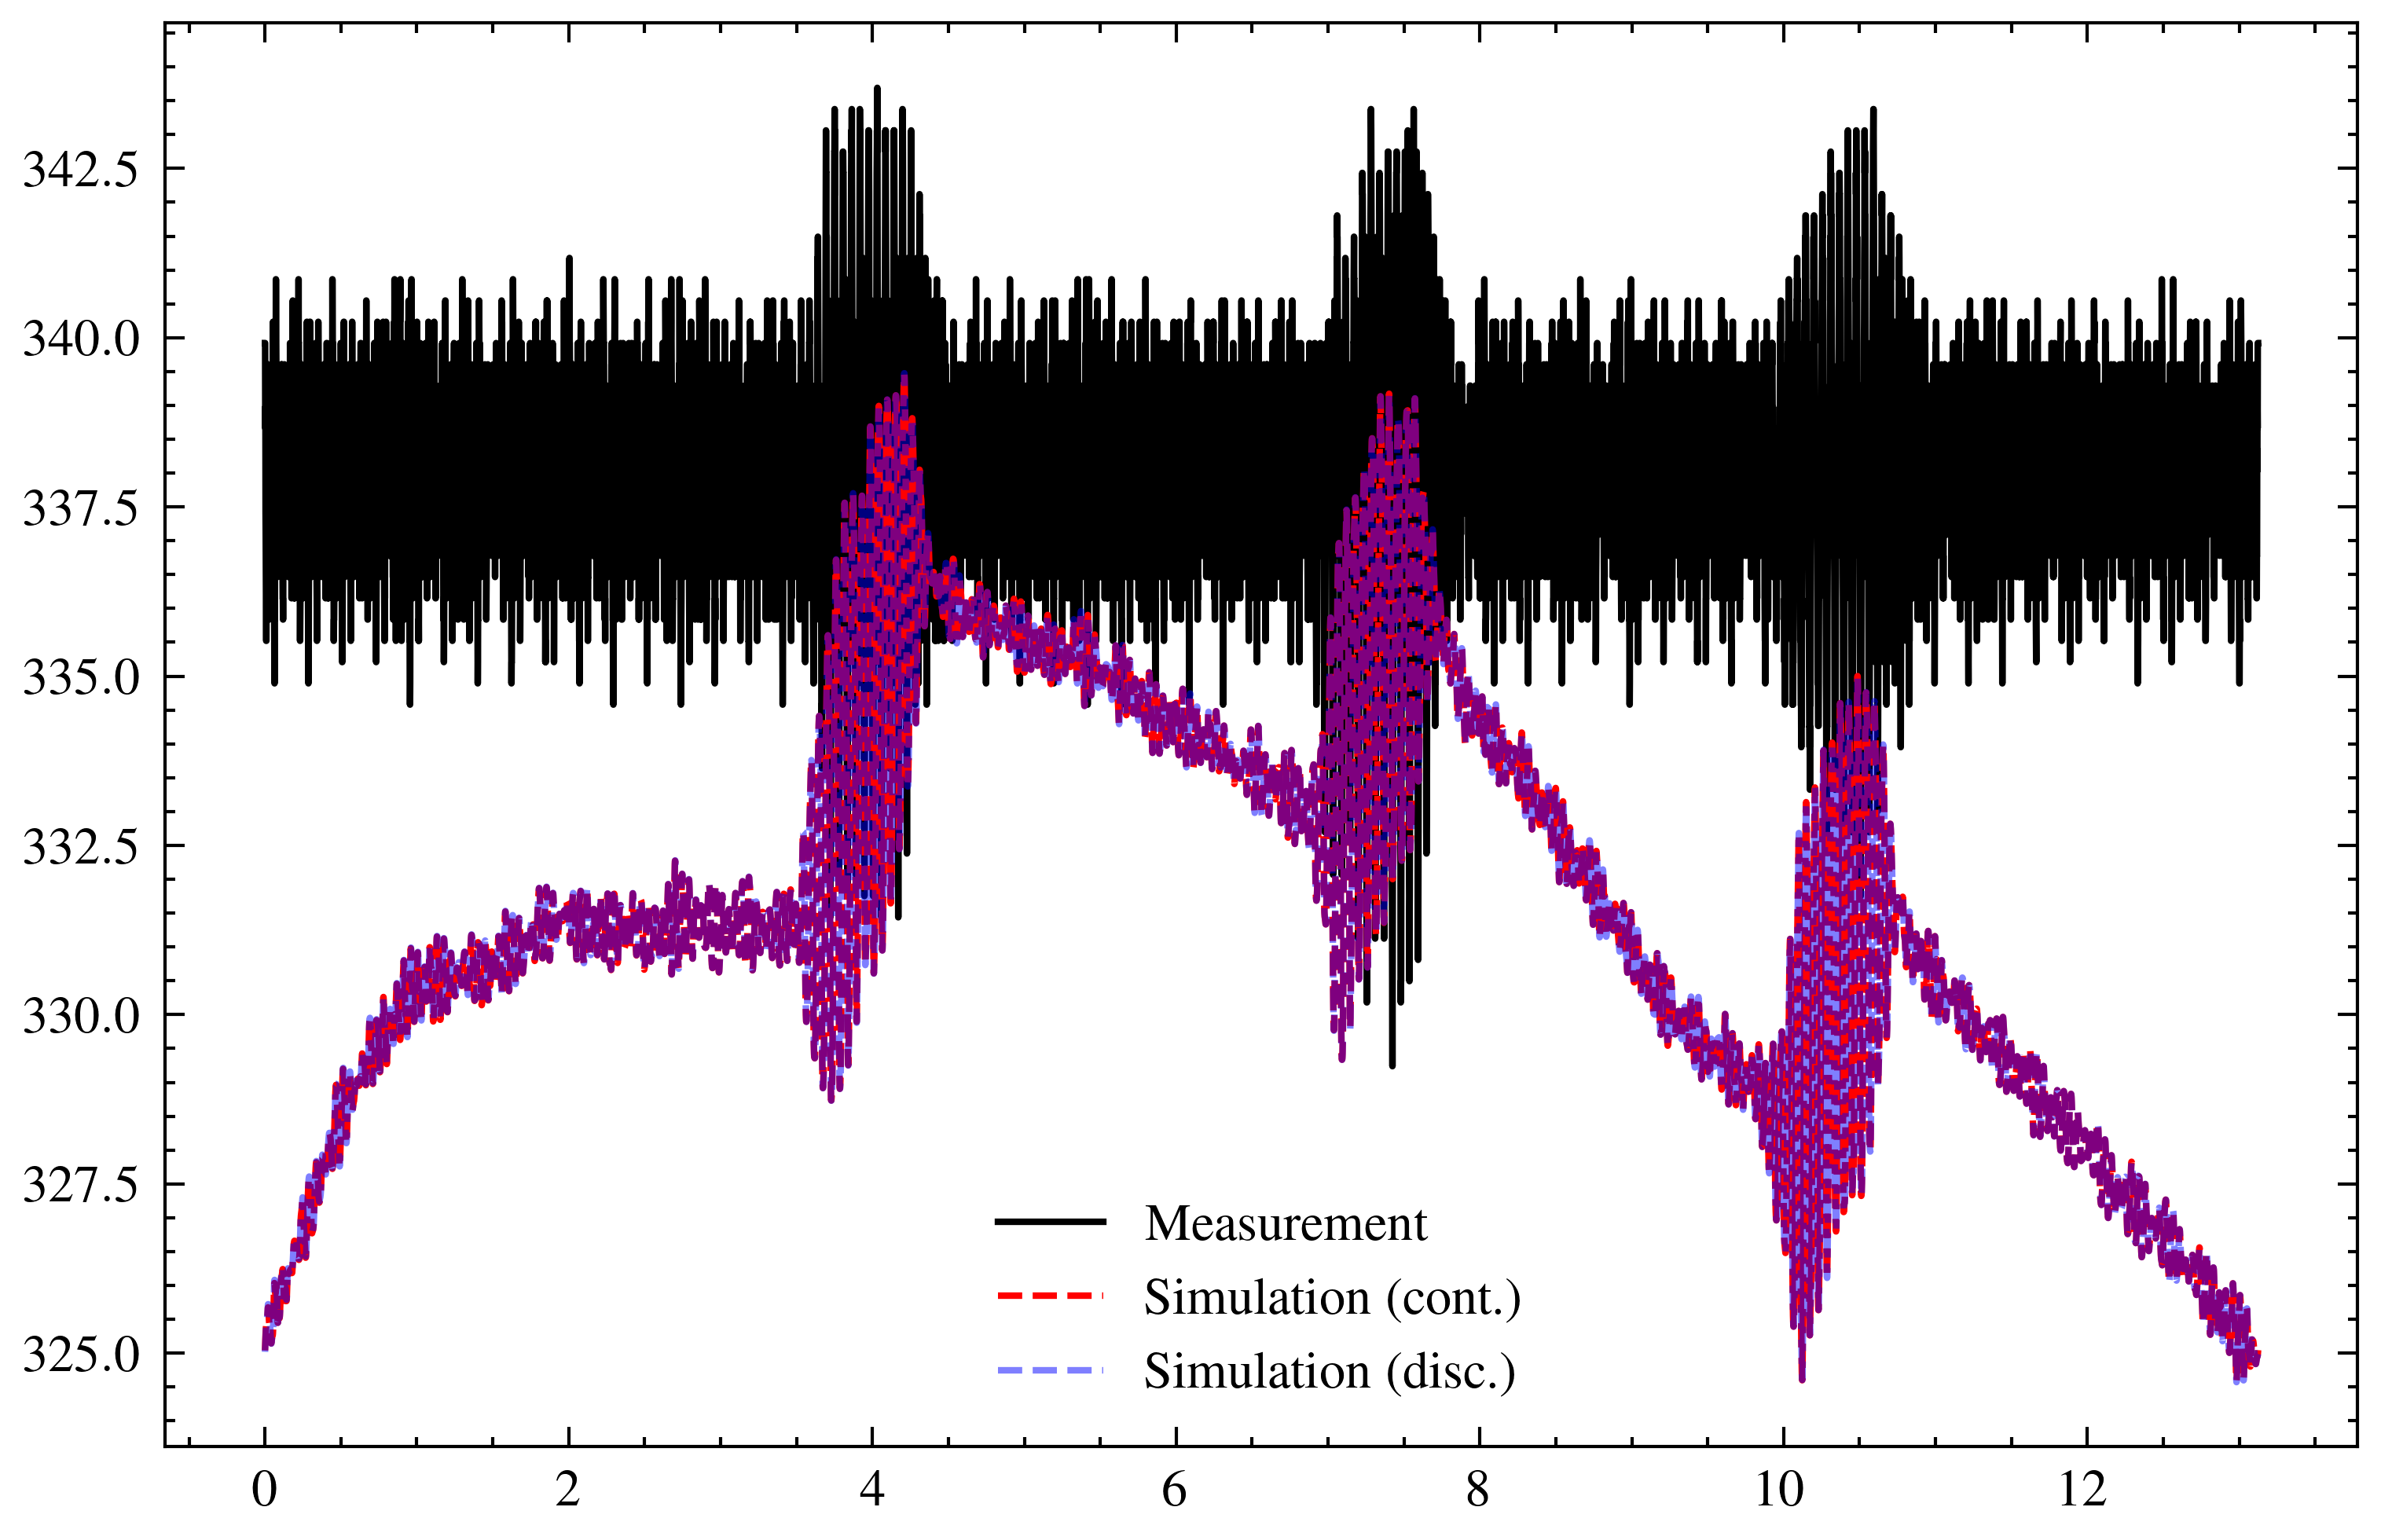

In [11]:
plt.plot(time_steps, angular_speeds[1,:], label='Measurement')
plt.plot(tout_mat, yout_mat[:,1], '--', label='Simulation (cont.)')
plt.plot(dtout_mat, dyout_mat[:,1], '--', label='Simulation (disc.)', alpha=0.5)
plt.legend()
#plt.xlim(6,12)
#plt.ylim(325,345)
plt.show()

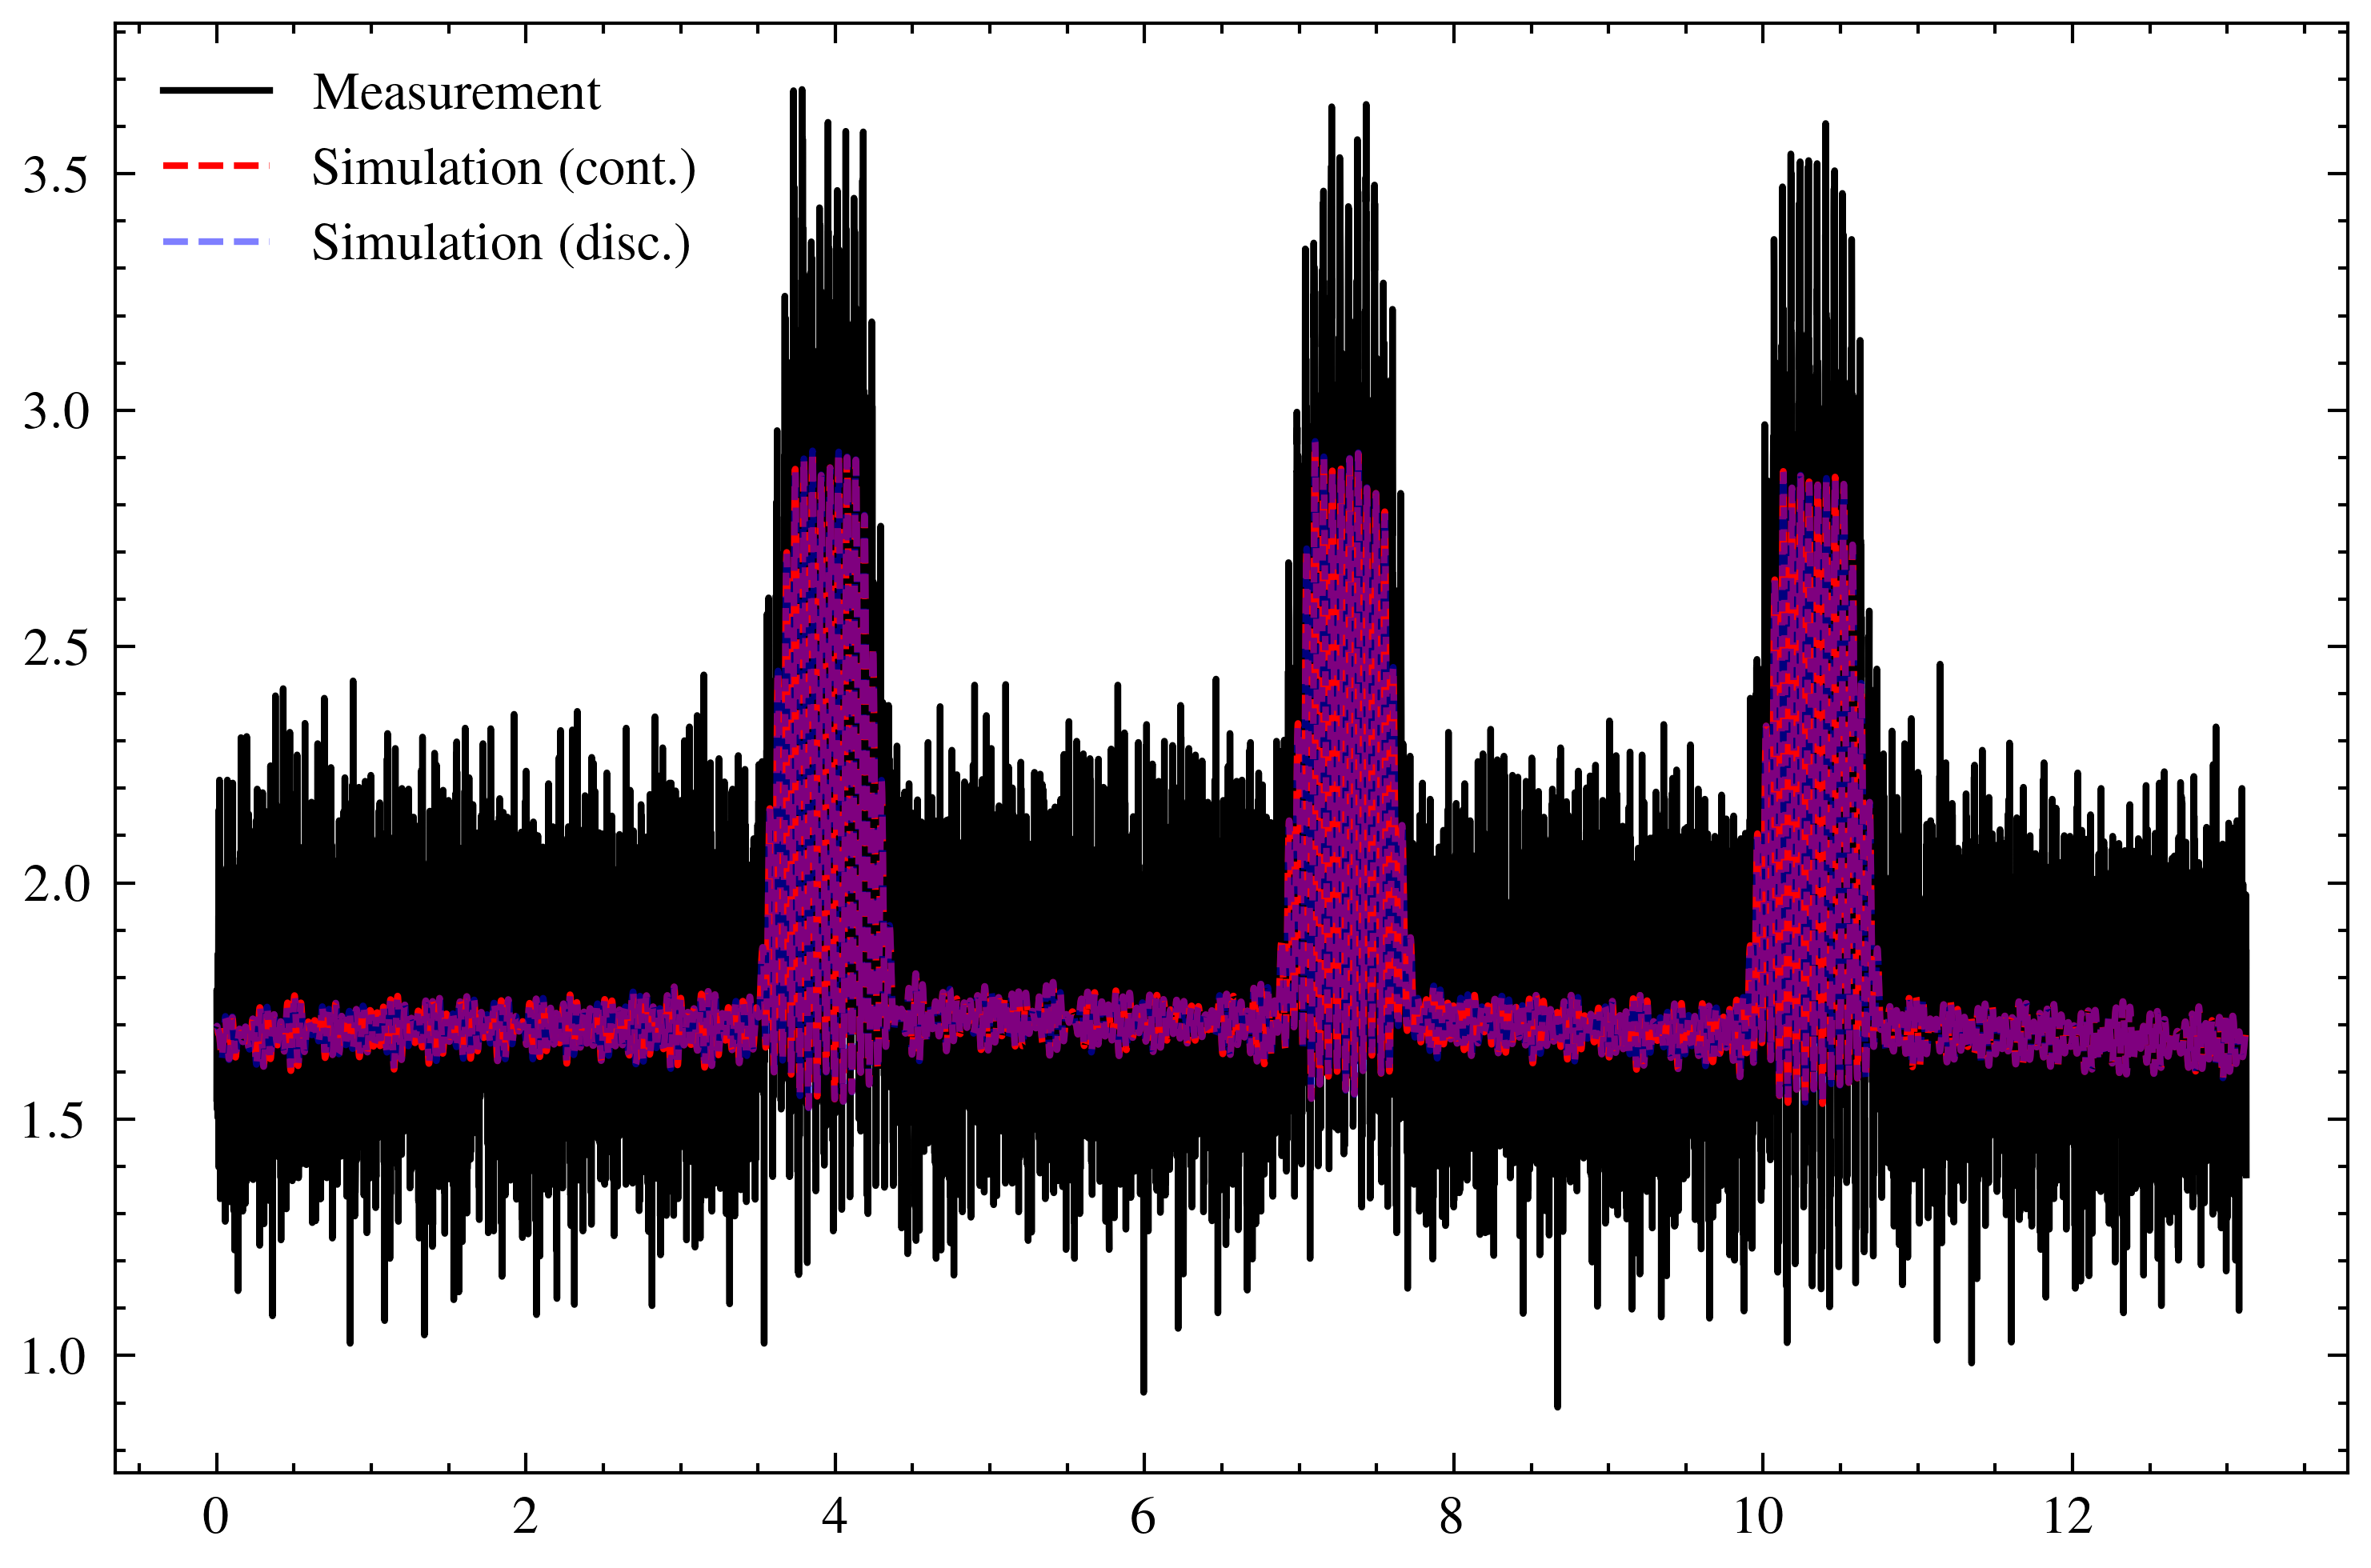

In [12]:
plt.plot(time_steps, shaft_torque, label='Measurement')
plt.plot(tout_mat, yout_mat[:,2], '--', label='Simulation (cont.)')
plt.plot(dtout_mat, dyout_mat[:,2], '--', label='Simulation (disc.)', alpha=0.5)
plt.legend()
plt.show()

# Input and state estimation functions

In [13]:
def O(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    A_power = np.copy(A)
    O = np.vstack((np.copy(C), C @ A))
    
    for k in range(n-2):
        A_power = A_power @ A
        O = np.vstack((O, C @ A_power))

    return O

In [14]:
def gamma(A, B, C, n):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    A_power = np.copy(A)
    Z = np.zeros((C @ B).shape)
    
    # first column
    gamma_column_first = np.vstack((
        Z,
        C @ B, 
        C @ A @ B
    ))
    for _ in range(n-3):
        A_power = A_power @ A
        gamma_column_first = np.vstack((gamma_column_first, C @ A_power @ B))

    # build complete matrix, column by column, from left to right
    gamma = np.copy(gamma_column_first)
    current_column = 1
    for _ in range(1, n):
        gamma_rows = Z
        
        # first add zero matrices
        for _ in range(current_column):
            gamma_rows = np.vstack((gamma_rows, Z))
        
        # then add the impulse responses
        A_power2 = np.copy(A)
        
        if current_column < (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B,
                C @ A @ B # these must not be added to the last and the second to last columns
            ))
            
        if current_column == (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B # this has to be added to the end of the second to last column
            ))
        
        for _ in range(n-current_column-3):
            A_power2 = A_power2 @ A
            gamma_rows = np.vstack((gamma_rows, C @ A_power2 @ B))

        # add column on the right hand side
        gamma = np.hstack((gamma, gamma_rows))
        current_column += 1
    
    return gamma

In [15]:
def L(input_shape):
    '''
    The regularization matrix L.

    Parameters:

    input_shape : float
        Input vector shape used to determine L matrix shape.

    Returns:

    L : ndarray
        The regularization matrix
    '''
    I = np.eye(input_shape)
    L = -I + np.diag(np.ones(input_shape-1), 1)

    return I

In [16]:
def second_difference_matrix(n, m):
    D2 = np.eye(n*m) - 2*np.eye(n*m, k=2) + np.eye(n*m, k=4)
    
    # delete incomplete rows
    D2 = D2[:-2*m, :]
    
    return D2

In [17]:
def fourier_coeff_matrix():
    
    return F

In [18]:
def tikhonov_problem(meas, obsrv, gamm, regu, initial_state=None, lam=1, cmplx=False):
    '''
    This function uses the cvxpy library to solve a Tikhonov regularization problem.
    '''
    d = cp.Variable((gamm.shape[1], 1), complex=cmplx)
    #x = cp.Variable((obsrv.shape[1], 1), complex=cmplx)
    
    if initial_state is not None:
        x = initial_state
    else:        
        x = np.zeros((obsrv.shape[1], 1))
        
    measurements = cp.Parameter(meas.shape)
    measurements.value = meas
    
    objective = cp.Minimize(cp.sum_squares(measurements - obsrv @ x - gamm @ d) + lam * cp.sum_squares(regu @ d))
    
    prob = cp.Problem(objective)
    prob.solve()

    return d.value, x#.value

In [19]:
def lasso_problem(meas, obsrv, gamm, regu, initial_state=None, lam=1, cmplx=False):
    '''
    This function uses the cvxpy library to solve a LASSO problem.
    '''
    d = cp.Variable((gamm.shape[1], 1), complex=cmplx)
    #x = cp.Variable((obsrv.shape[1], 1), complex=cmplx)
    
    if initial_state is not None:
        x = initial_state
    else:        
        x = np.zeros((obsrv.shape[1], 1))
        
    measurements = cp.Parameter(meas.shape)
    measurements.value = meas
    
    objective = cp.Minimize(cp.sum_squares(measurements - obsrv @ x - gamm @ d) + lam * cp.pnorm(regu @ d, 1))
    
    prob = cp.Problem(objective)
    prob.solve()

    return d.value, x#.value

# Tikhonov regularization and $\ell_1$- regularization

## Impulse load

In [20]:
t = np.arange(0, 1.200, 0.002)
d_t = np.mean(np.diff(t))
N = len(t)
m = B_mat_d.shape[1]

# Impulse load applied at first and last nodes
impulse_ex = np.zeros((len(t), 2))
ramp = np.arange(0, 0.5, 1/16)
ramp2 = np.arange(0, 1, 1/8)

impulse_ex[22:30,0] = ramp
impulse_ex[30,0] = 0.5
impulse_ex[31:39,0] = ramp[::-1]

impulse_ex[42:50,1] = ramp2
impulse_ex[50,1] = 1
impulse_ex[51:59,1] = ramp2[::-1]

In [21]:
O_test = O(A_mat_d, C_mat, N)
G_test = gamma(A_mat_d, B_mat_d, C_mat, N)
x0d = np.zeros(O_test.shape[1])
x0 = np.zeros((O_test.shape[1],1))

In [22]:
dtout_imp, dyout_imp, dxout_imp = dlsim((A_mat_d, B_mat_d, C_mat, D_mat, d_t), impulse_ex, t=t, x0=x0d)

impulse_ex_reshaped = impulse_ex.reshape(-1, 1)

y_hat = O_test @ x0 + G_test @ impulse_ex_reshaped

meases = np.hstack(np.vsplit(y_hat, N))

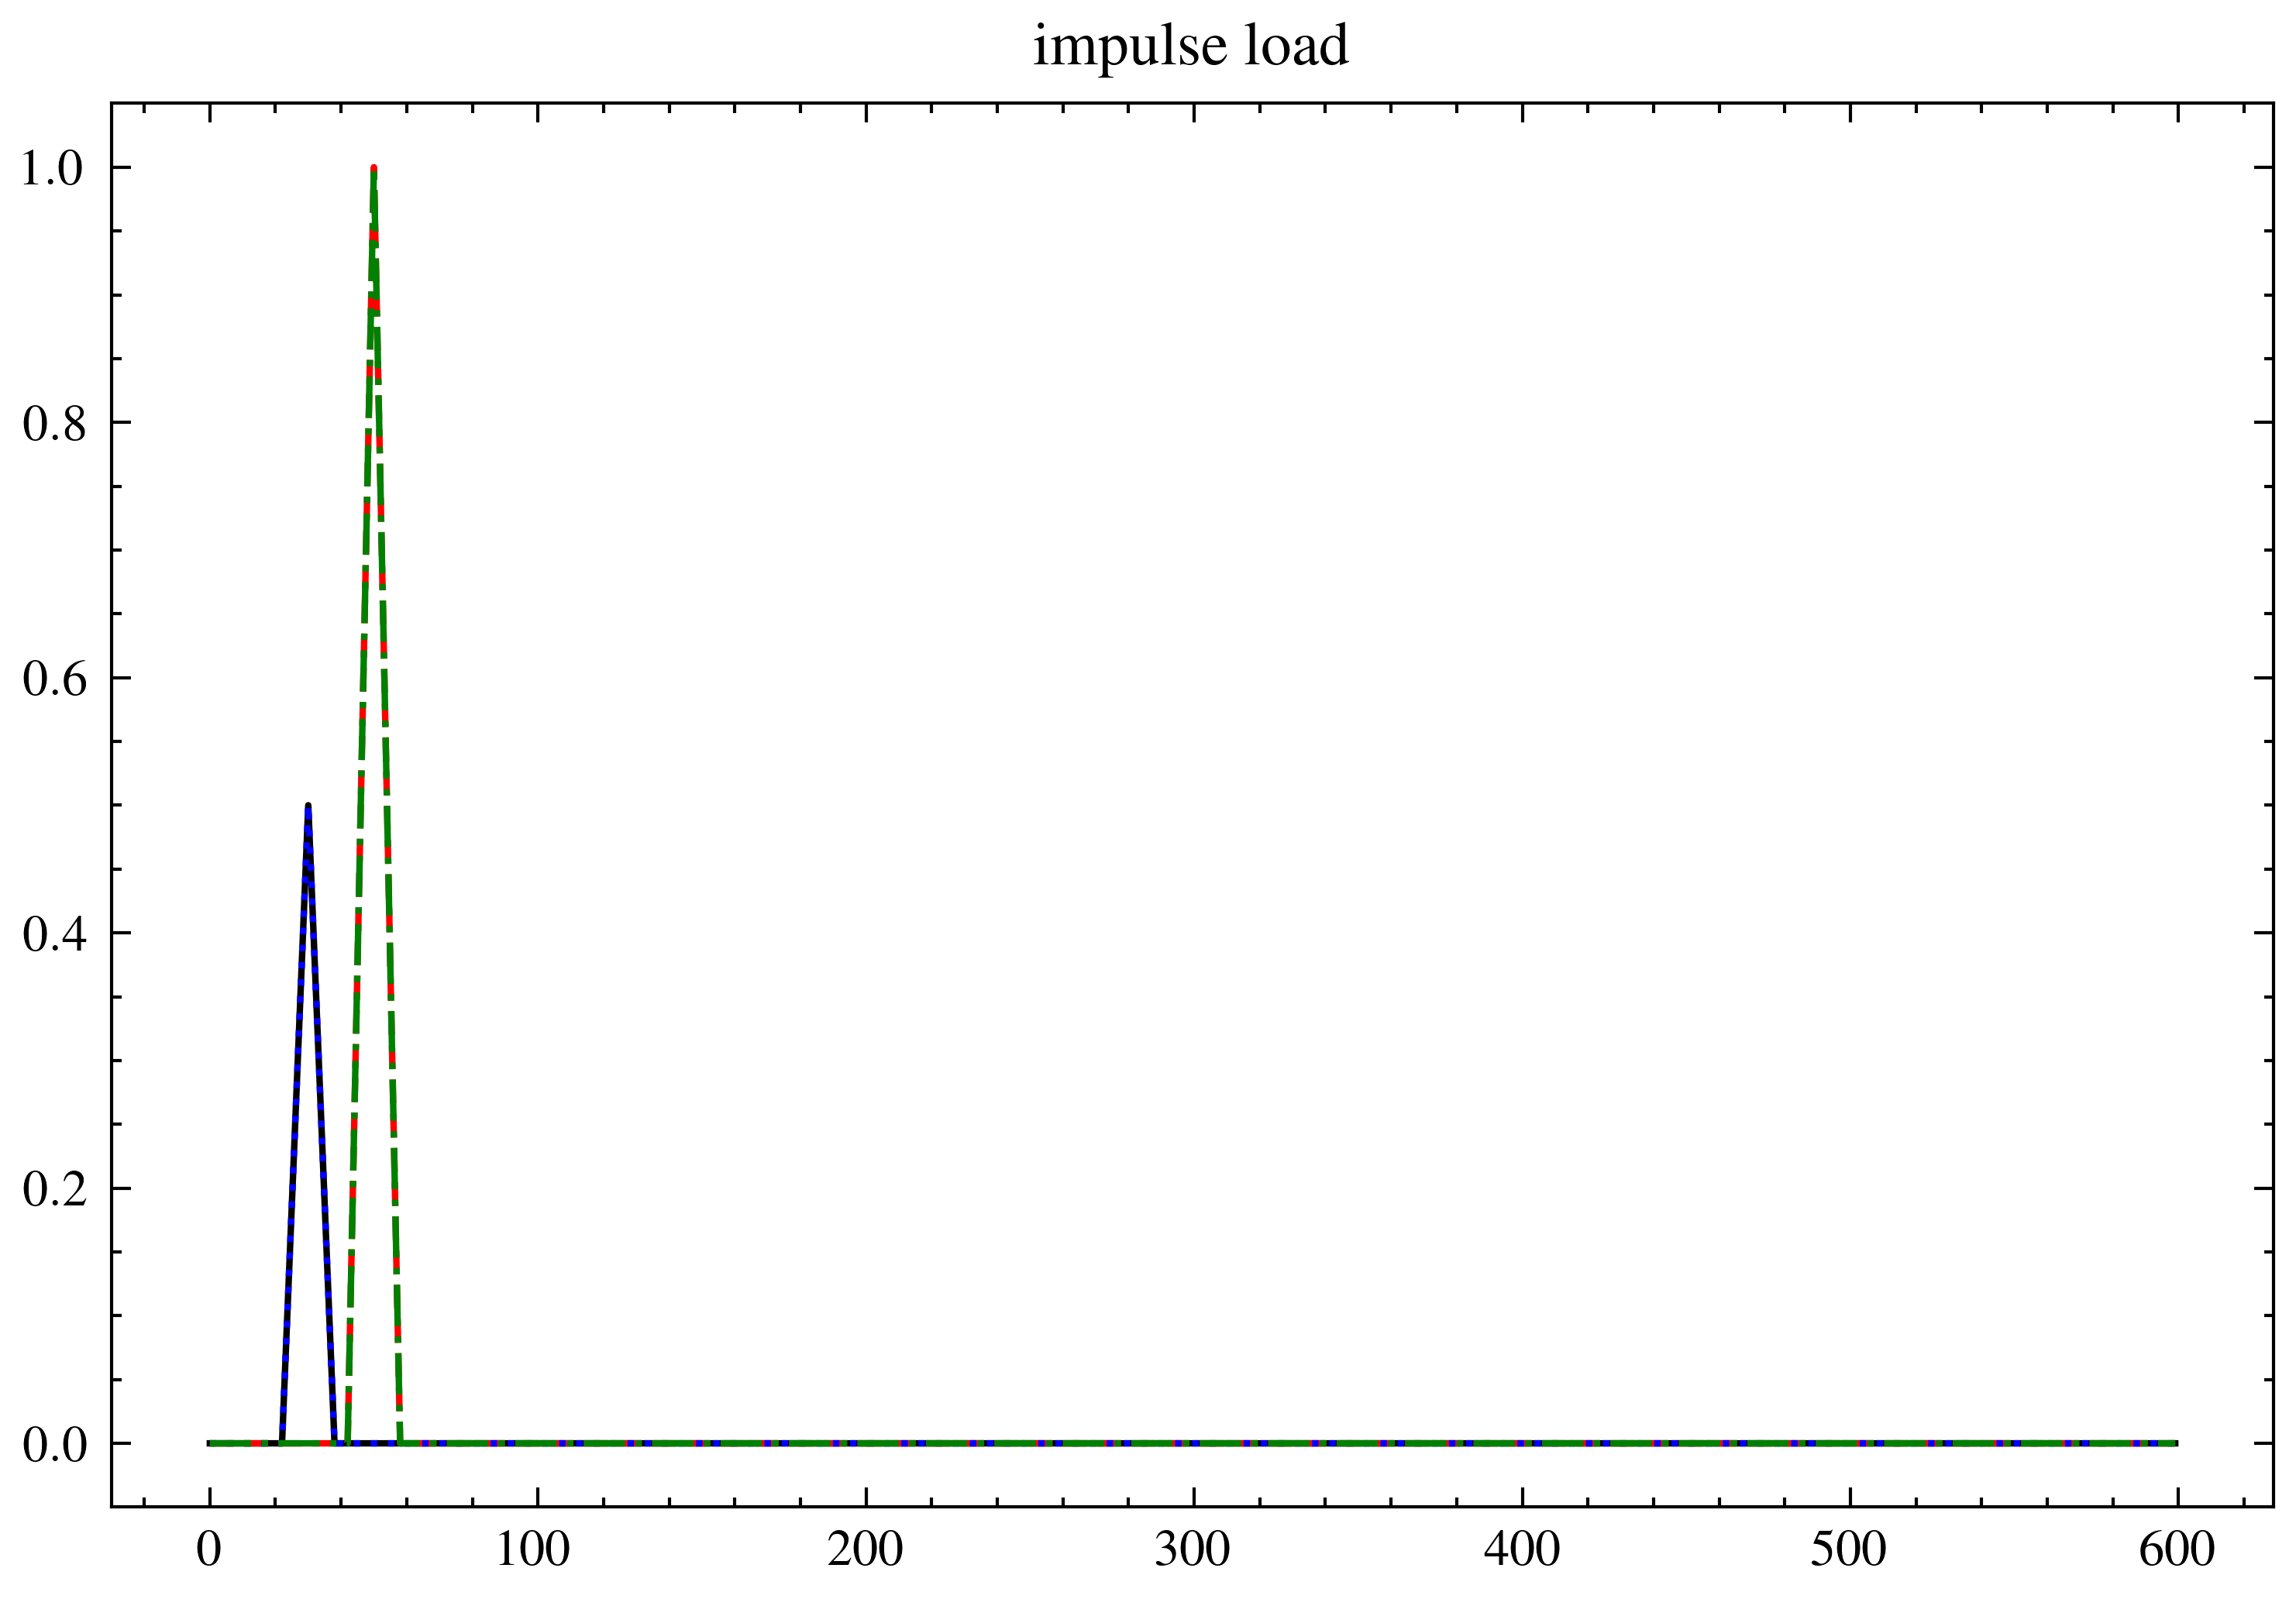

In [23]:
plt.plot(impulse_ex)
plt.plot(impulse_ex_reshaped[::2])
plt.plot(impulse_ex_reshaped[1::2])
plt.title('impulse load')
plt.show()

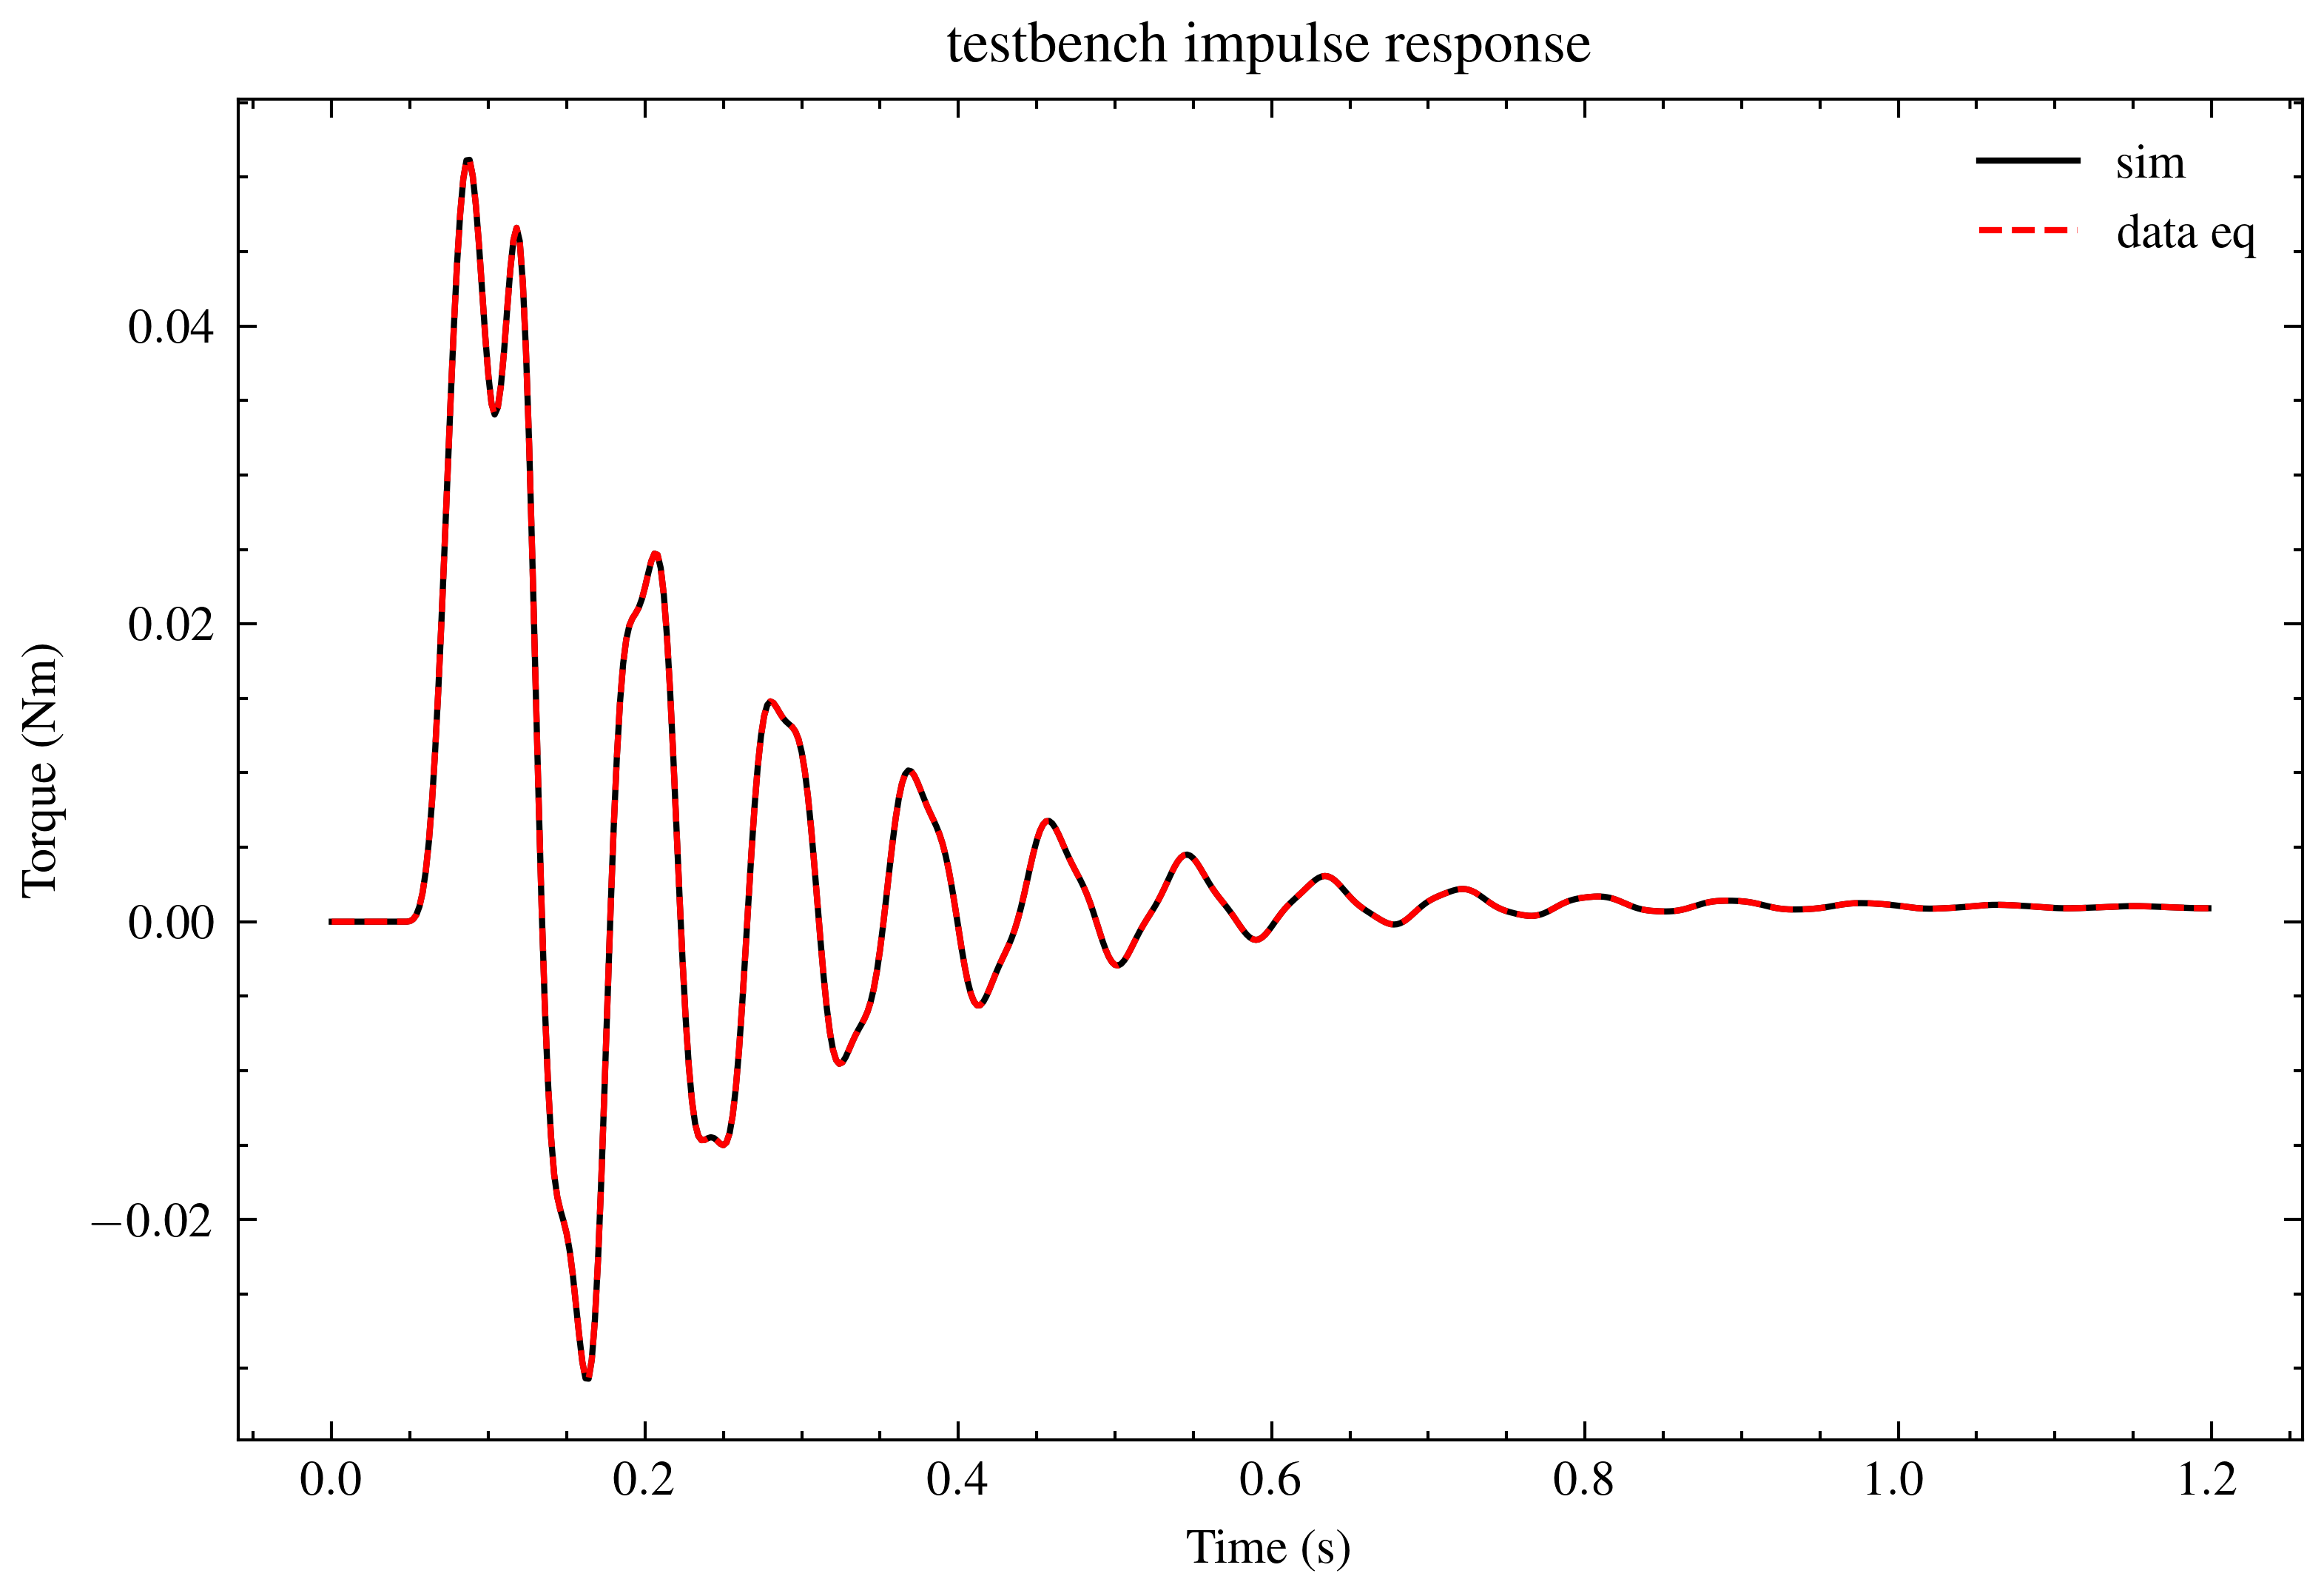

In [24]:
plt.plot(t, dyout_imp[:,-1], label='sim')
plt.plot(t, meases[-1,:], label='data eq')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('testbench impulse response')
plt.show()

In [25]:
L_test = L(m*N)

R_ = 1e-3*np.eye(C_mat.shape[0]) # measurement covariance, shape (n_sensors, n_sensors)
r = np.random.multivariate_normal(np.zeros(R_.shape[0]), R_, t.shape[0])
e = np.reshape(r.T, (-1,1))

Y = np.reshape(dyout_imp, (-1,1))
noisy_meas = Y + e

In [26]:
u_hat, x_hat = tikhonov_problem(noisy_meas, O_test, G_test, L_test, initial_state=x0, lam=0.01)
u_hat_l, x_hat_l = lasso_problem(noisy_meas, O_test, G_test, L_test, initial_state=x0, lam=0.05)

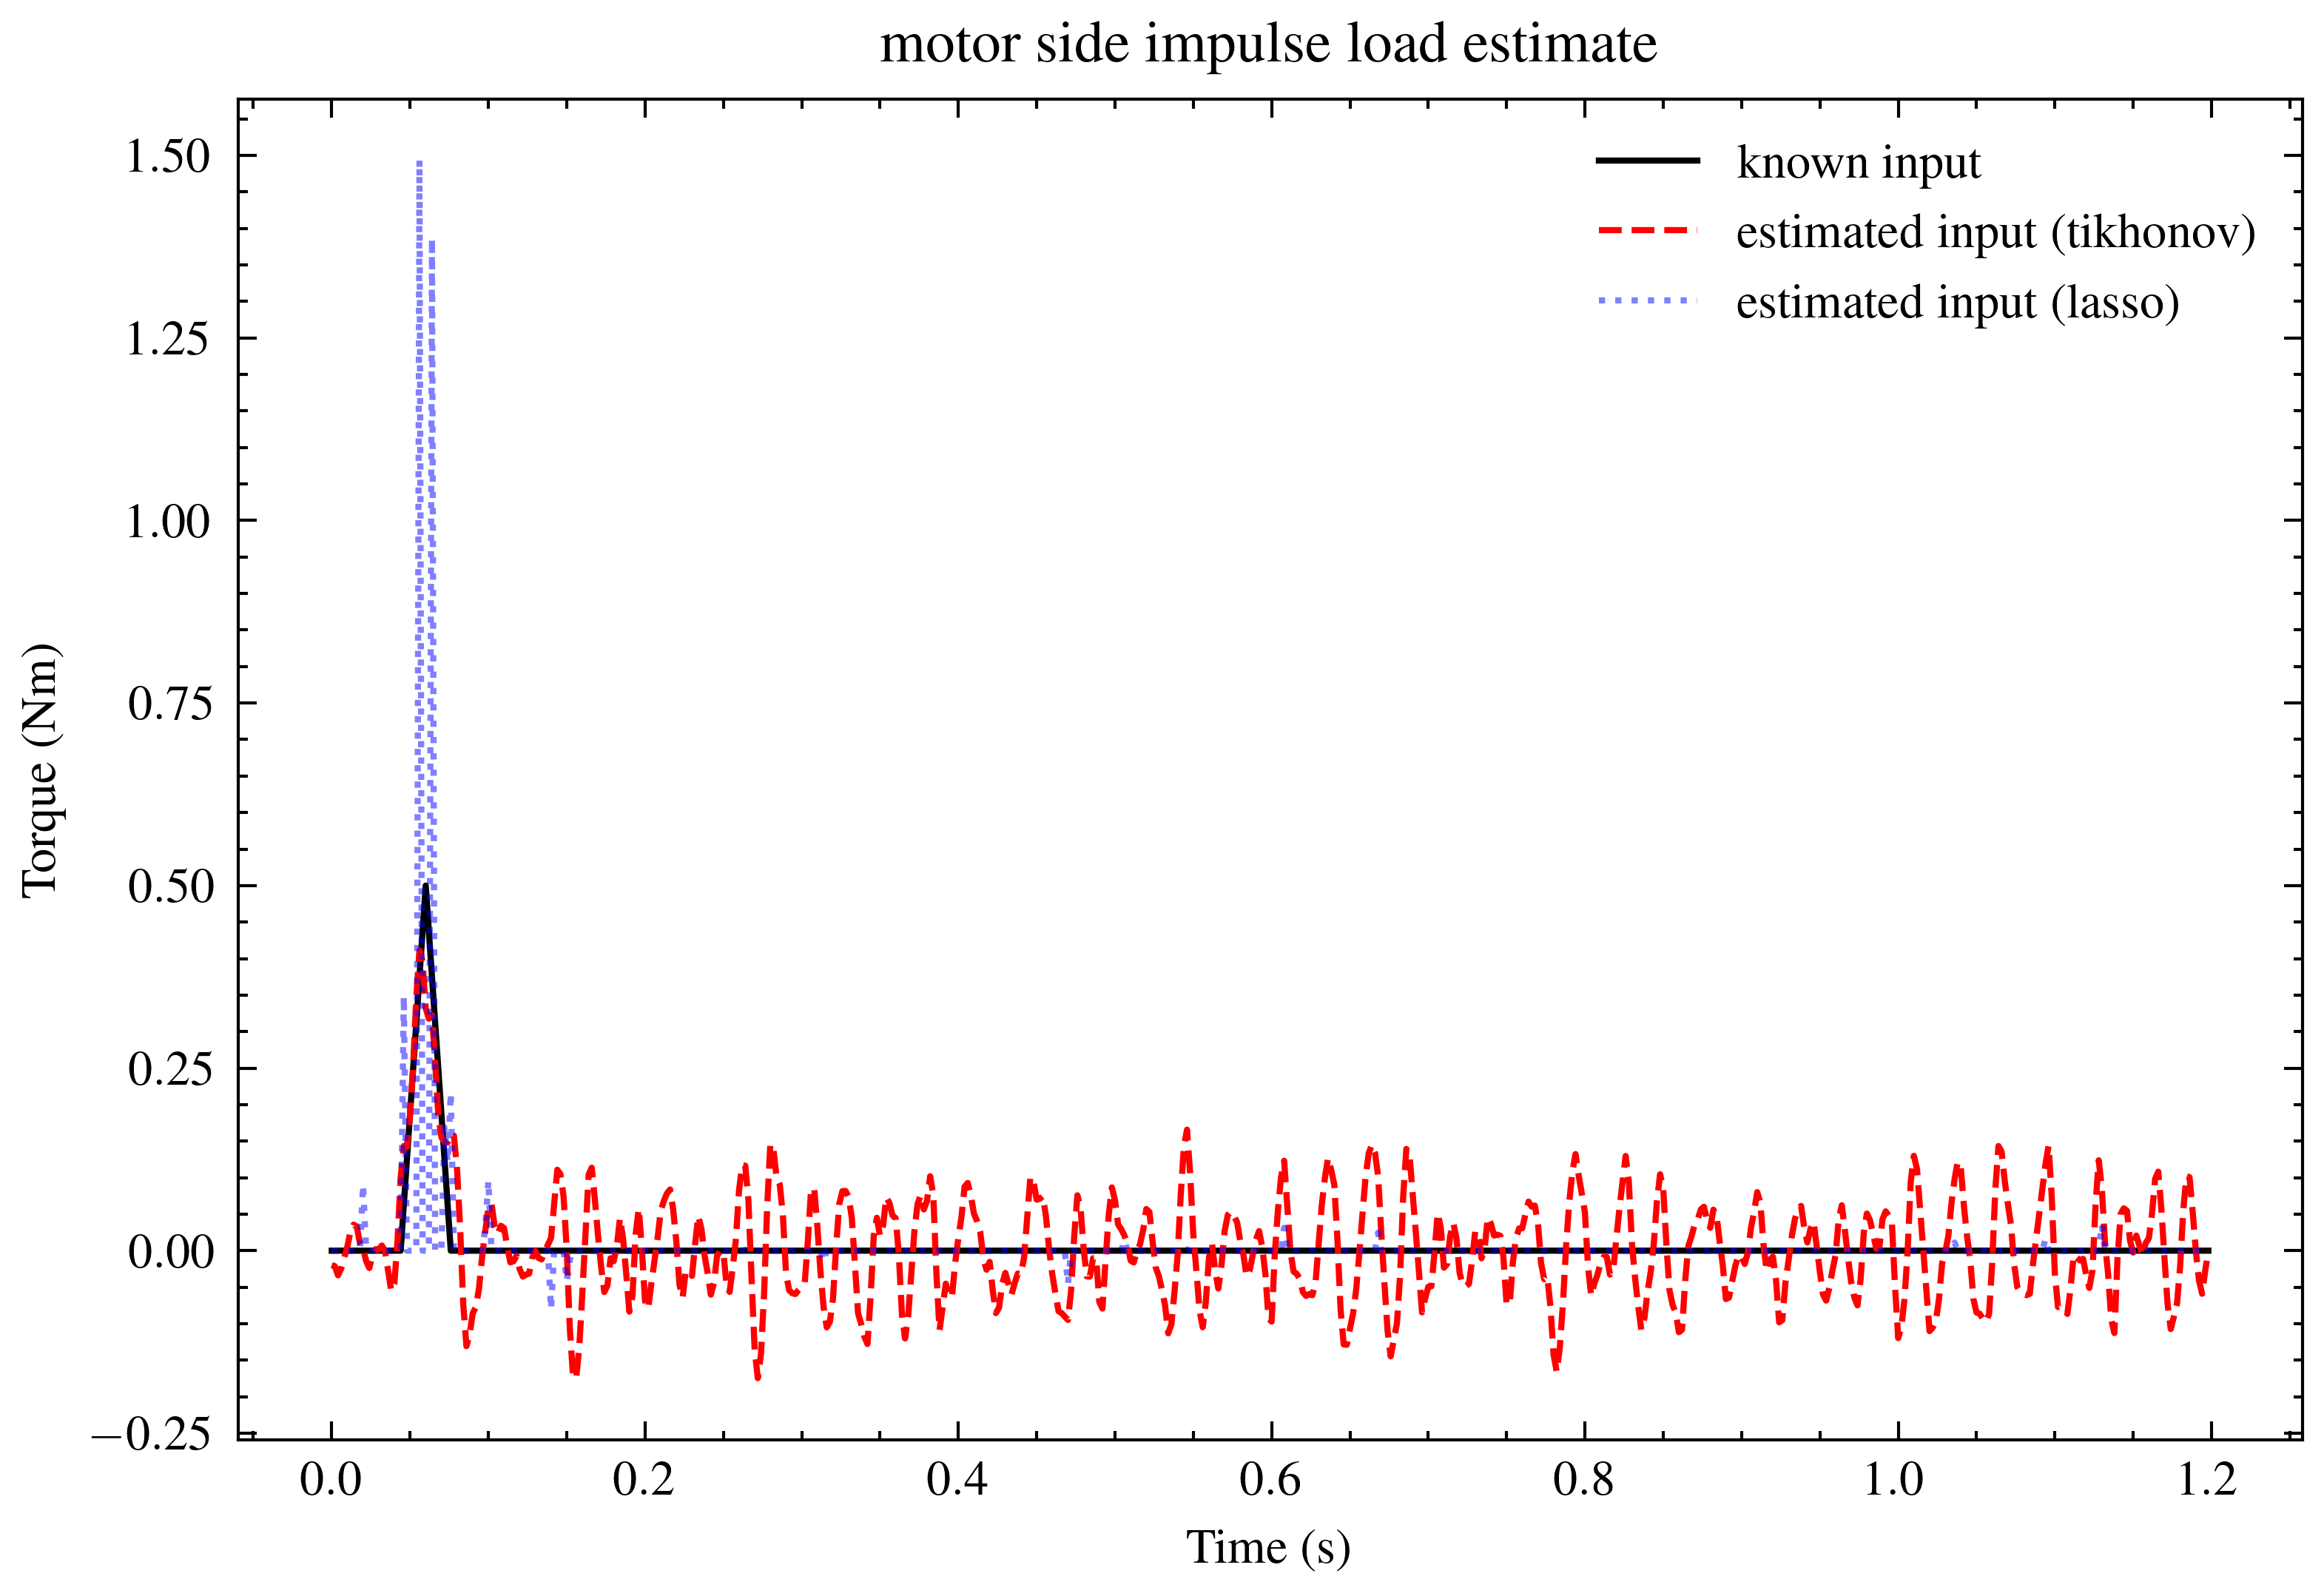

In [27]:
plt.plot(t, impulse_ex_reshaped[::2], label='known input')
plt.plot(t, u_hat[::2], label='estimated input (tikhonov)')
plt.plot(t, u_hat_l[::2], label='estimated input (lasso)', alpha=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('motor side impulse load estimate')
plt.show()

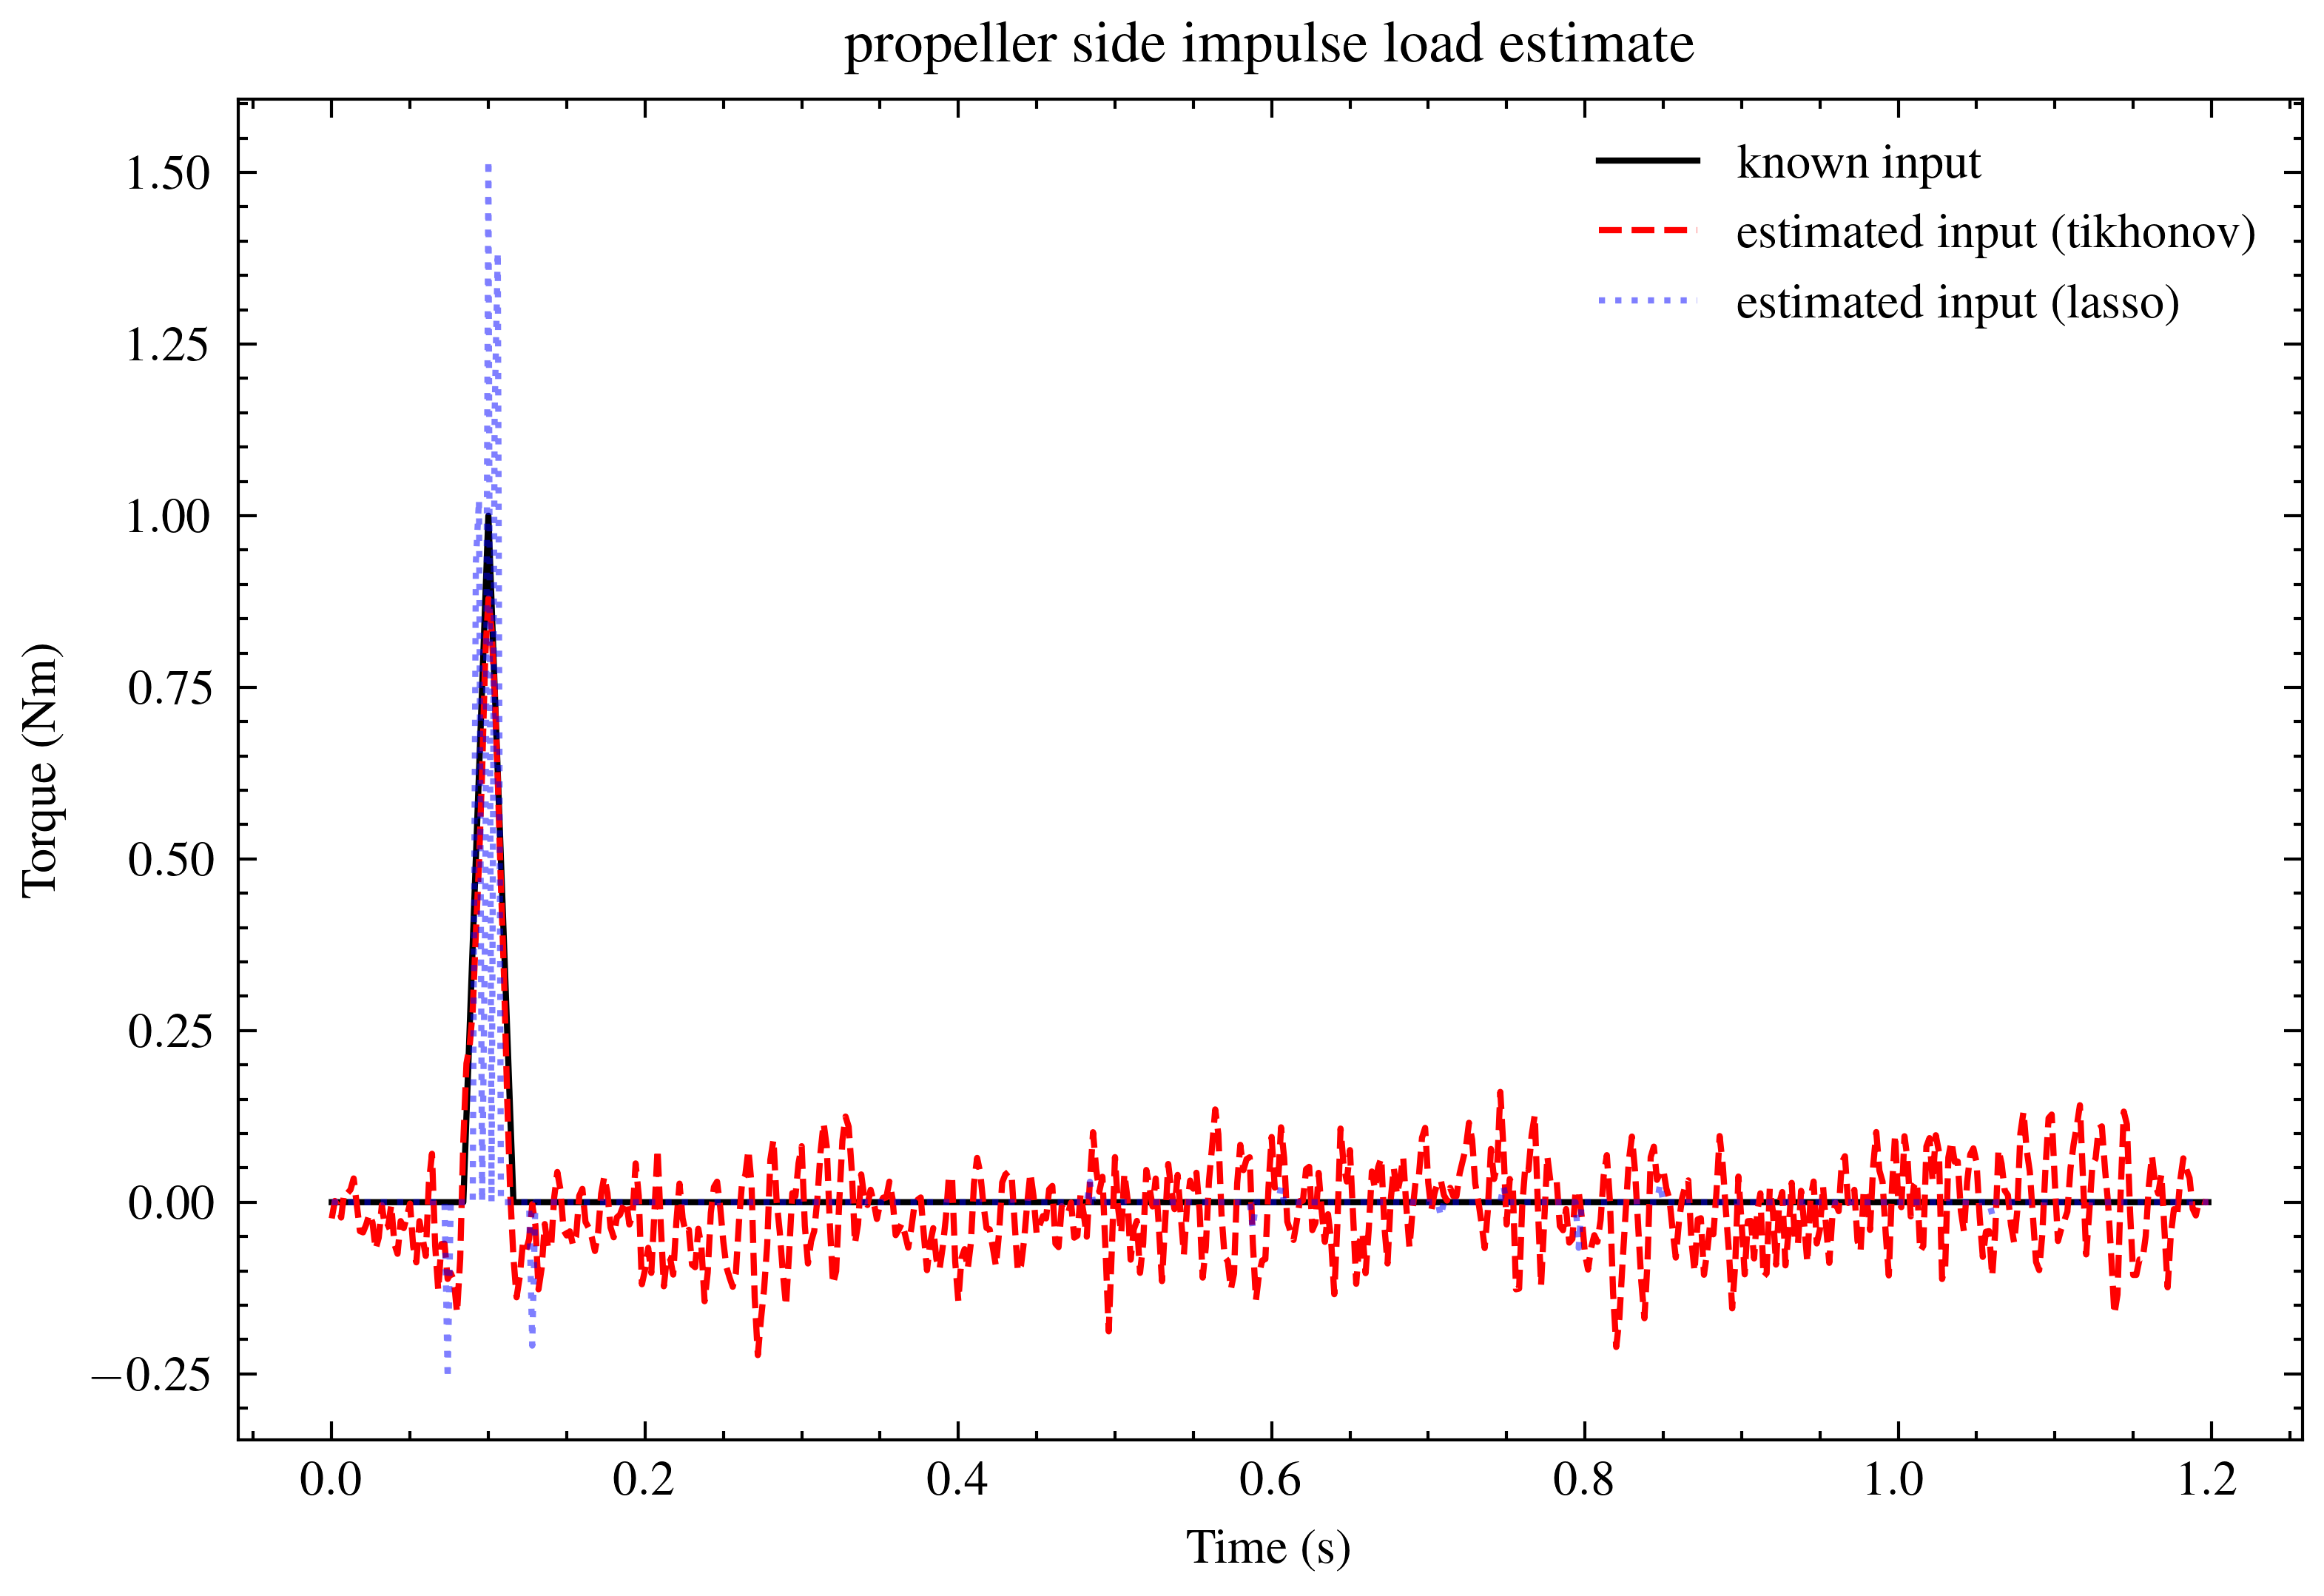

In [28]:
plt.plot(t, impulse_ex_reshaped[1::2], label='known input')
plt.plot(t, u_hat[1::2], label='estimated input (tikhonov)')
plt.plot(t, u_hat_l[1::2], label='estimated input (lasso)', alpha=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('propeller side impulse load estimate')
plt.show()

## Sinusoidal load

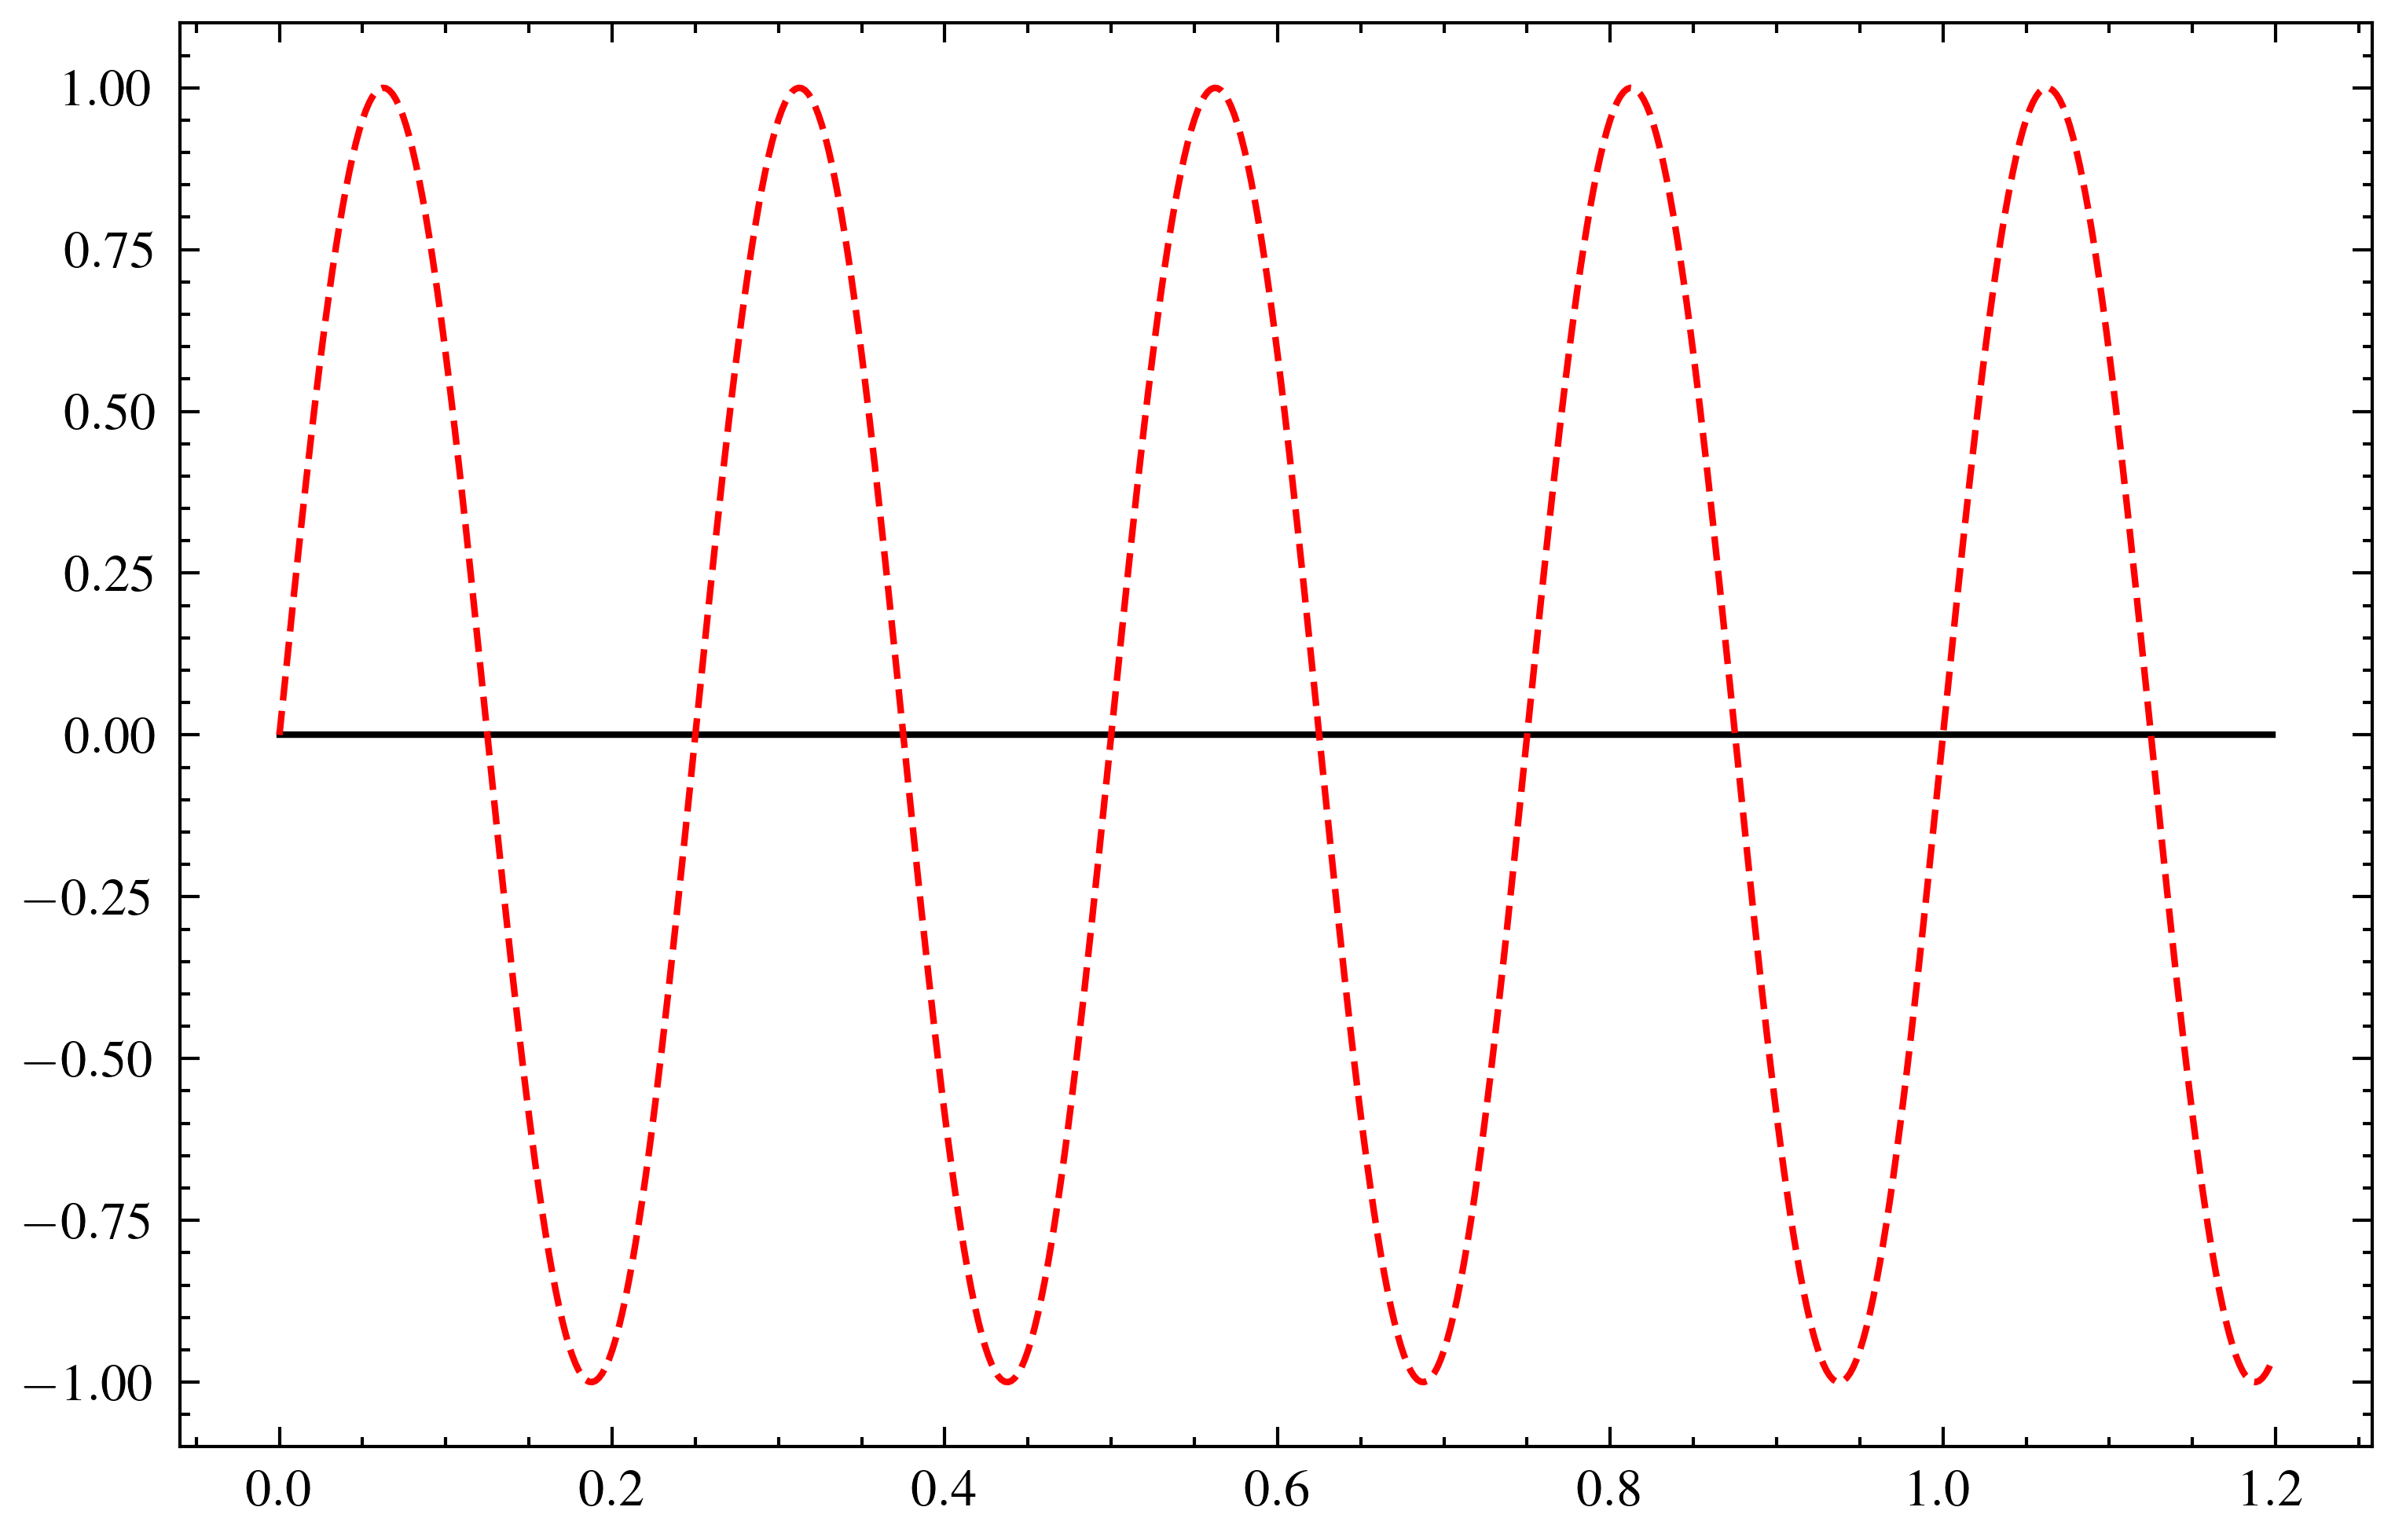

In [29]:
sin_ex = np.zeros((len(t), 2))
sin_ex[:,1] += np.sin(4*2*np.pi*t)

plt.plot(t, sin_ex)
plt.show()

In [30]:
dtout_sin, dyout_sin, dxout_sin = dlsim((A_mat_d, B_mat_d, C_mat, D_mat, d_t), sin_ex, t=t, x0=x0d)

sin_ex_reshaped = sin_ex.reshape(-1, 1)
y_hat_sin = O_test @ x0 + G_test @ sin_ex_reshaped
meases_sin = np.hstack(np.vsplit(y_hat_sin, N))

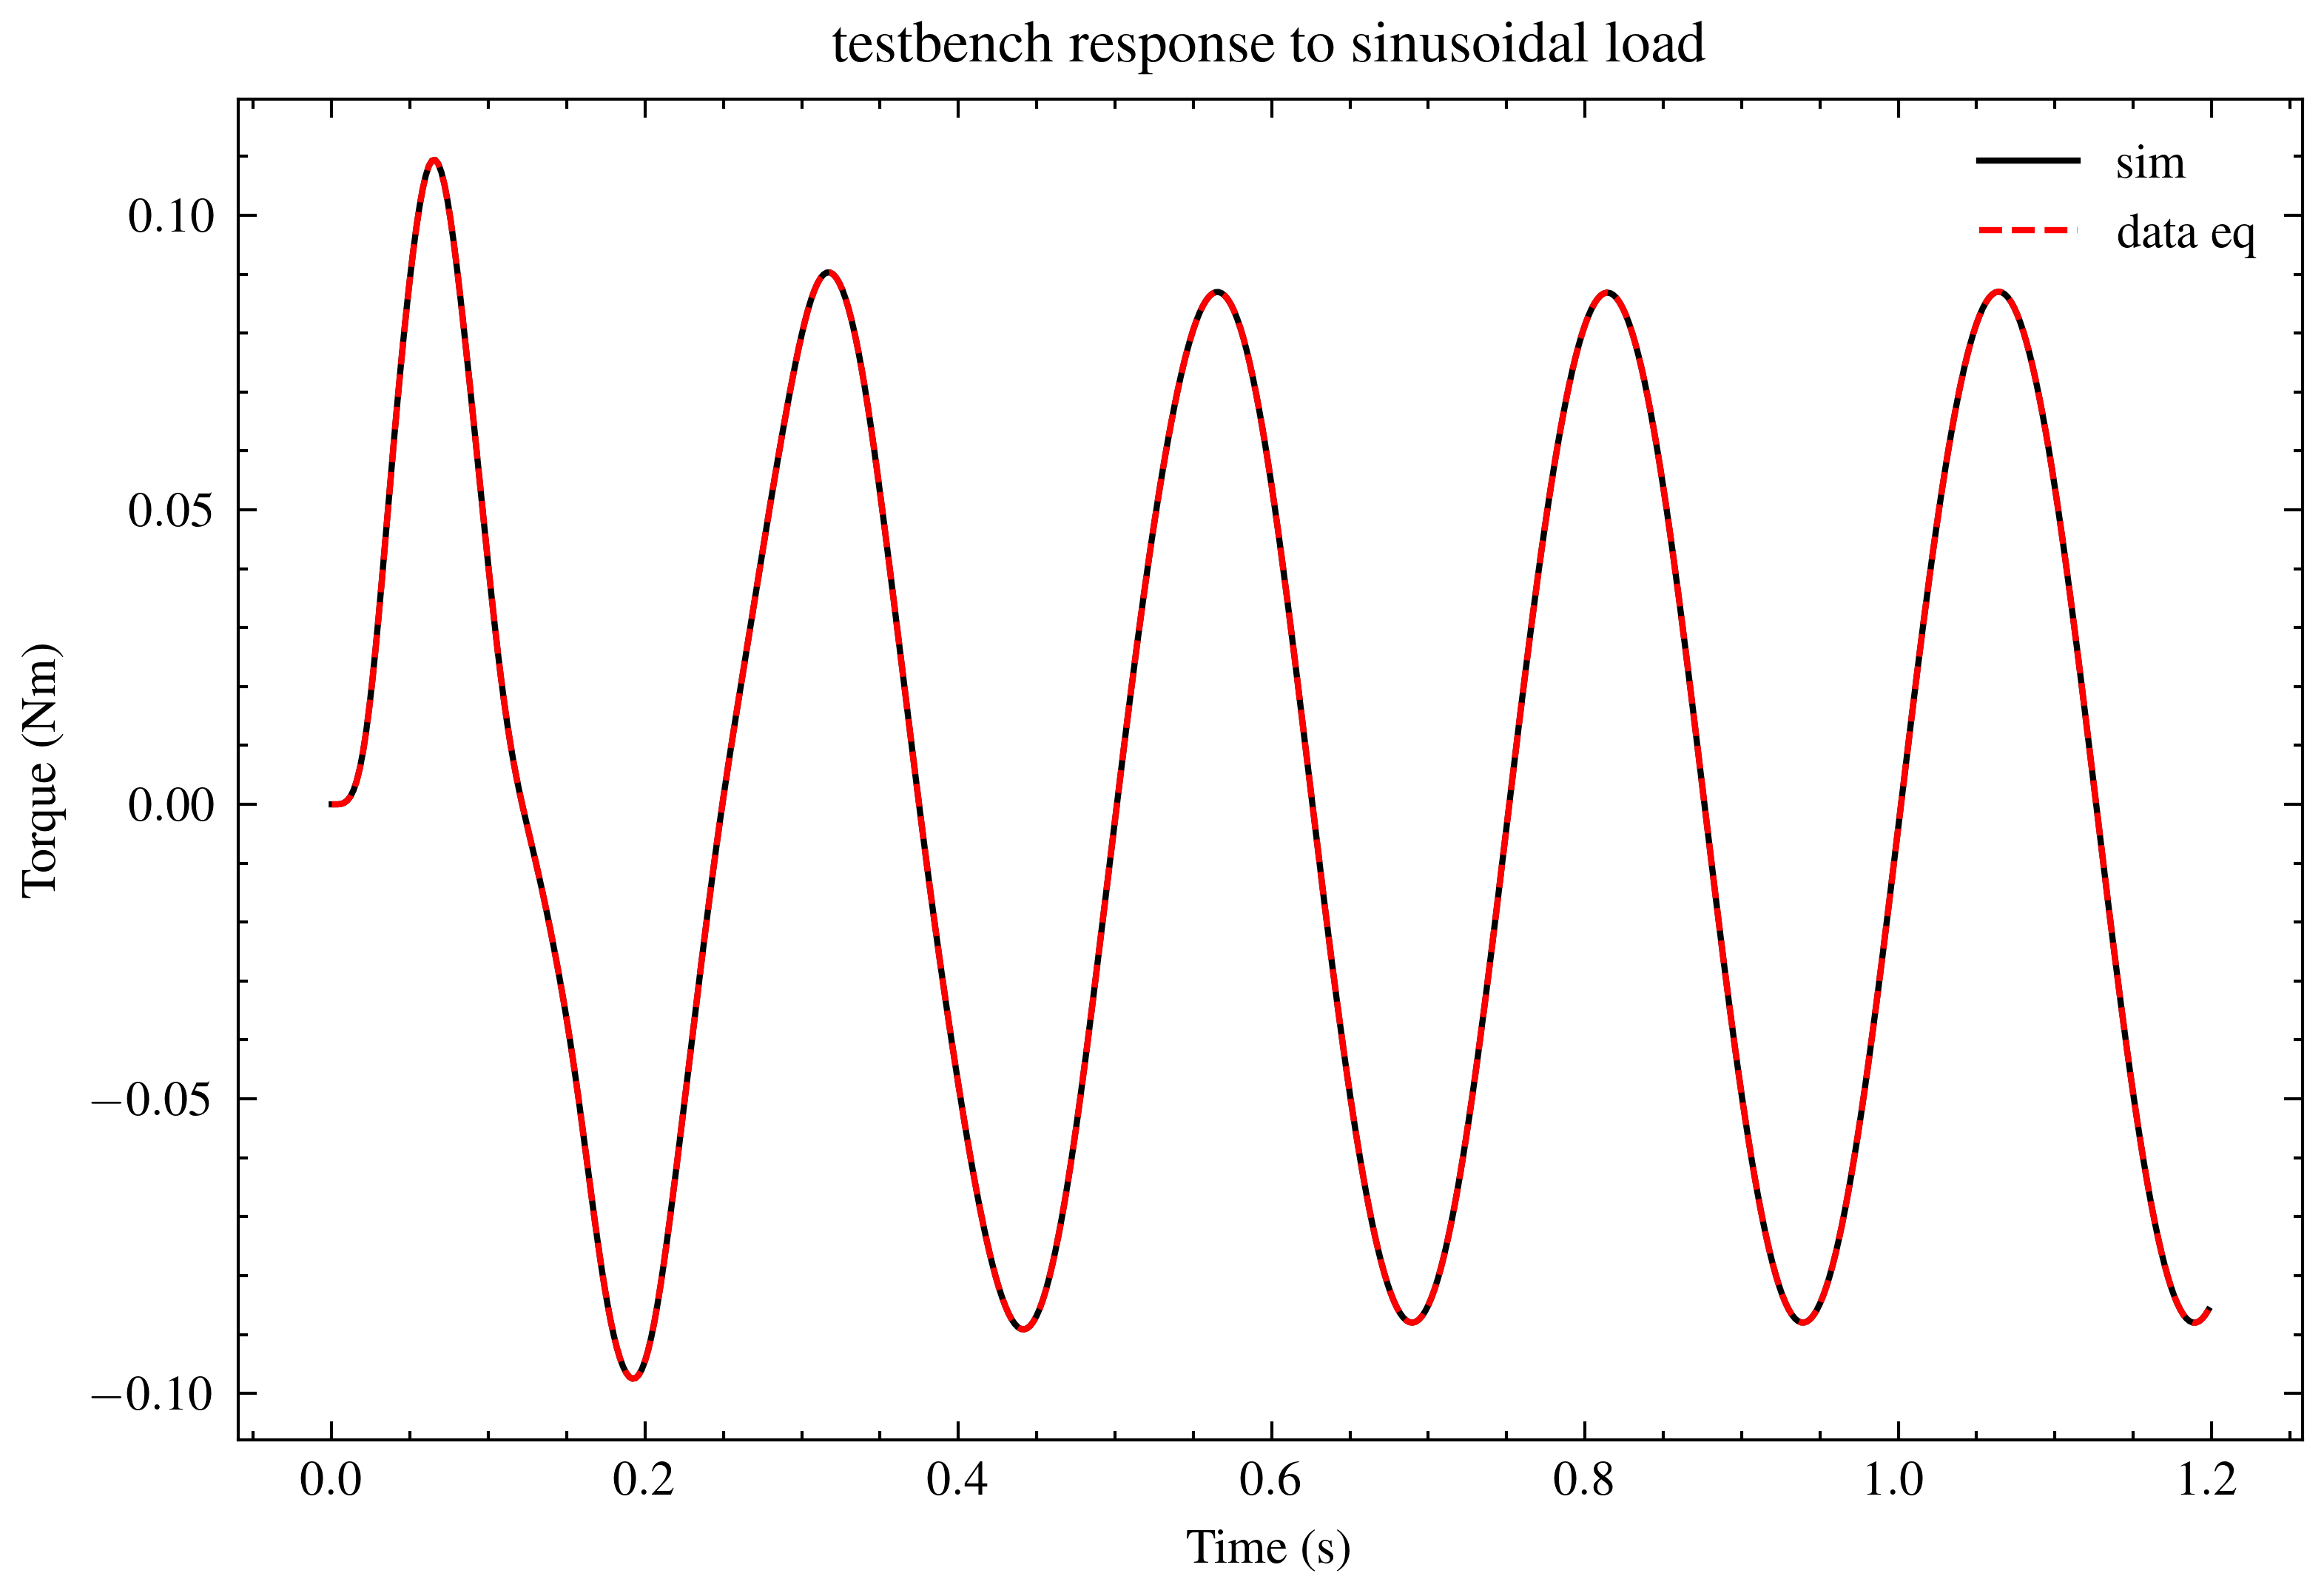

In [31]:
plt.plot(t, dyout_sin[:,-1], label='sim')
plt.plot(t, meases_sin[-1,:], label='data eq')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('testbench response to sinusoidal load')
plt.show()

In [32]:
Y_sin = np.reshape(dyout_sin, (-1,1))
noisy_meas_sin = Y_sin + e

In [33]:
u_hat_sin, x_hat_sin = tikhonov_problem(noisy_meas_sin, O_test, G_test, L_test, initial_state=x0, lam=0.01)
u_hat_l_sin, x_hat_l_sin = lasso_problem(noisy_meas_sin, O_test, G_test, L_test, initial_state=x0, lam=0.05)

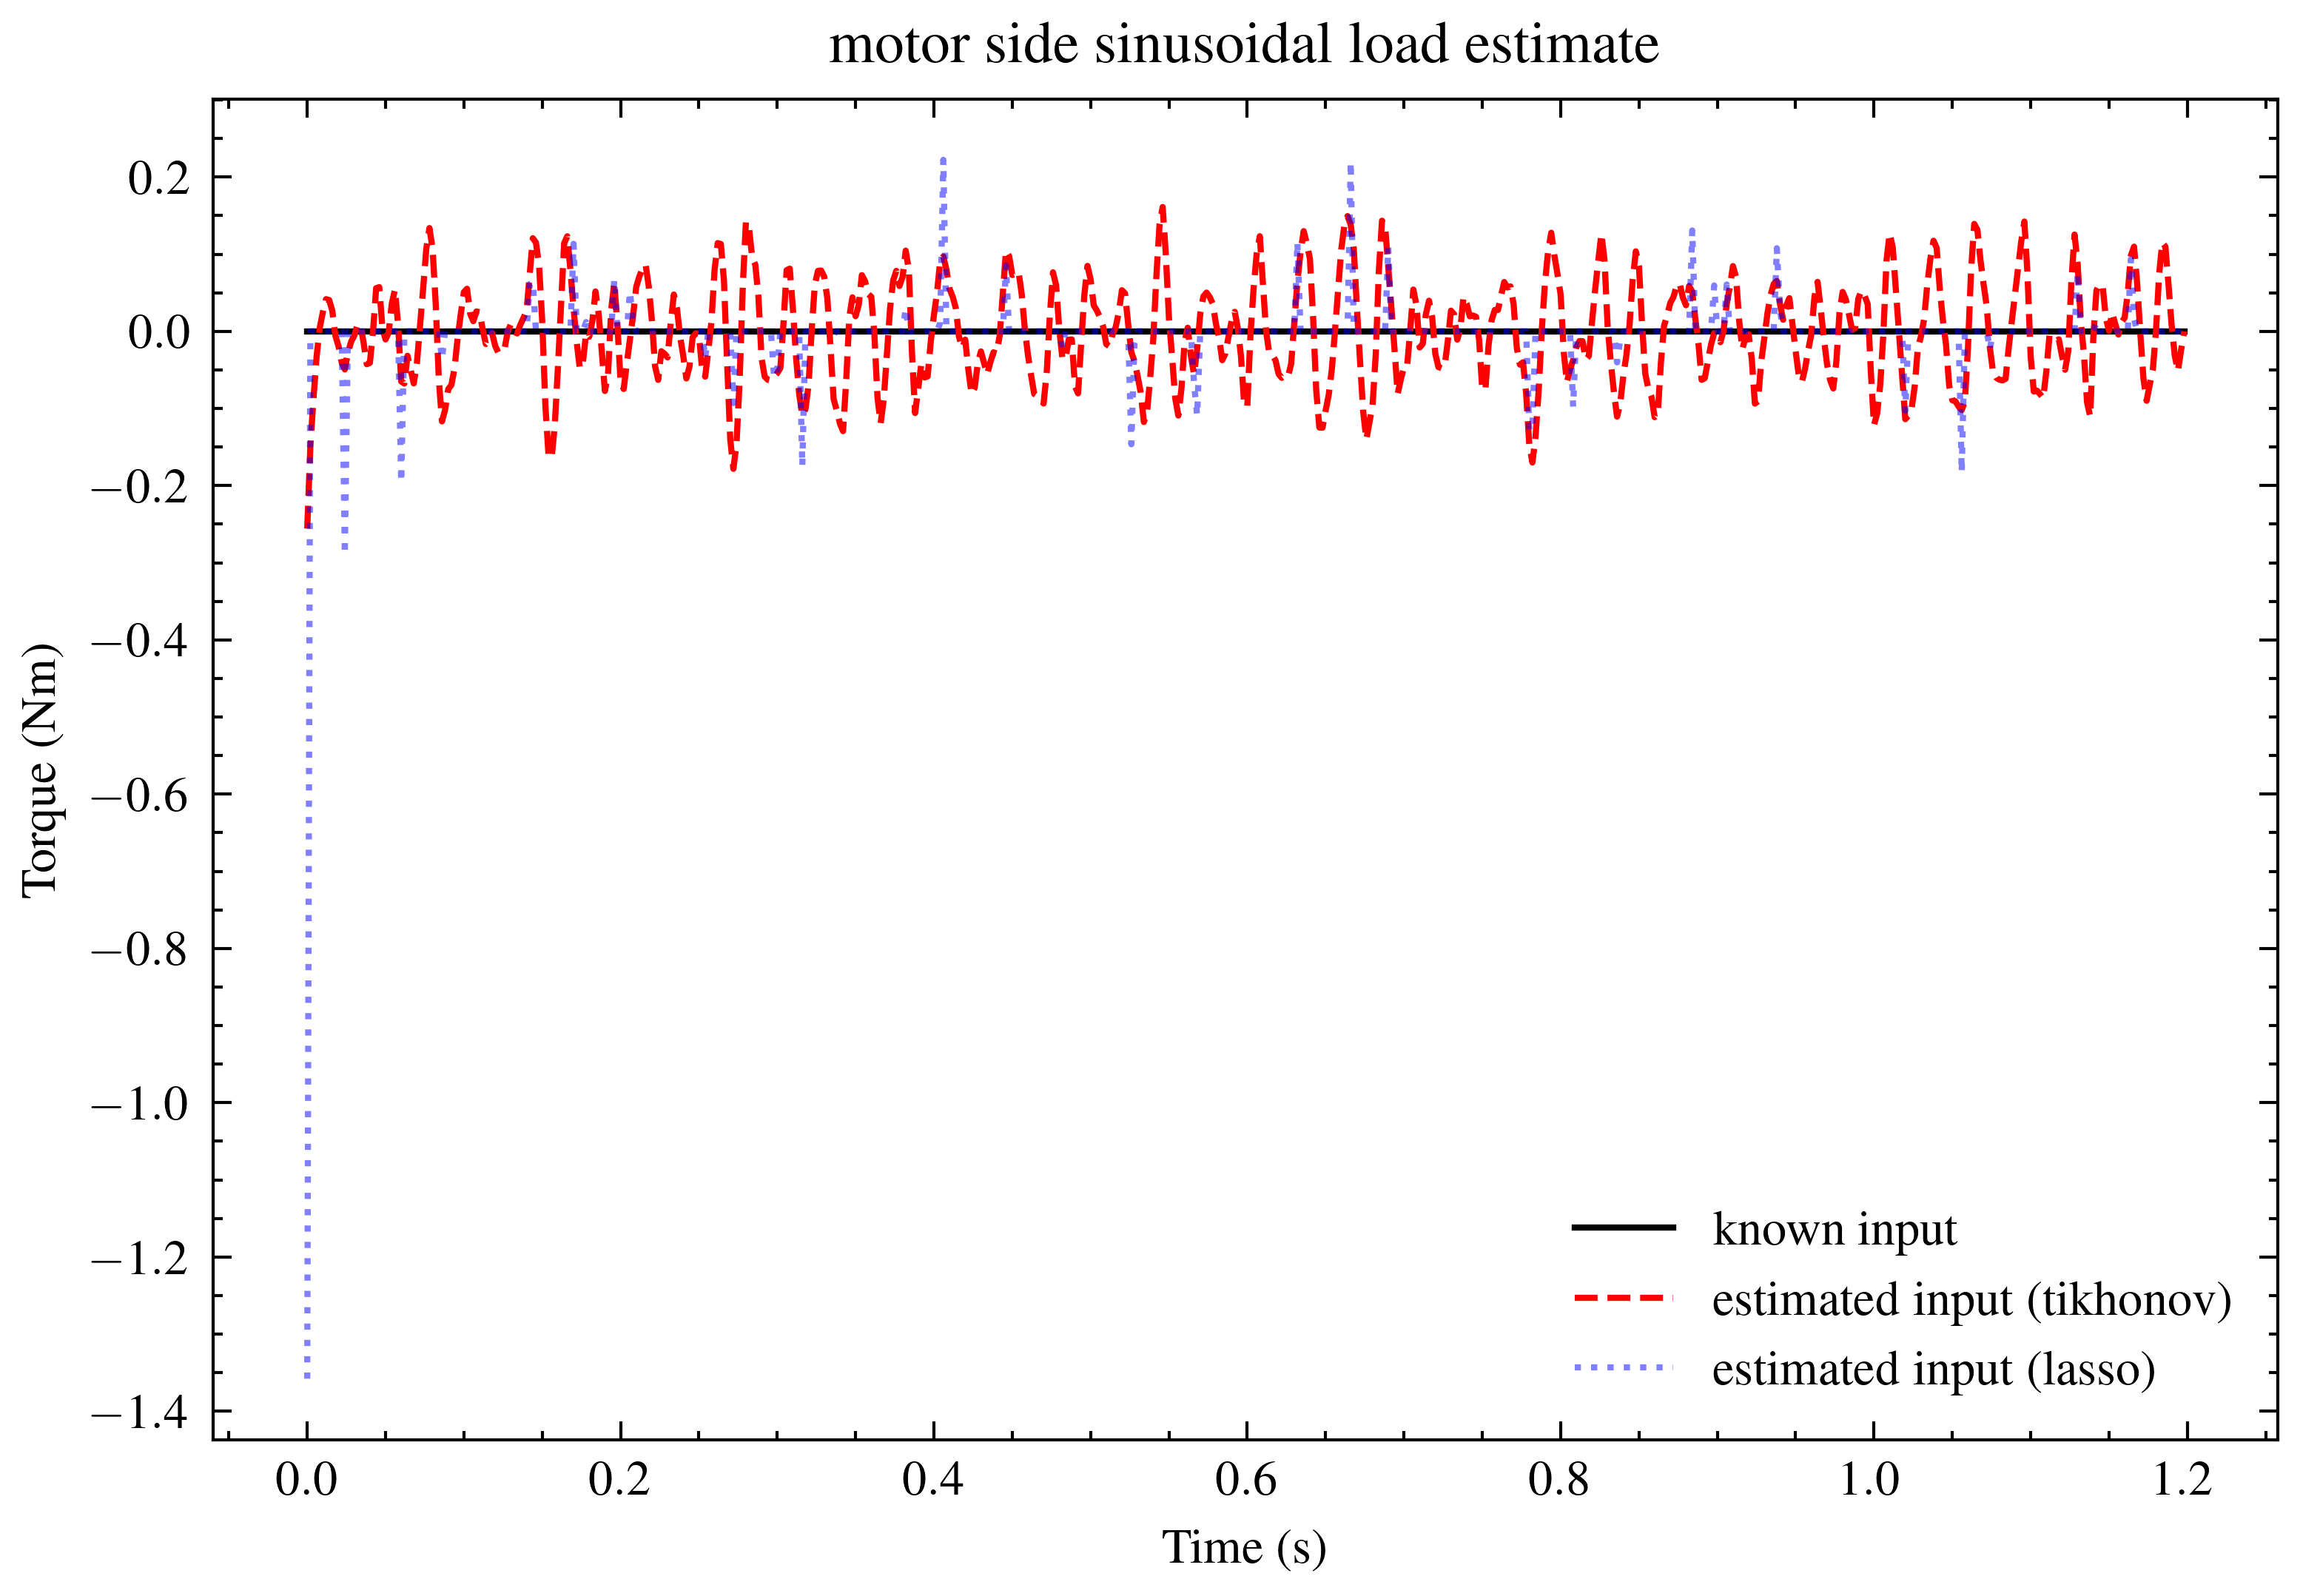

In [34]:
plt.plot(t, sin_ex_reshaped[::2], label='known input')
plt.plot(t, u_hat_sin[::2], label='estimated input (tikhonov)')
plt.plot(t, u_hat_l_sin[::2], label='estimated input (lasso)', alpha=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('motor side sinusoidal load estimate')
plt.show()

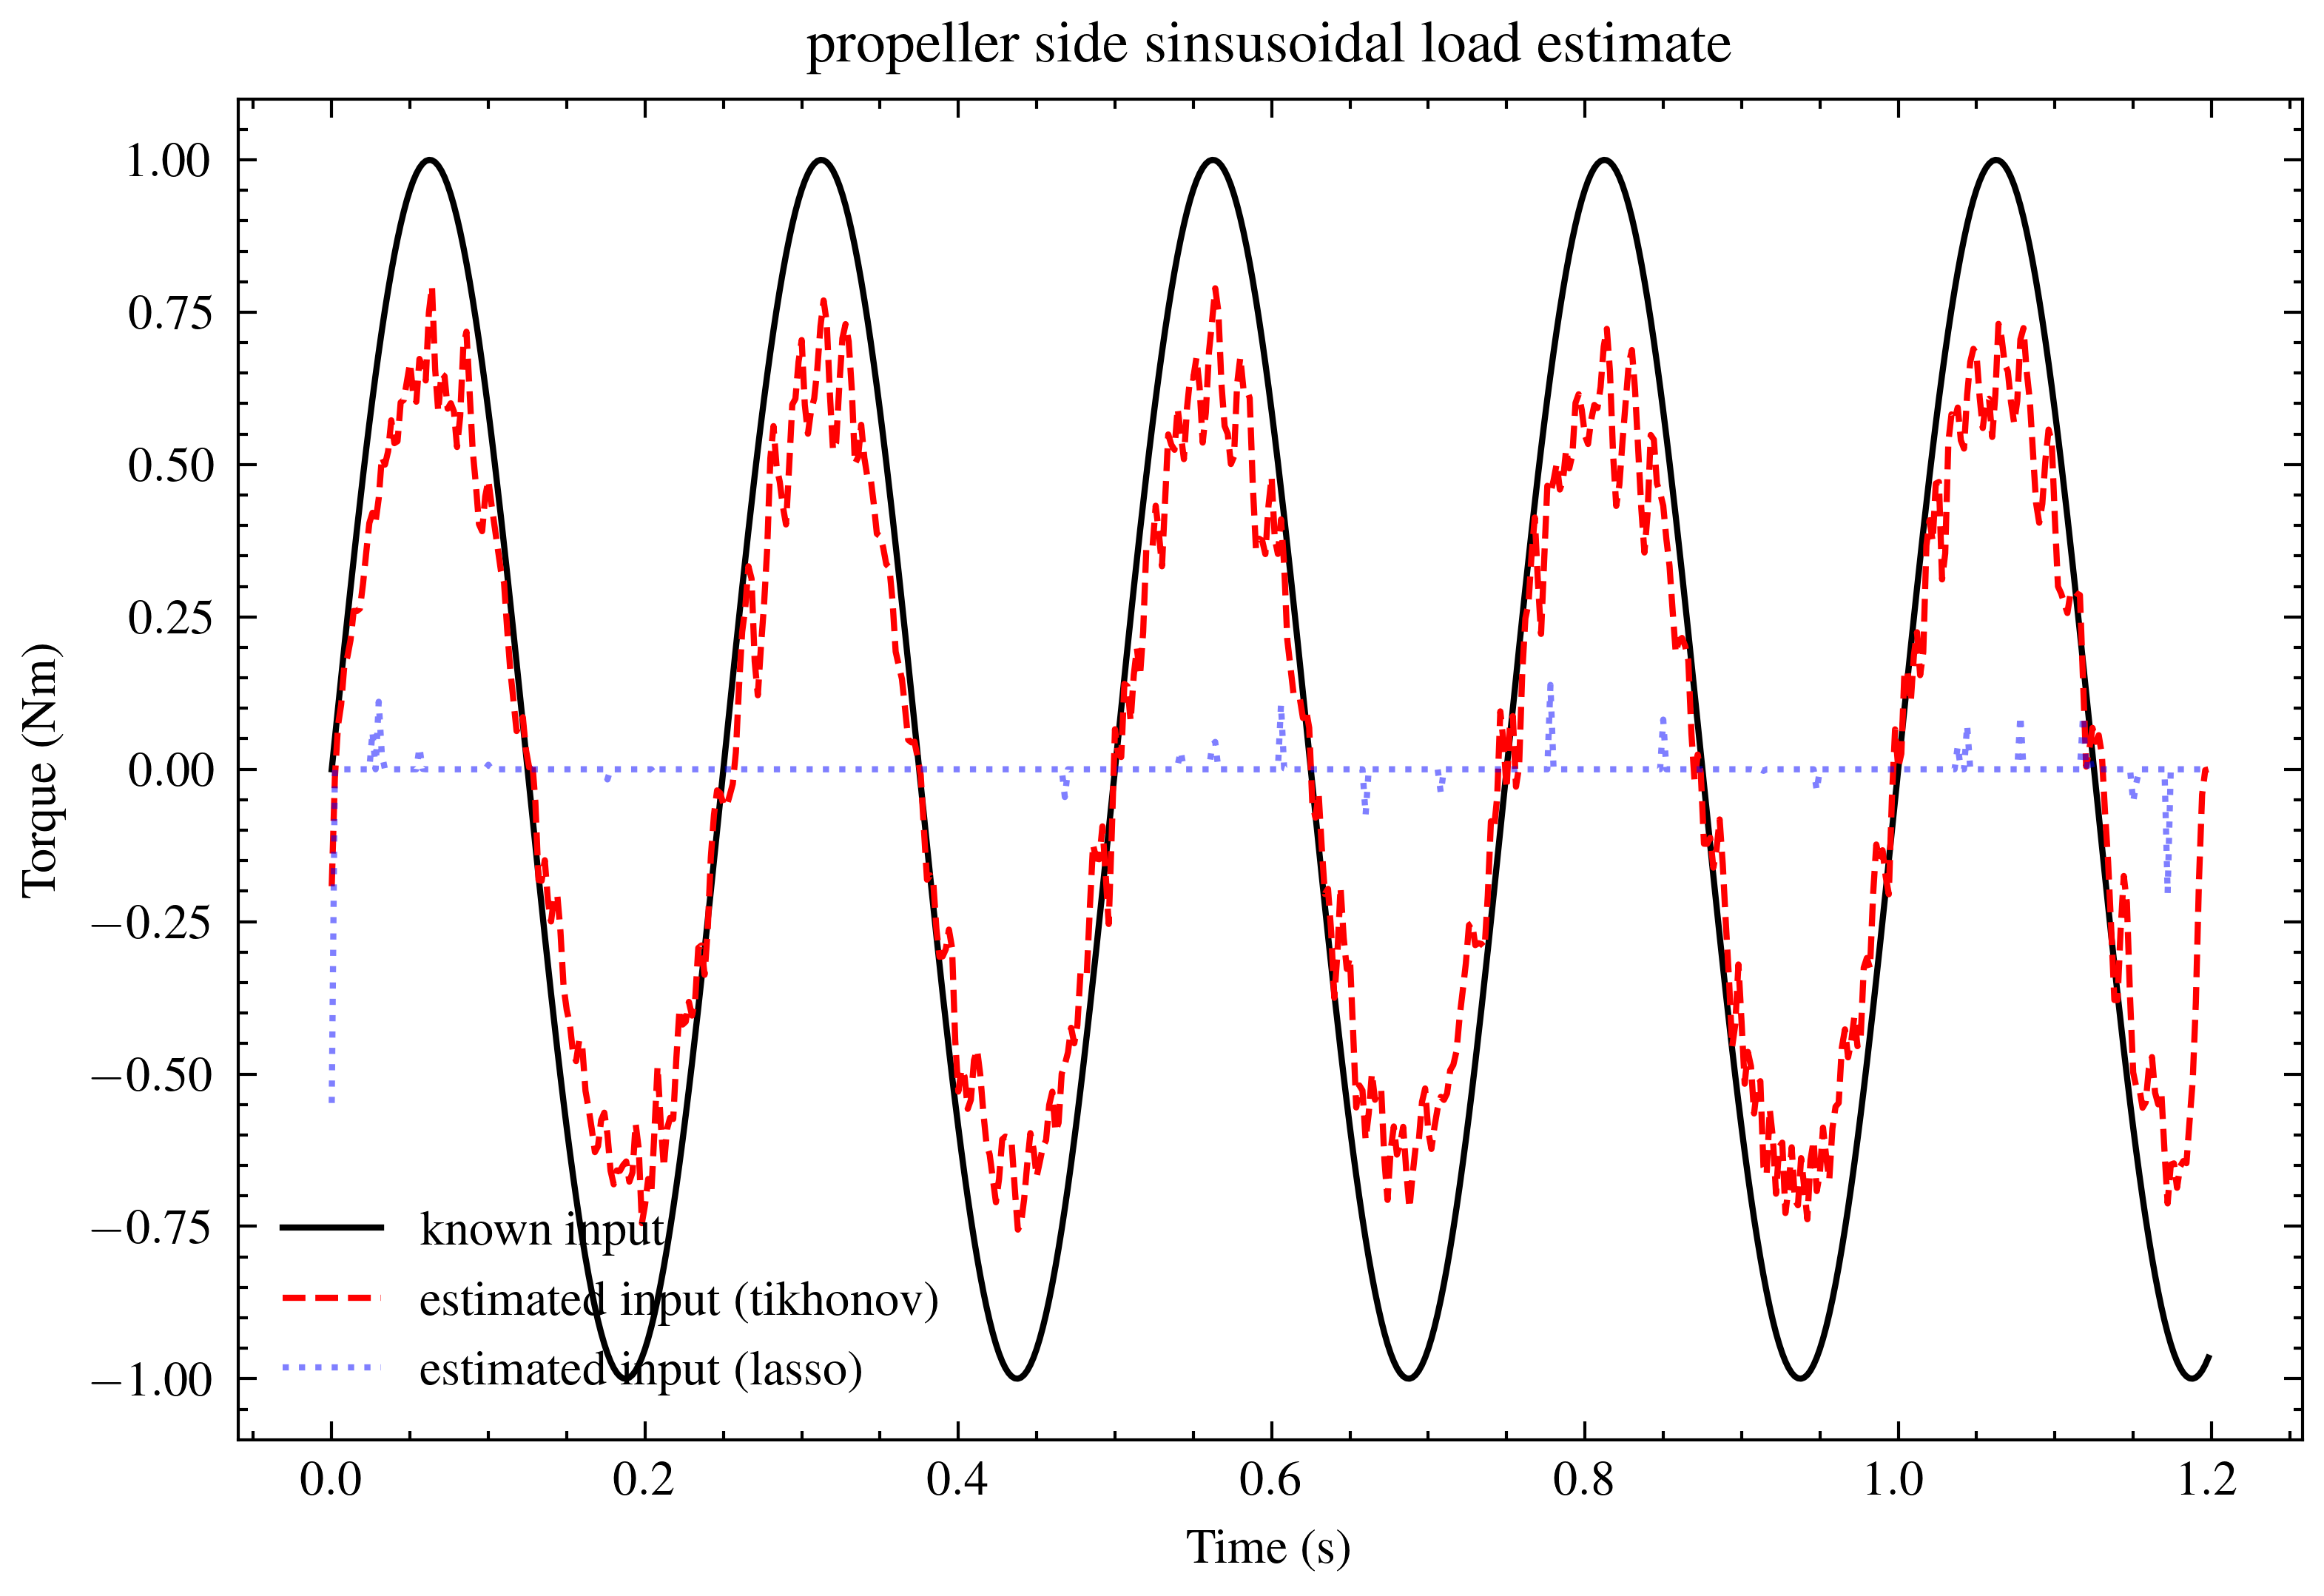

In [35]:
plt.plot(t, sin_ex_reshaped[1::2], label='known input')
plt.plot(t, u_hat_sin[1::2], label='estimated input (tikhonov)')
plt.plot(t, u_hat_l_sin[1::2], label='estimated input (lasso)', alpha=0.5)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('propeller side sinsusoidal load estimate')
plt.show()

# Hodrick-Prescott trend filtering

## Impulse load

In [36]:
D2_test = second_difference_matrix(N, m)

u_hat_hp, x_hat_hp = tikhonov_problem(noisy_meas, O_test, G_test, D2_test, initial_state=x0, lam=0.01)
u_hat_l_hp, x_hat_l_hp = lasso_problem(noisy_meas, O_test, G_test, D2_test, initial_state=x0, lam=0.05)

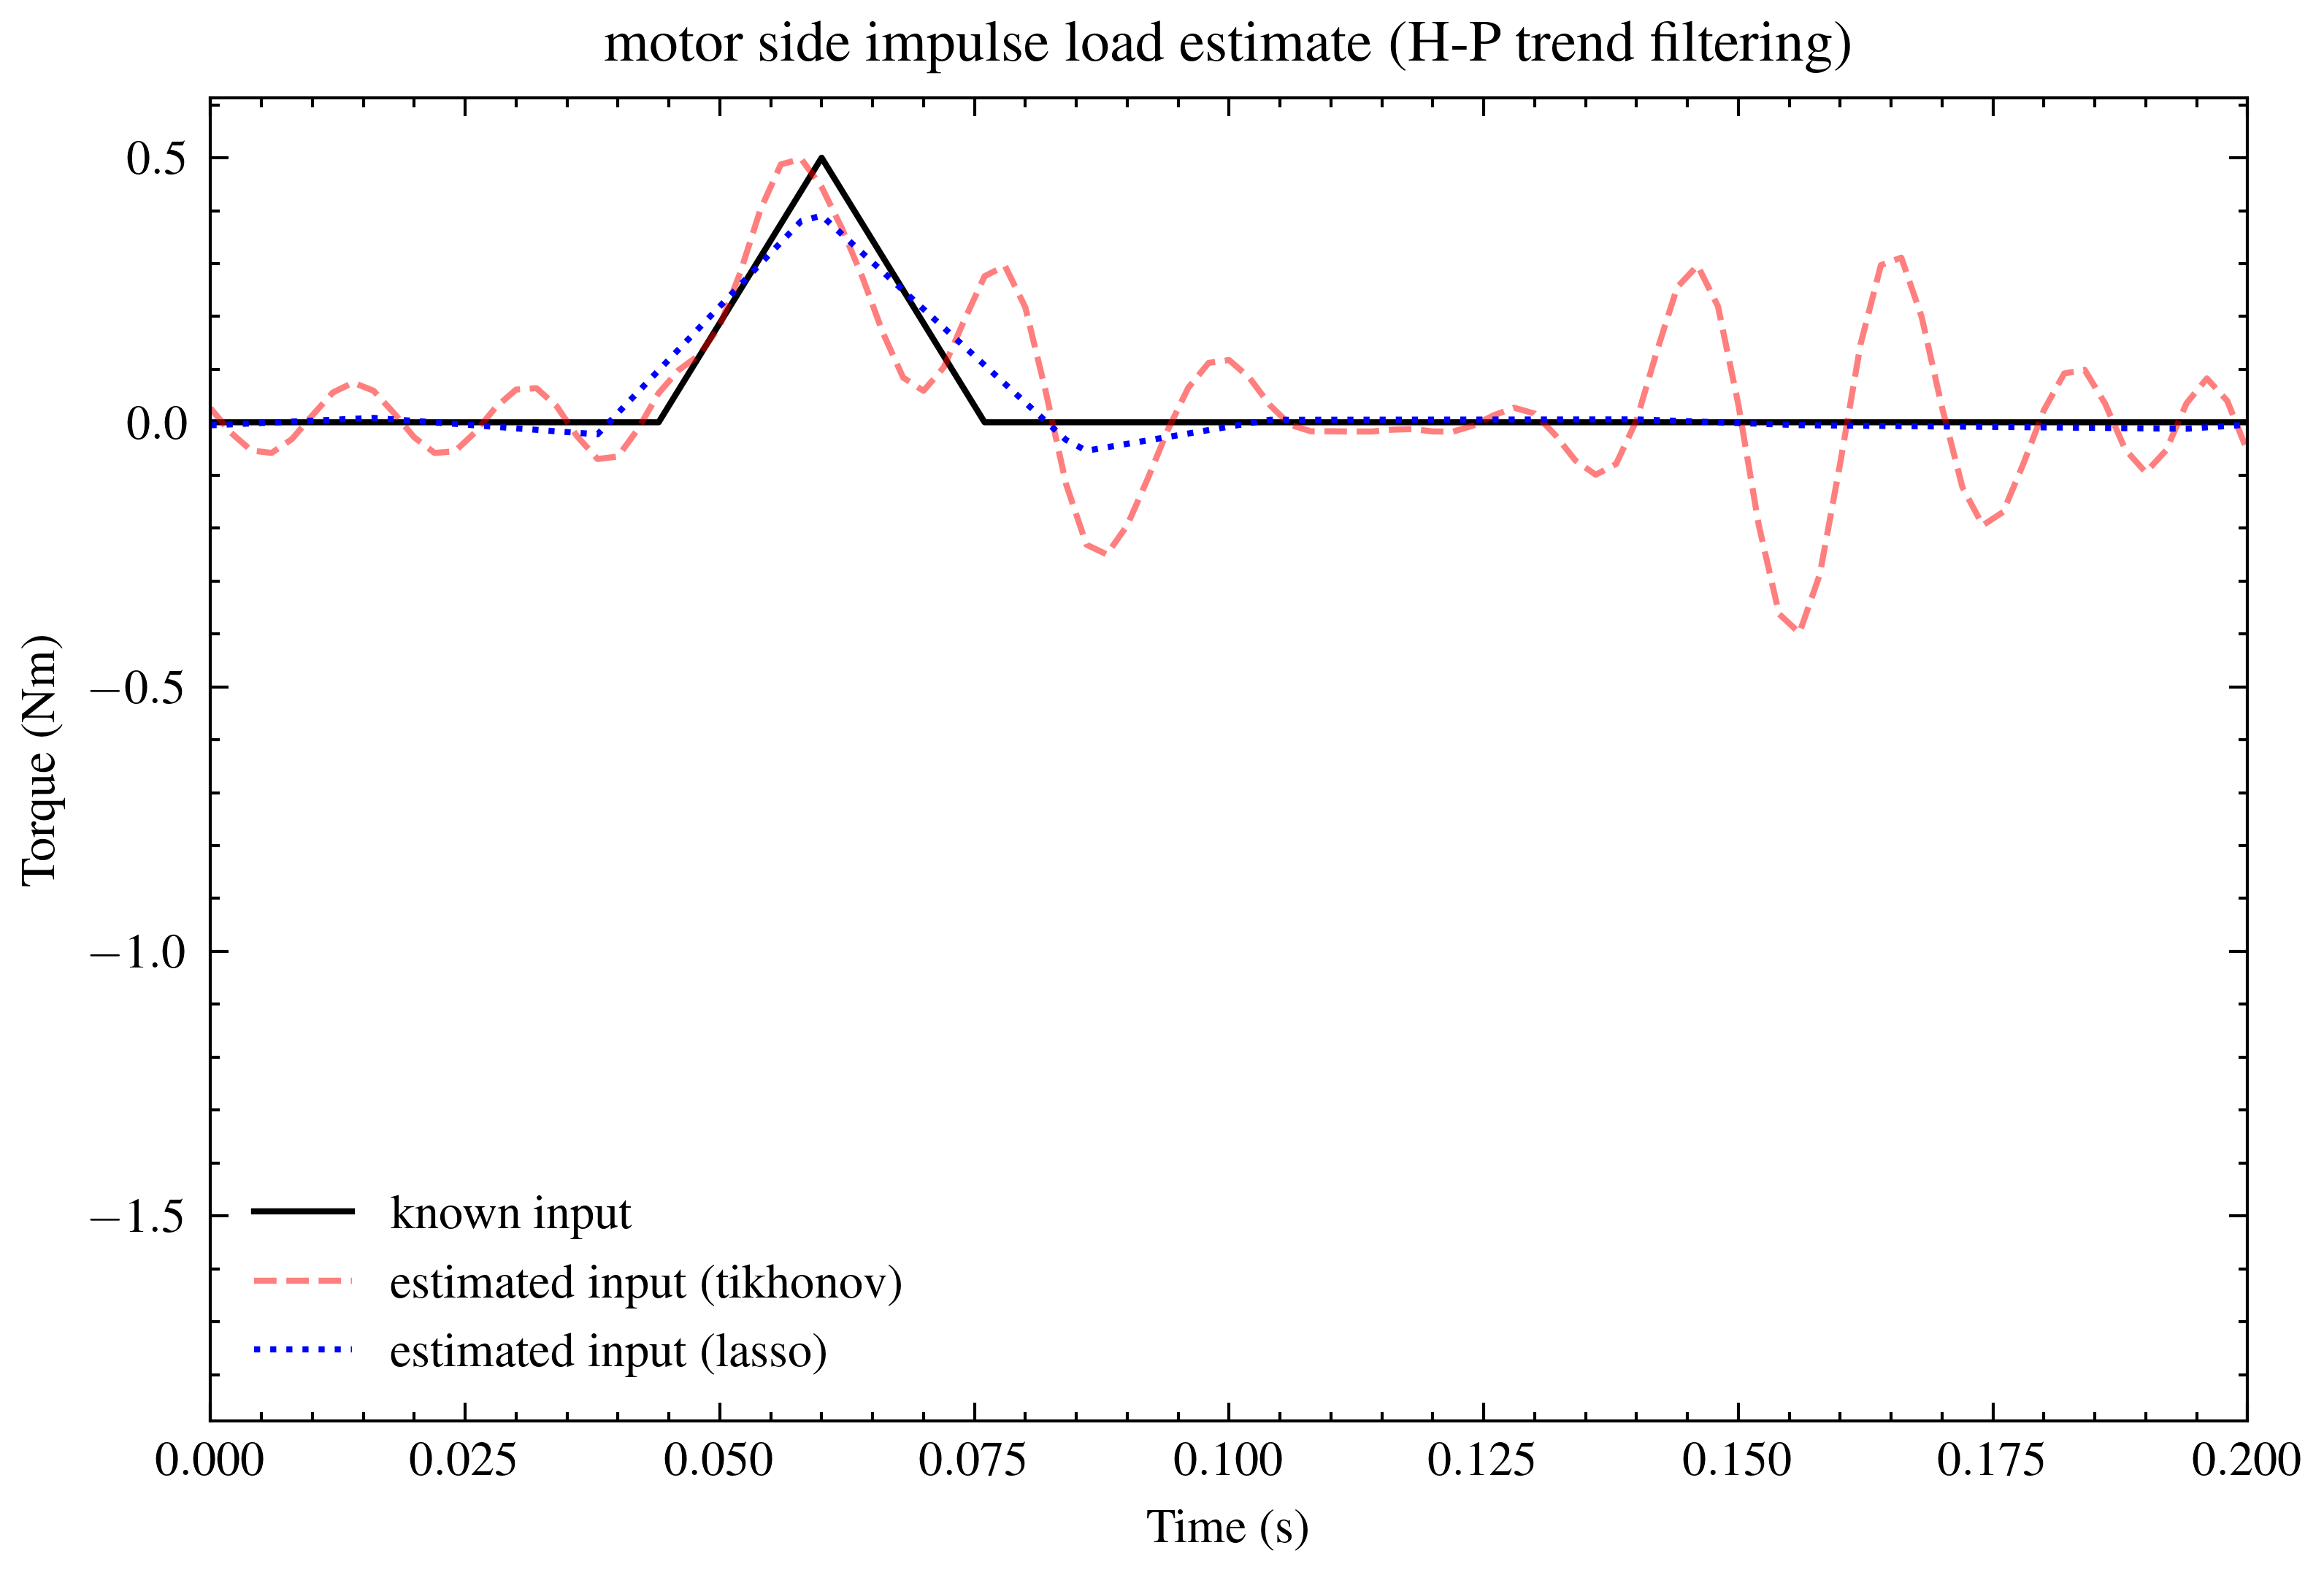

In [37]:
plt.plot(t, impulse_ex_reshaped[::2], label='known input')
plt.plot(t, u_hat_hp[::2], label='estimated input (tikhonov)', alpha=0.5)
plt.plot(t, u_hat_l_hp[::2], label='estimated input (lasso)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.xlim(0,0.2)
plt.title('motor side impulse load estimate (H-P trend filtering)')
plt.show()

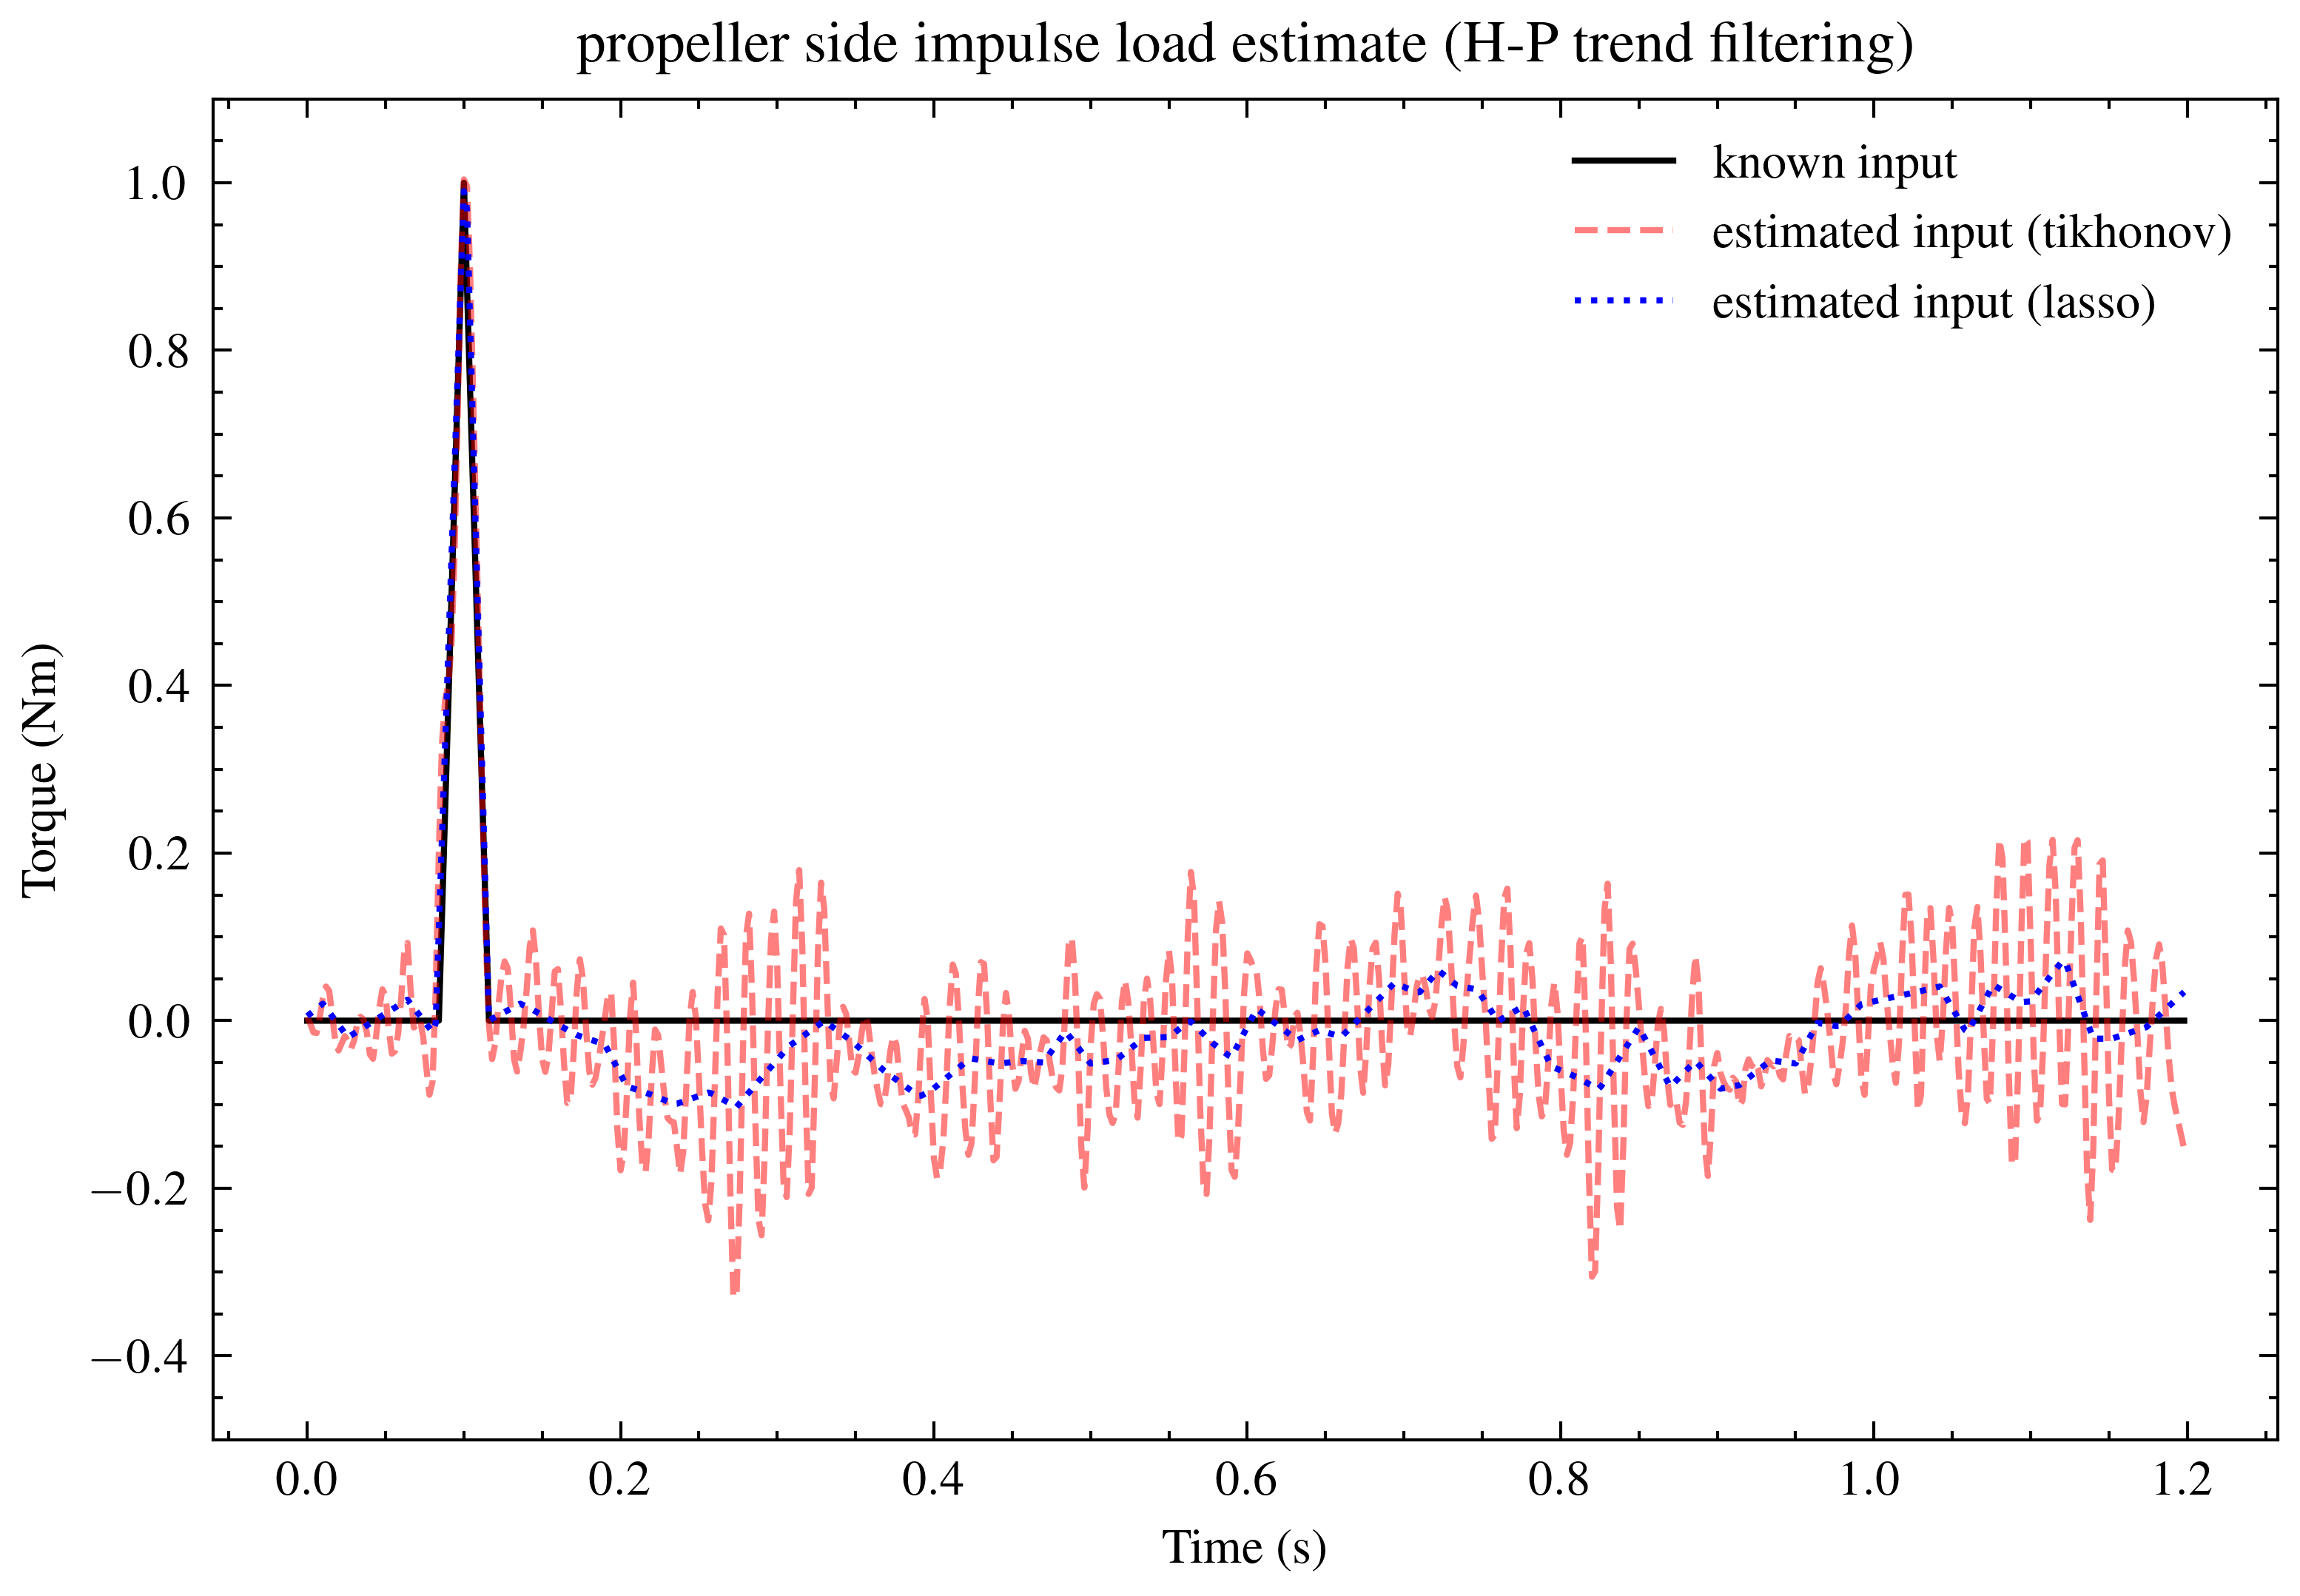

In [38]:
plt.plot(t, impulse_ex_reshaped[1::2], label='known input')
plt.plot(t, u_hat_hp[1::2], label='estimated input (tikhonov)', alpha=0.5)
plt.plot(t, u_hat_l_hp[1::2], label='estimated input (lasso)')
plt.ylim(-0.5, 1.1)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('propeller side impulse load estimate (H-P trend filtering)')
plt.show()

In [39]:
u_hat_hp_sin, x_hat_hp_sin = tikhonov_problem(noisy_meas_sin, O_test, G_test, D2_test, initial_state=x0, lam=0.01)
u_hat_l_hp_sin, x_hat_l_hp_sin = lasso_problem(noisy_meas_sin, O_test, G_test, D2_test, initial_state=x0, lam=0.05)

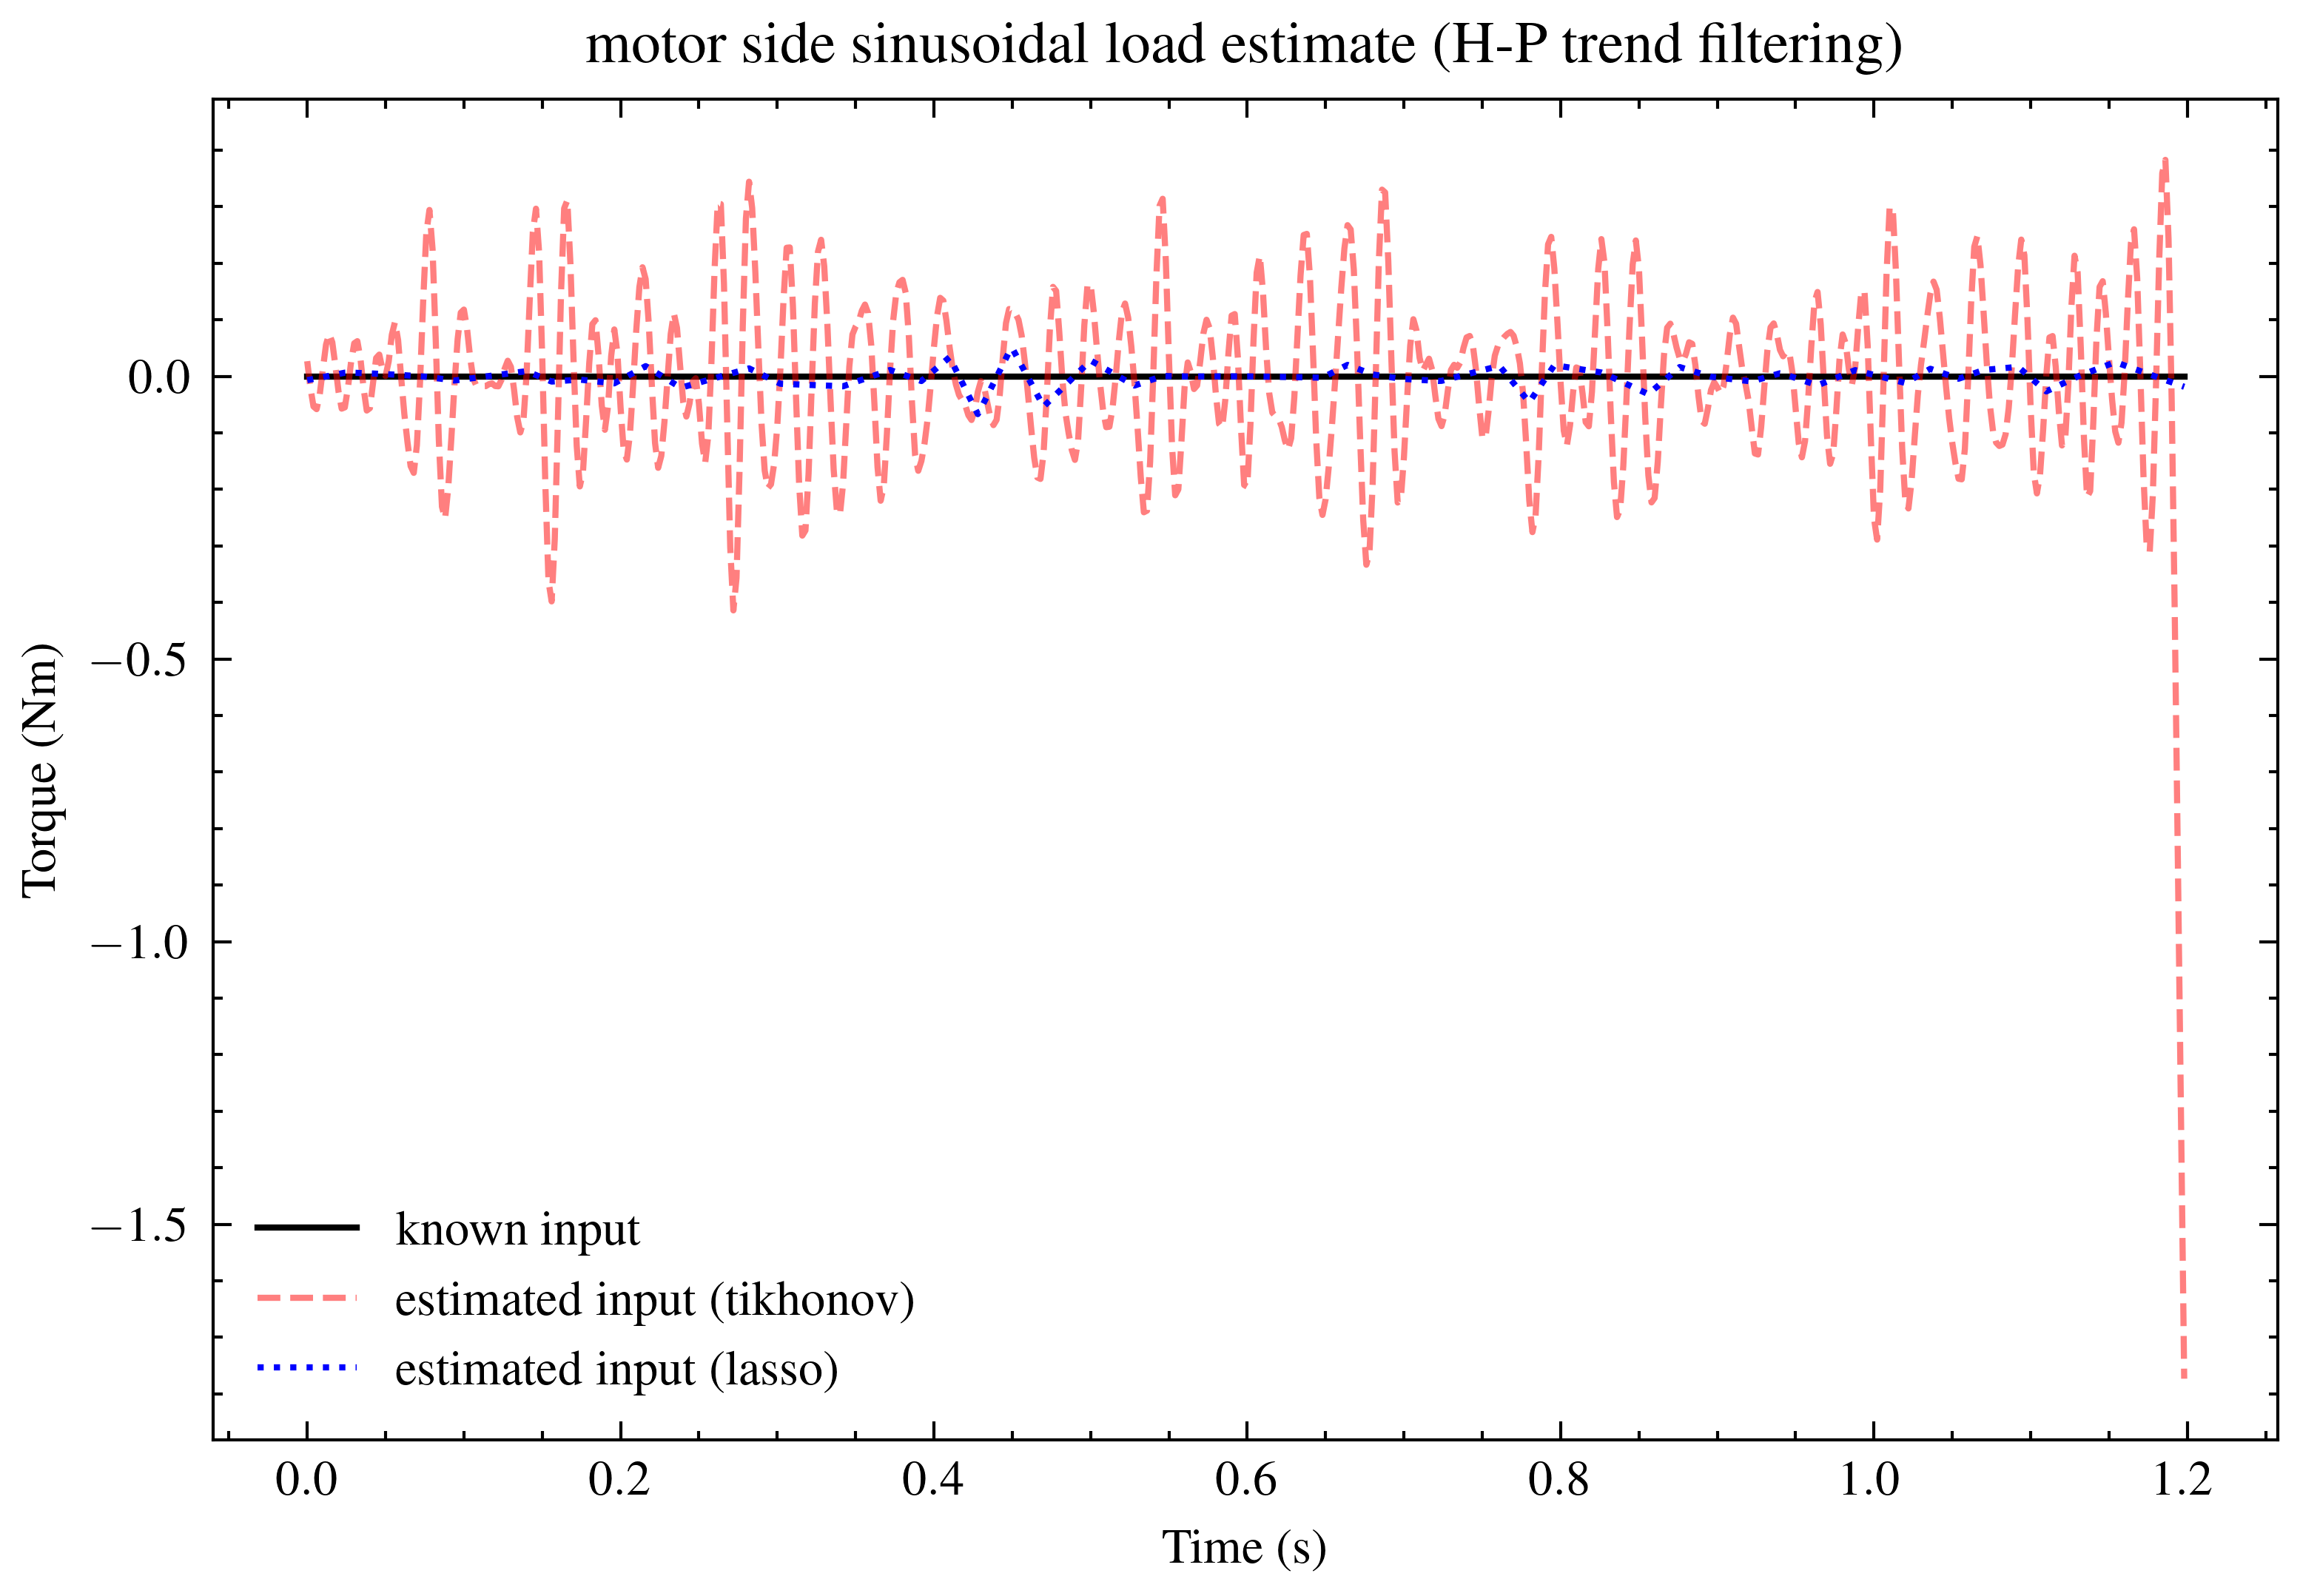

In [40]:
plt.plot(t, sin_ex_reshaped[::2], label='known input')
plt.plot(t, u_hat_hp_sin[::2], label='estimated input (tikhonov)', alpha=0.5)
plt.plot(t, u_hat_l_hp_sin[::2], label='estimated input (lasso)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('motor side sinusoidal load estimate (H-P trend filtering)')
plt.show()

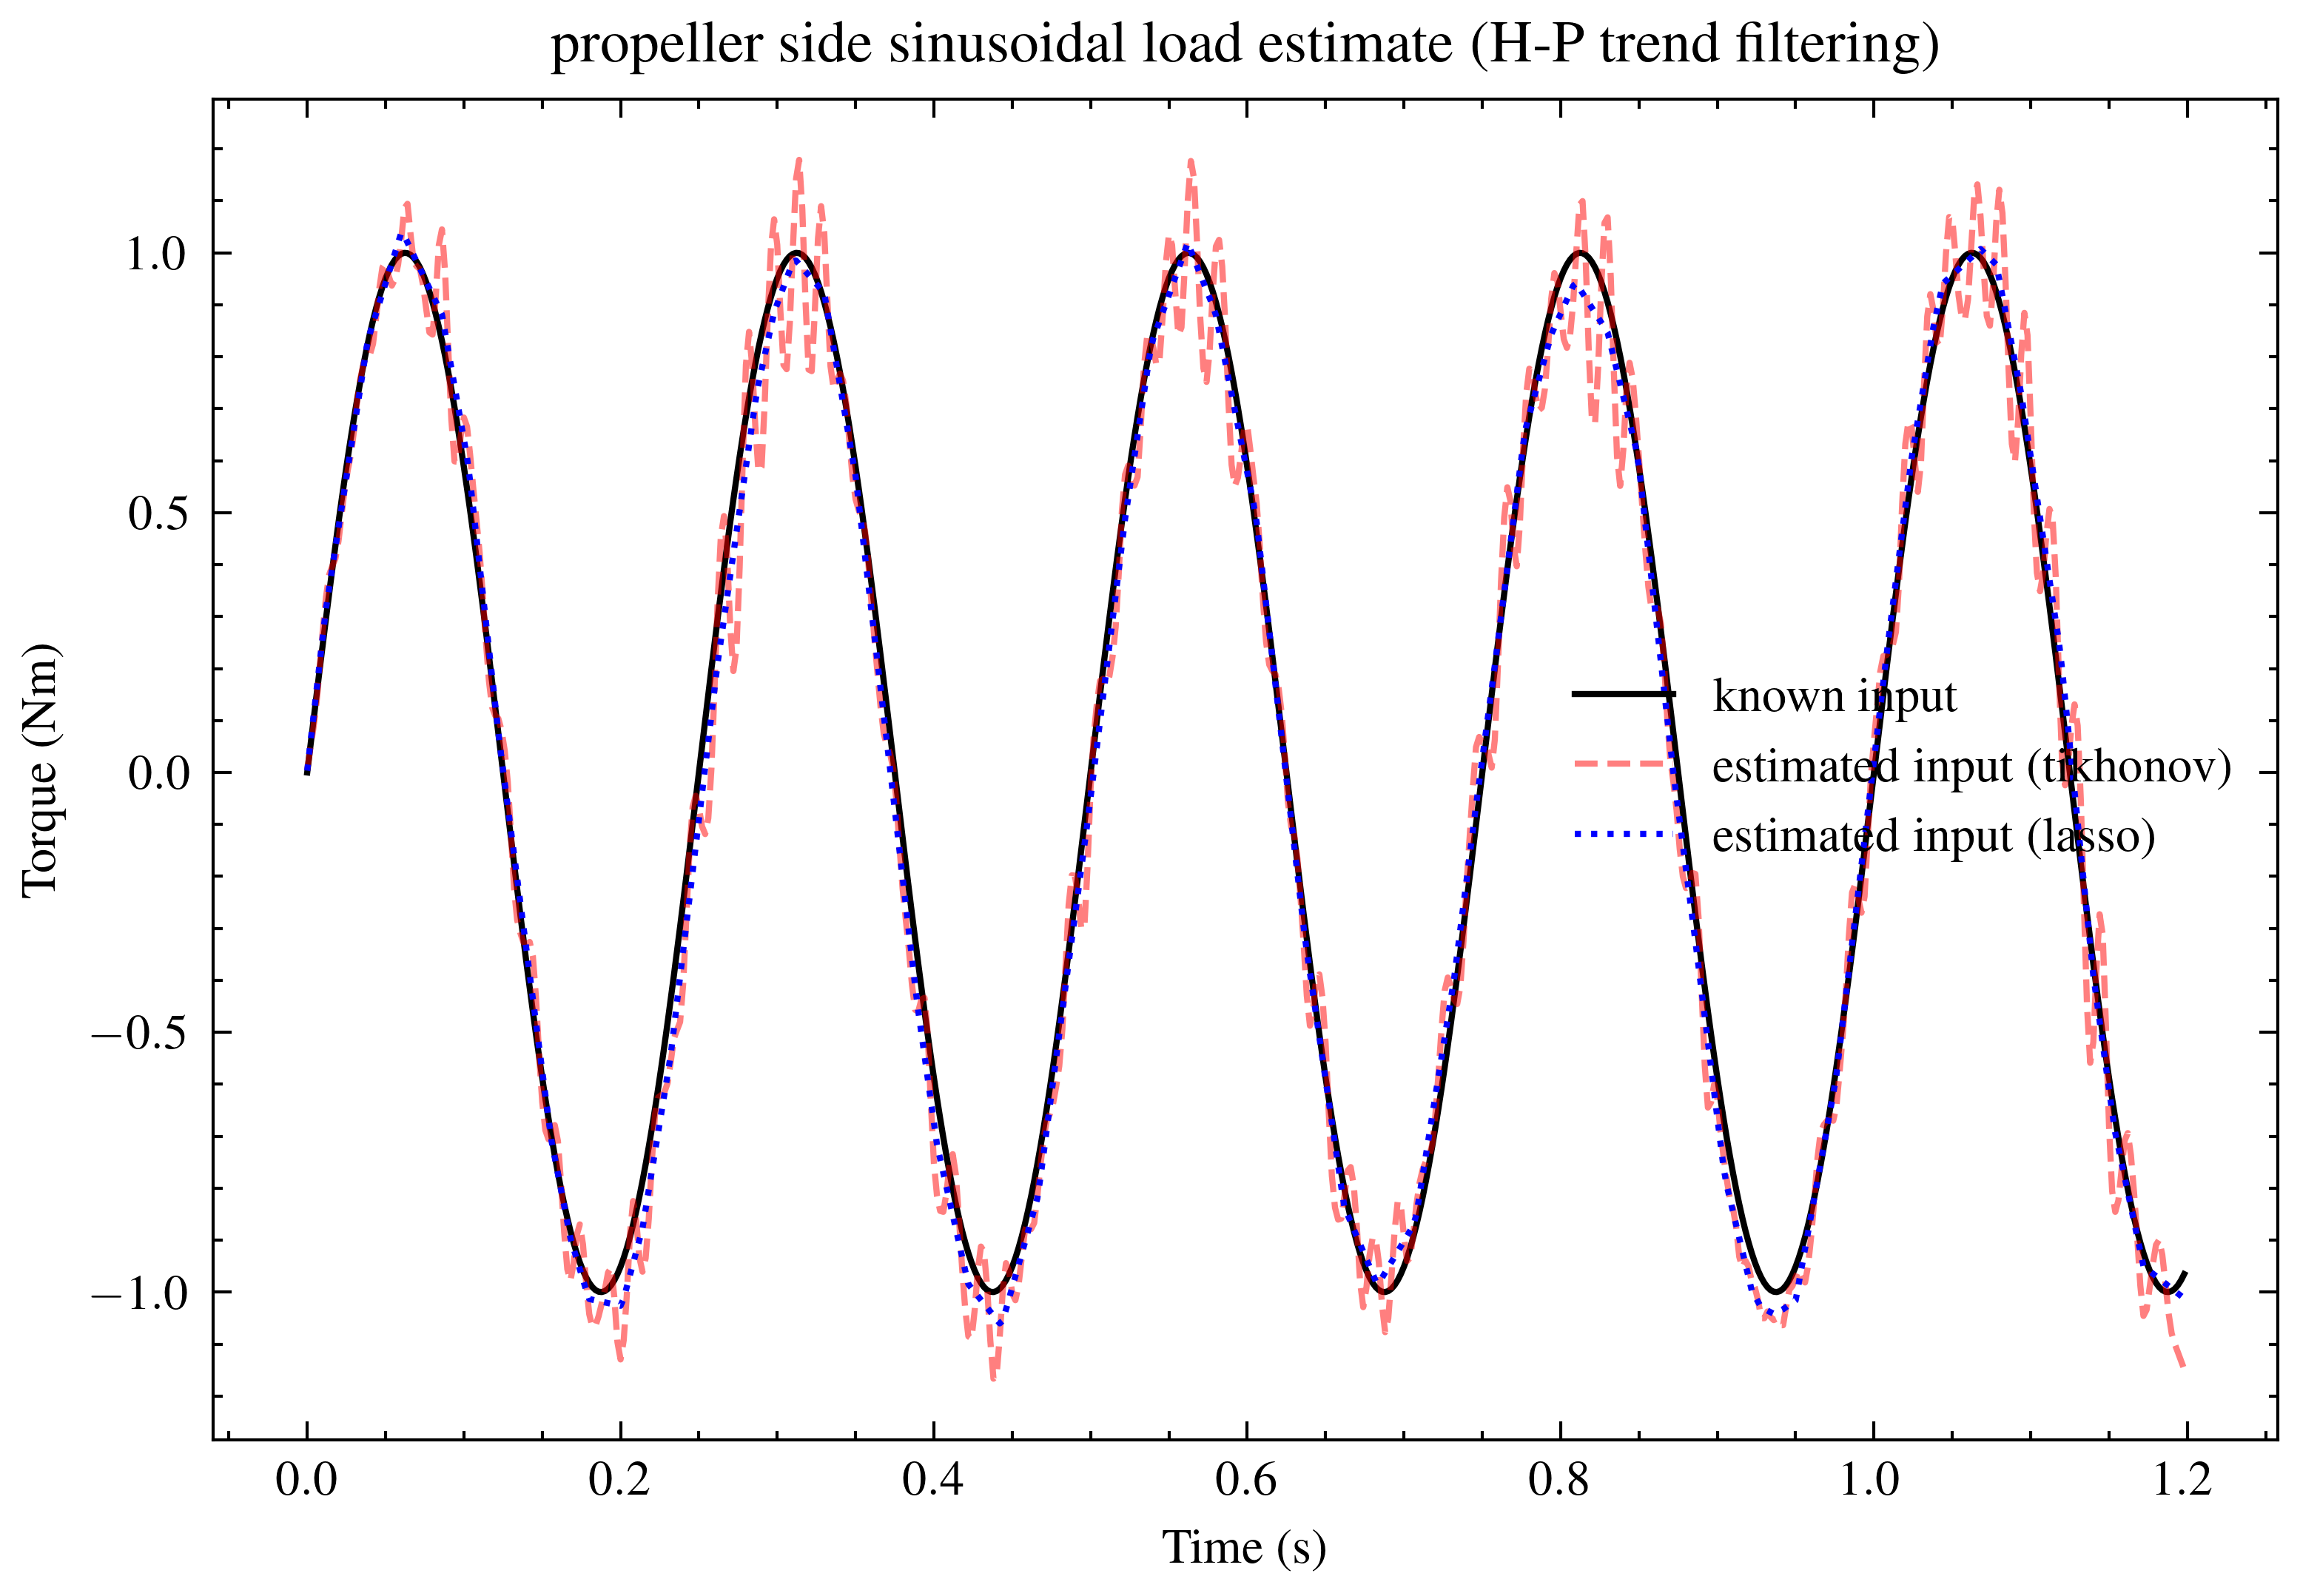

In [41]:
plt.plot(t, sin_ex_reshaped[1::2], label='known input')
plt.plot(t, u_hat_hp_sin[1::2], label='estimated input (tikhonov)', alpha=0.5)
plt.plot(t, u_hat_l_hp_sin[1::2], label='estimated input (lasso)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('propeller side sinusoidal load estimate (H-P trend filtering)')
plt.show()

# Simulated experiment

In [42]:
sim_time = np.arange(0, 10, 0.001)
dst = np.mean(np.diff(sim_time))
en = len(sim_time)
em = B_mat_d.shape[1]

U = np.zeros((len(sim_time), 2))

e1 = np.random.normal(0, .01, U.shape[0])
e2 = np.random.normal(0, .01, U.shape[0])

U[:,0] += 5 + e1
U[:,1] -= 2 + np.sin(5*2*np.pi*sim_time) + e2

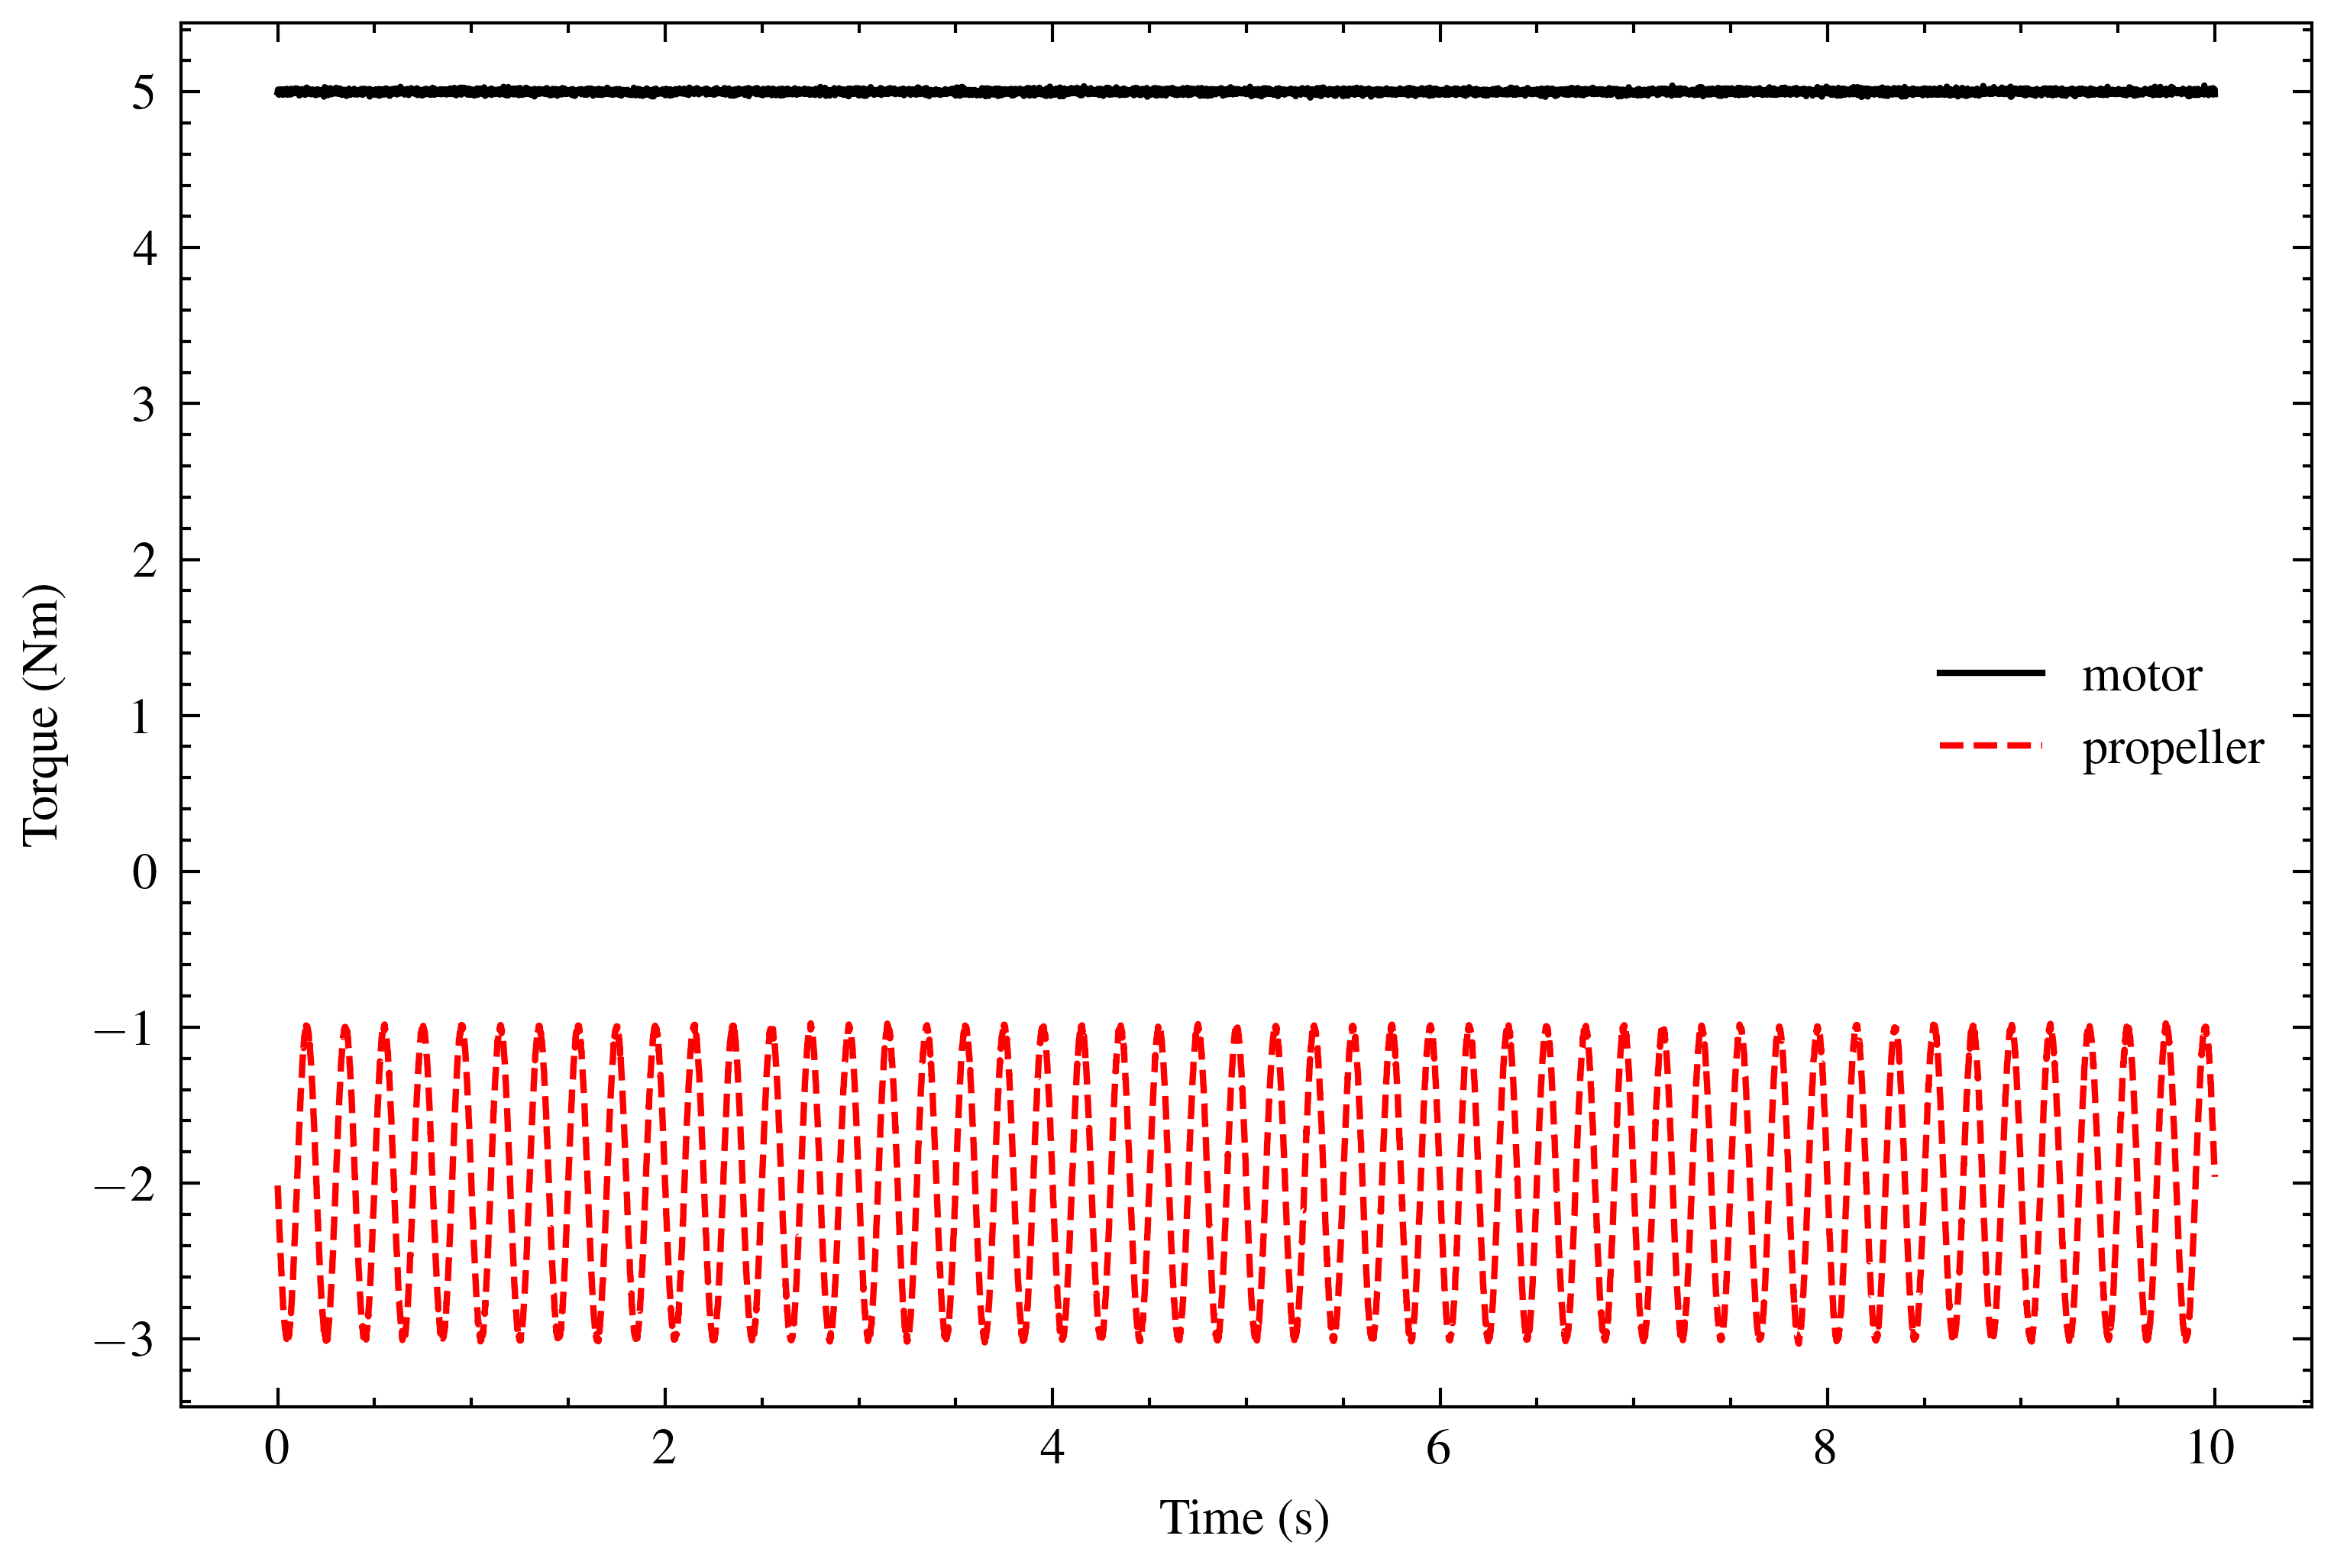

In [43]:
plt.plot(sim_time, U, label=('motor', 'propeller'))
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.show()

In [44]:
time_meas, measurements, _ = dlsim((A_mat_d, B_mat_d, C_mat, D_mat, dst), U, t=sim_time)

In [45]:
measurement_error = np.random.normal(0, .02, measurements.shape[0]).reshape(-1,1)
measurements_noise = measurements + measurement_error

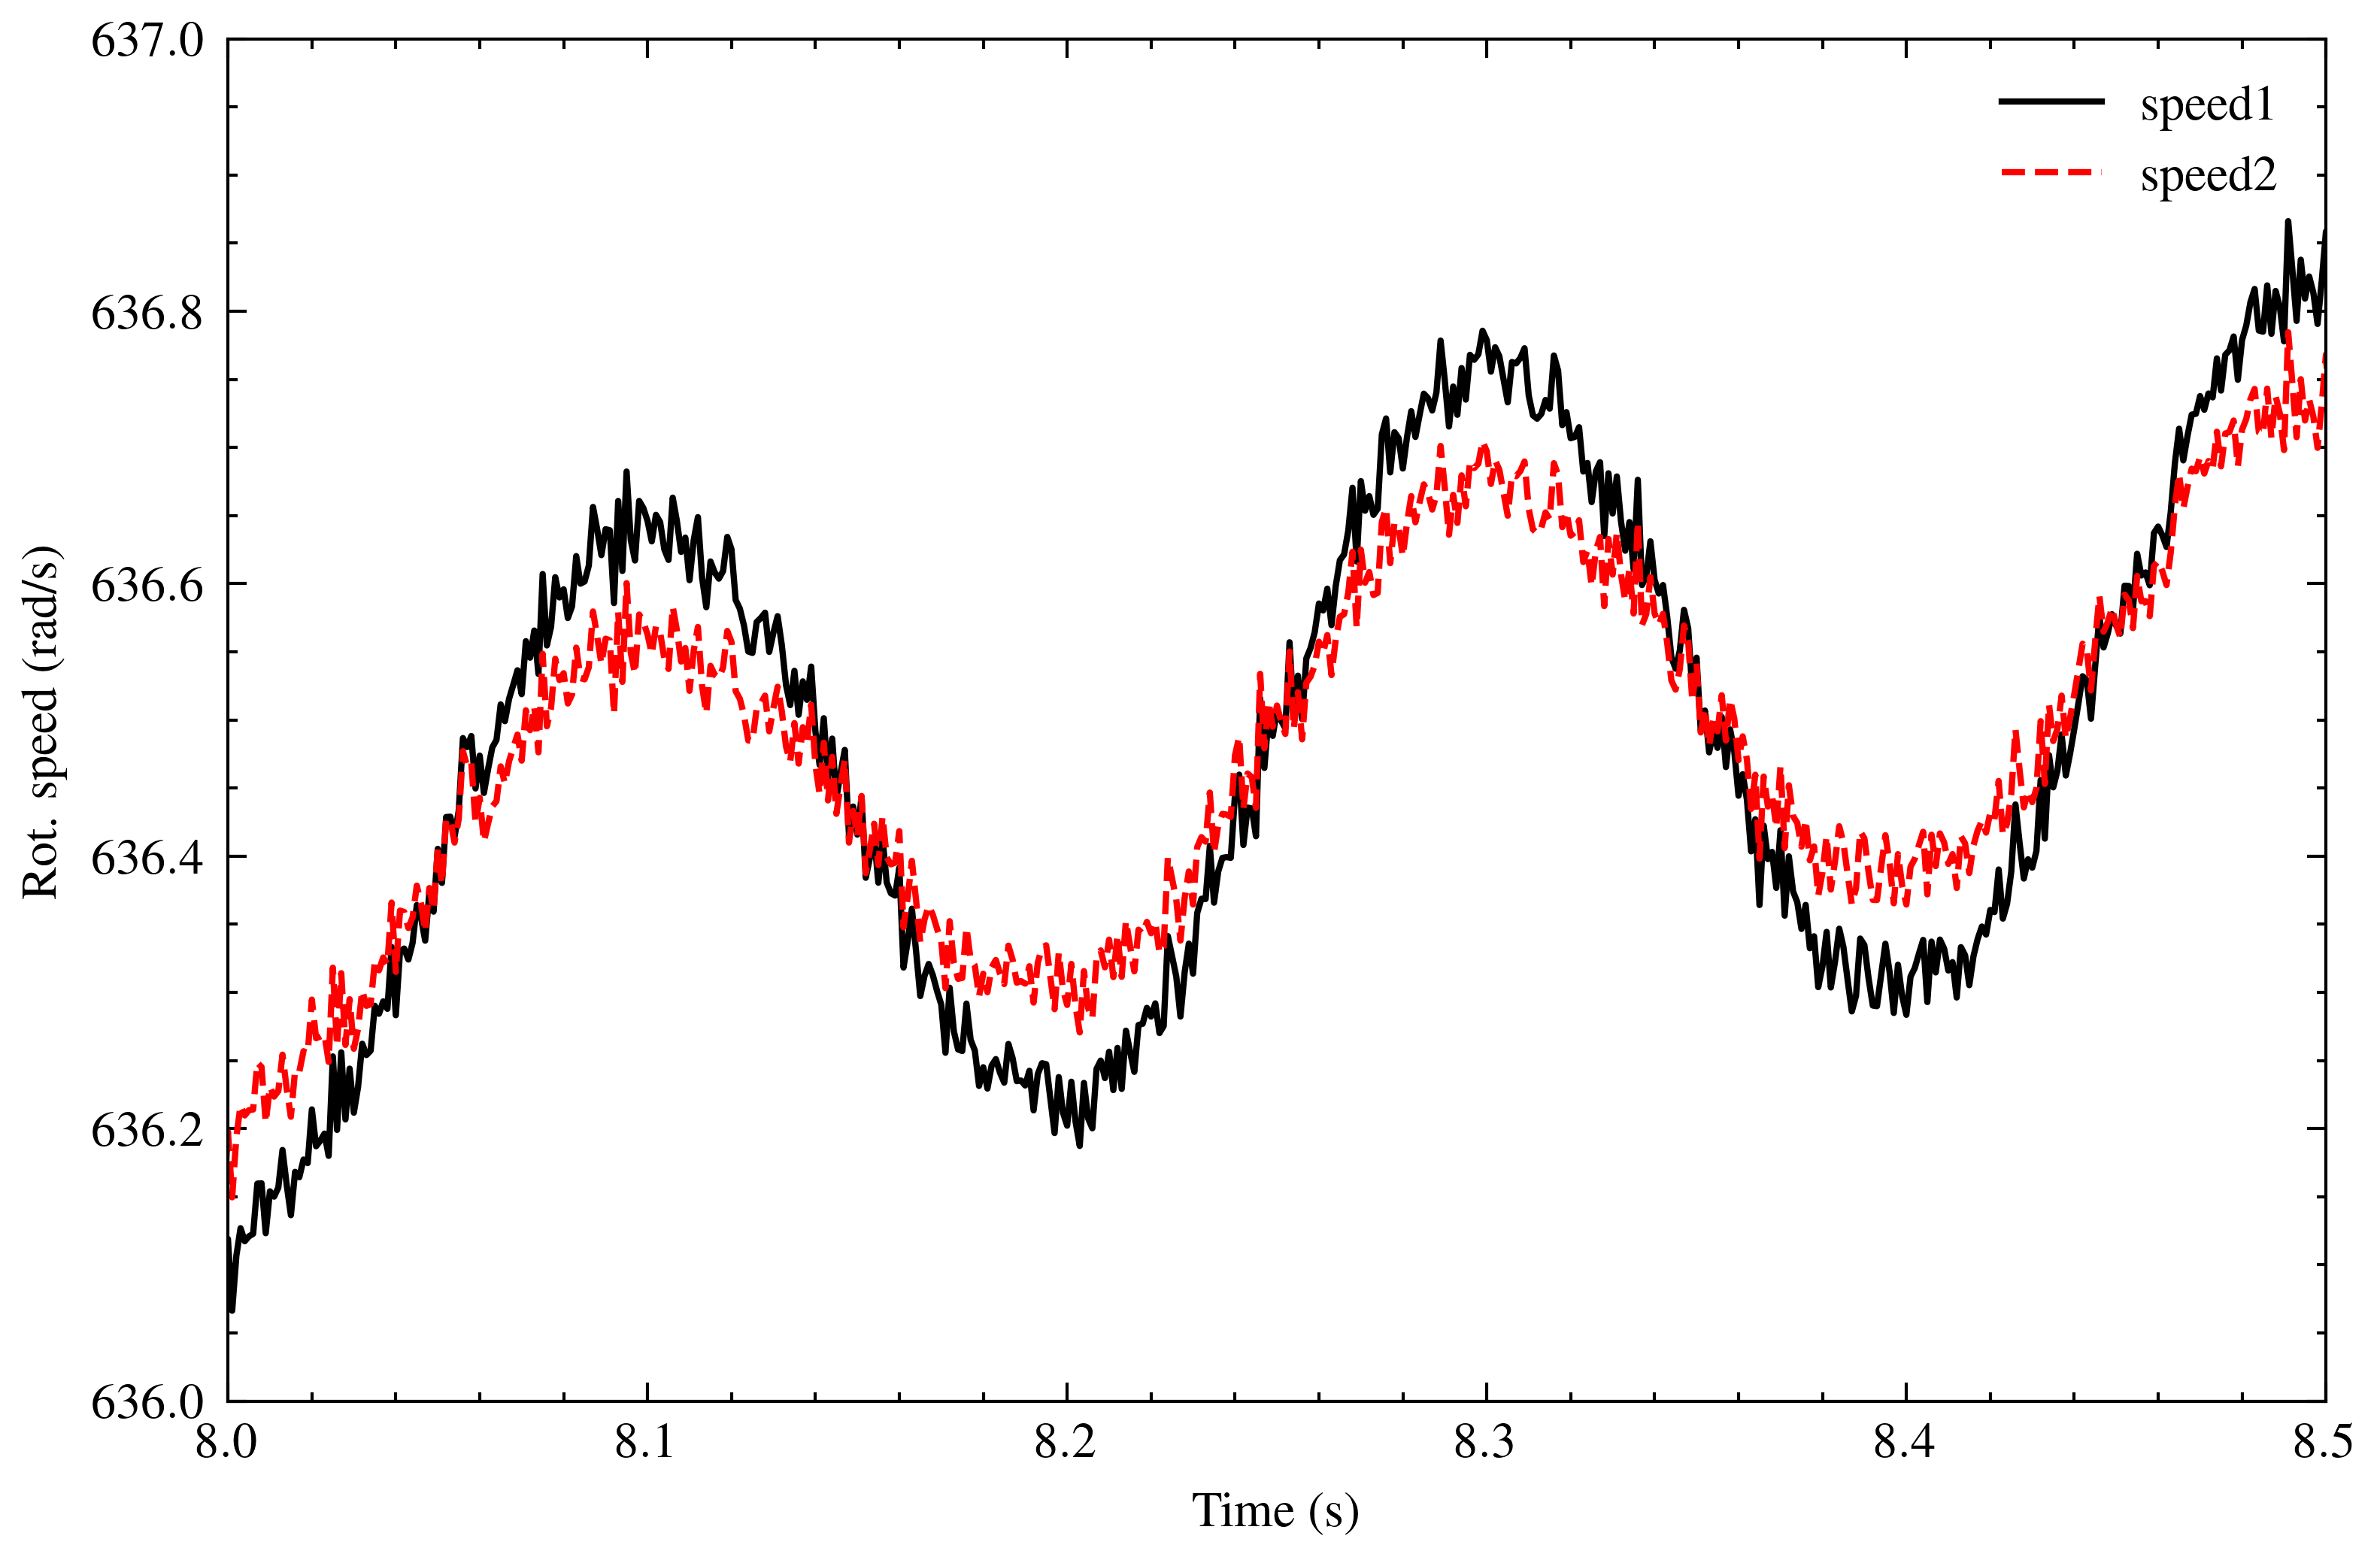

In [46]:
plt.plot(time_meas, measurements_noise[:,:-1], label=('speed1', 'speed2'))
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Rot. speed (rad/s)')
plt.ylim(636,637)
plt.xlim(8,8.5)
plt.show()

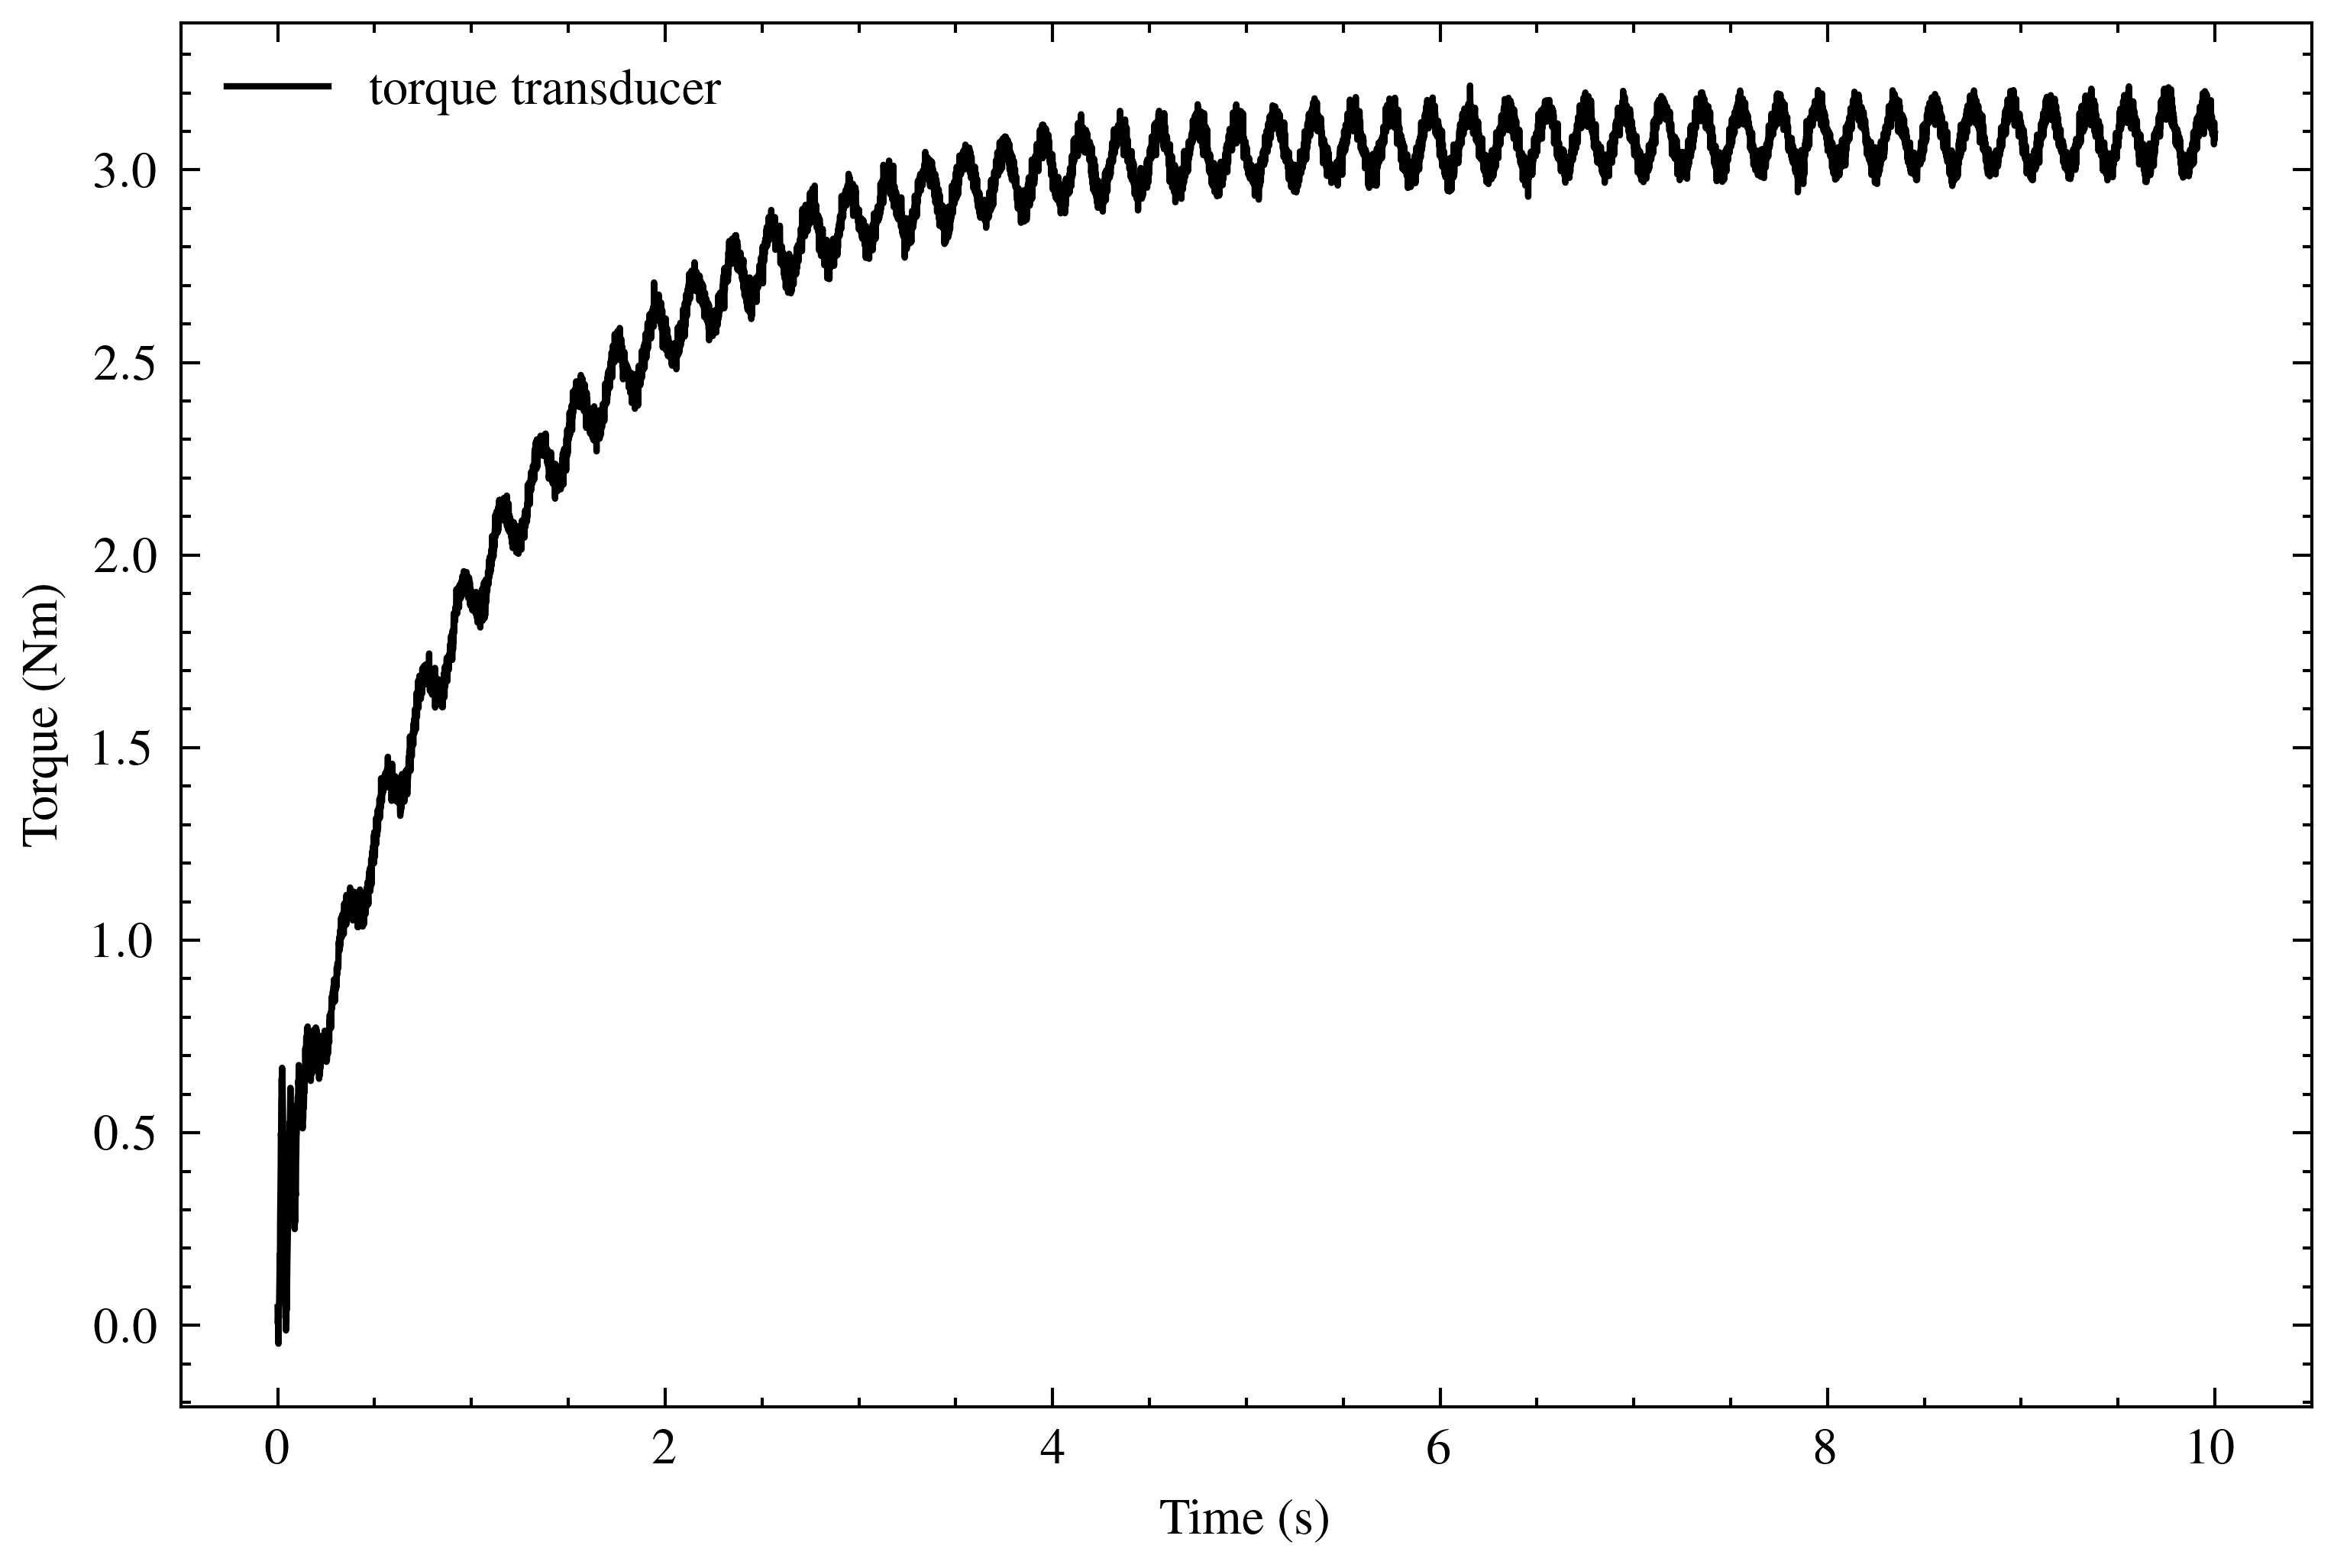

In [47]:
plt.plot(time_meas, measurements_noise[:,-1], label='torque transducer')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.show()

In [48]:
batch = measurements_noise[:1000,:]
en = batch.shape[0]
y_noise = batch.reshape(-1,1)
D2_mat = second_difference_matrix(en, em)
O_mat = O(A_mat_d, C_mat, en)
G_mat = gamma(A_mat_d, B_mat_d, C_mat, en) 

In [49]:
print(batch.shape)
print(y_noise.shape)

(1000, 3)
(3000, 1)


In [50]:
tikhonov_estimate, _ = tikhonov_problem(y_noise, O_mat, G_mat, D2_mat, lam=0.05)
lasso_estimate, _ = lasso_problem(y_noise, O_mat, G_mat, D2_mat, lam=0.05)

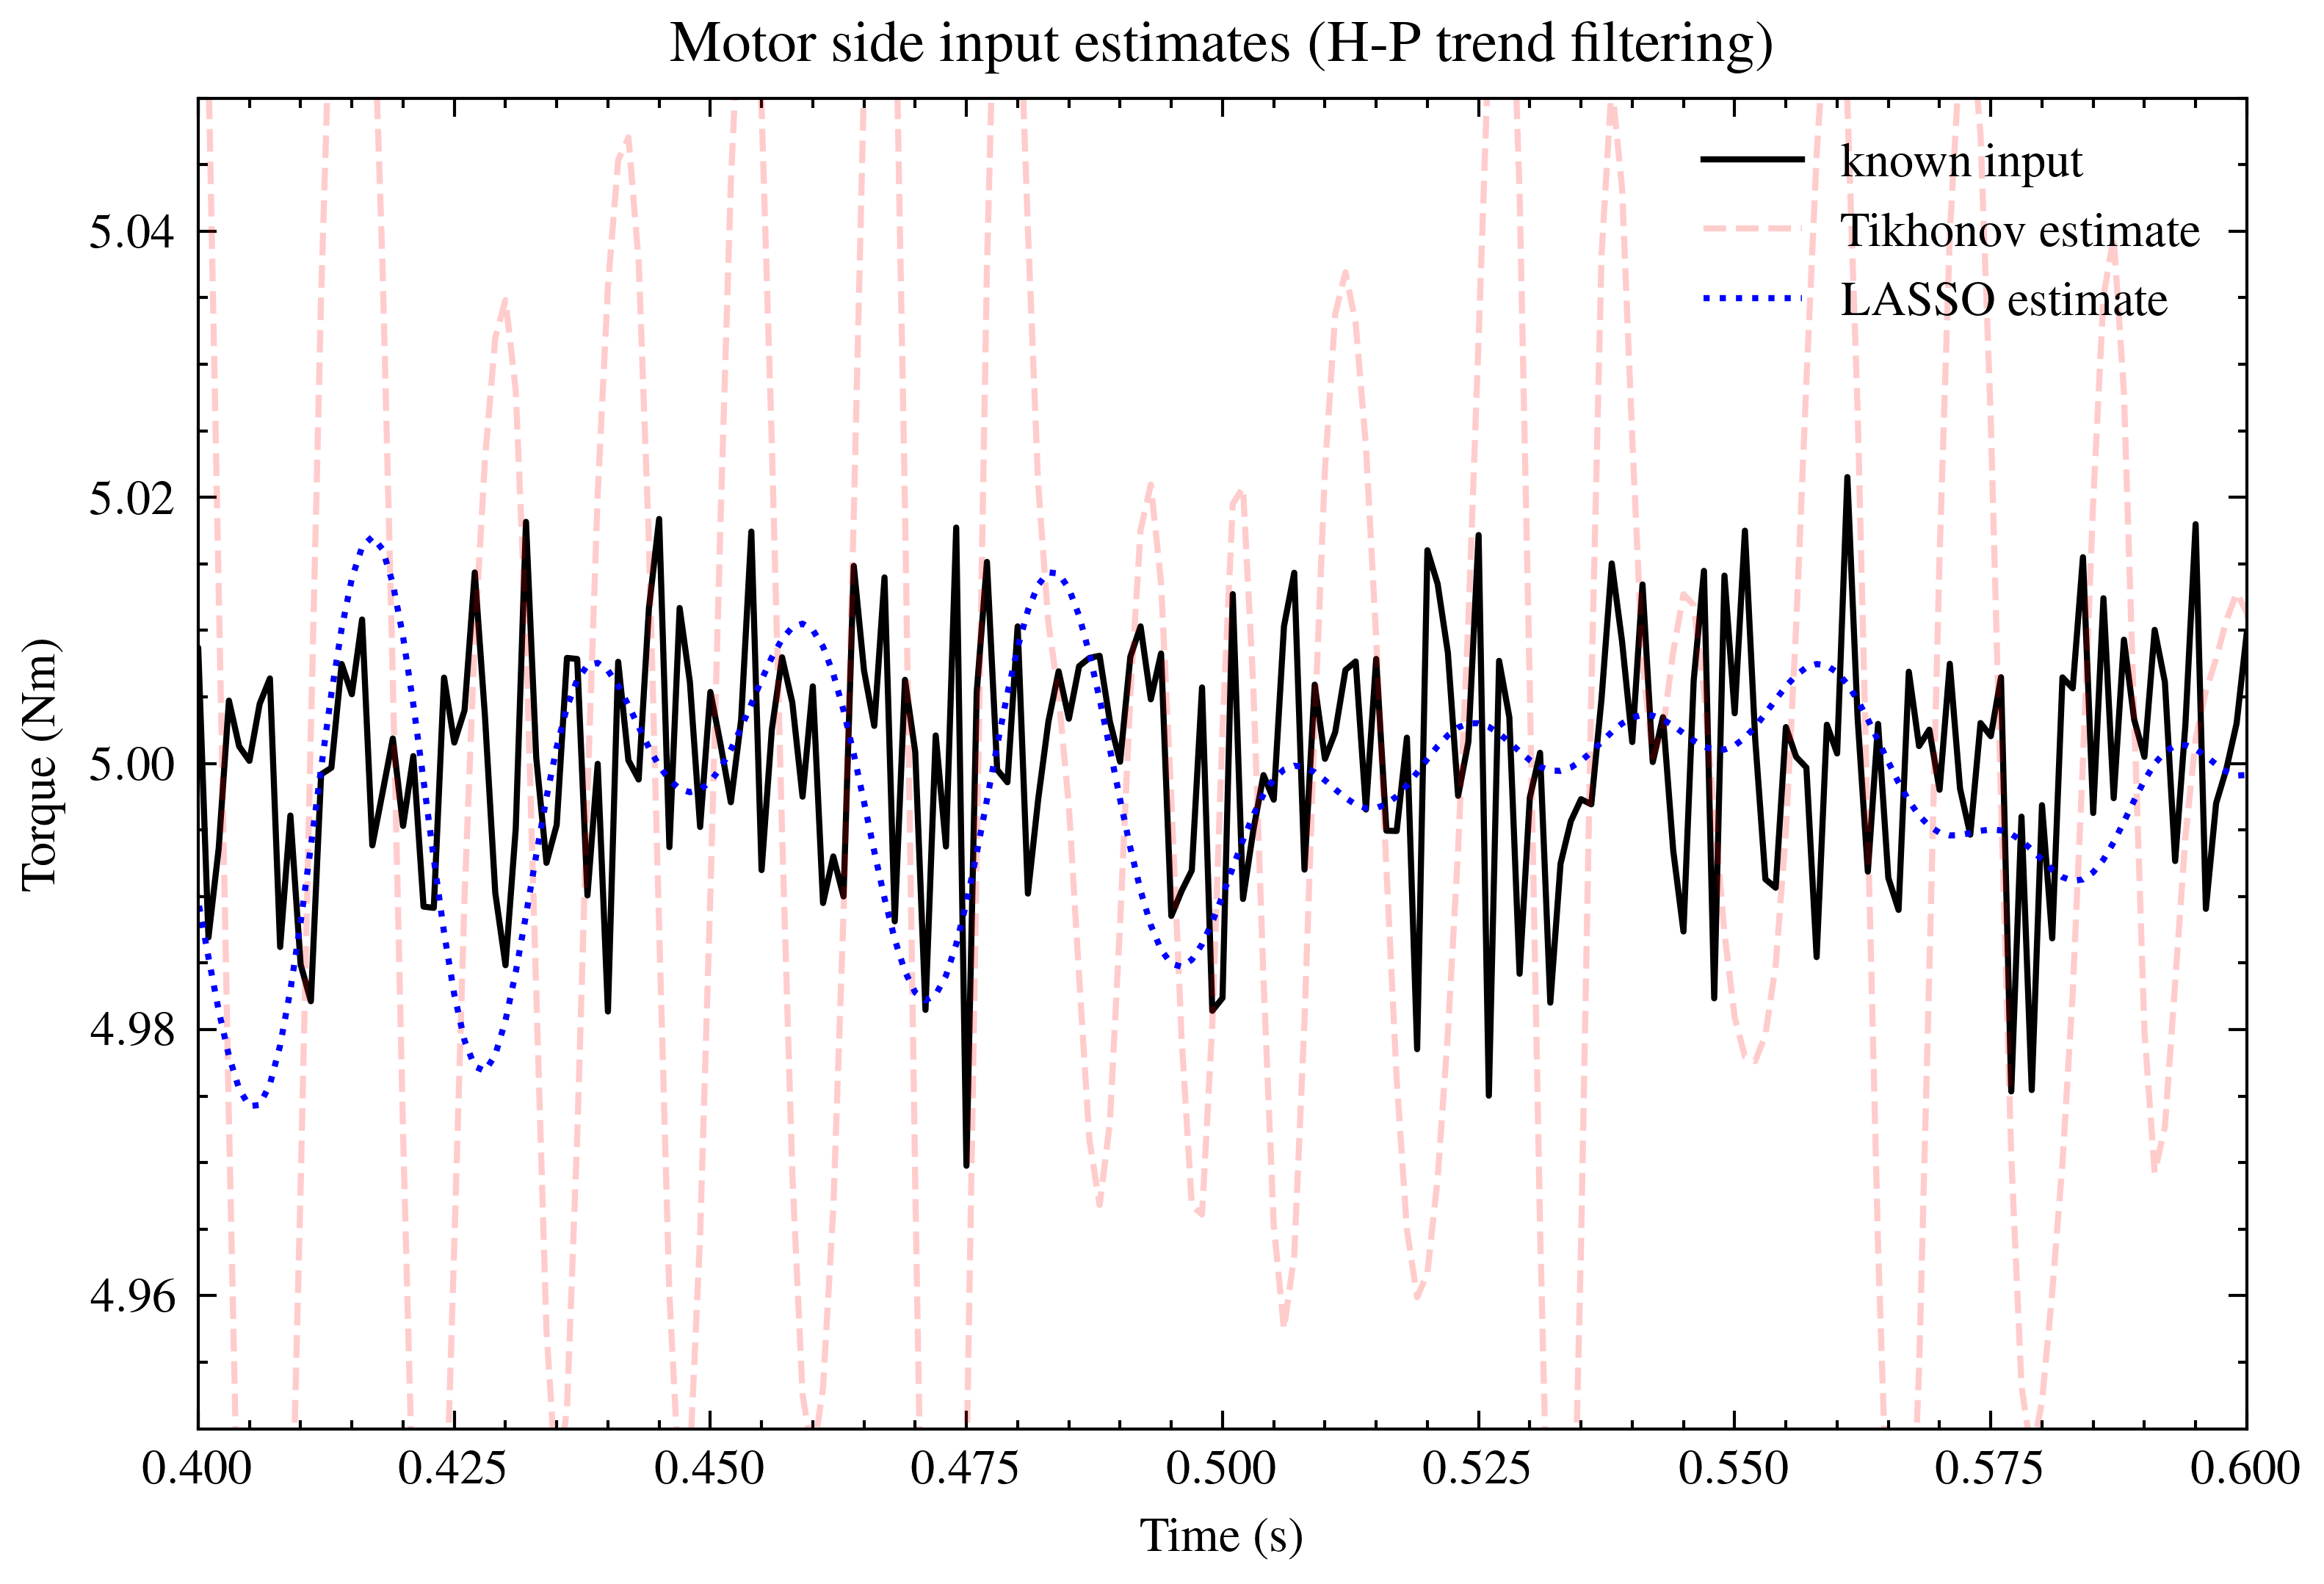

In [56]:
plt.plot(sim_time[:en], U[:en,0], label='known input')
plt.plot(sim_time[:en], tikhonov_estimate[::2], label='Tikhonov estimate', alpha=0.2)
plt.plot(sim_time[:en], lasso_estimate[::2], label='LASSO estimate')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Motor side input estimates (H-P trend filtering)')
plt.ylim(4.95, 5.05)
plt.xlim(0.4,0.6)
plt.show()

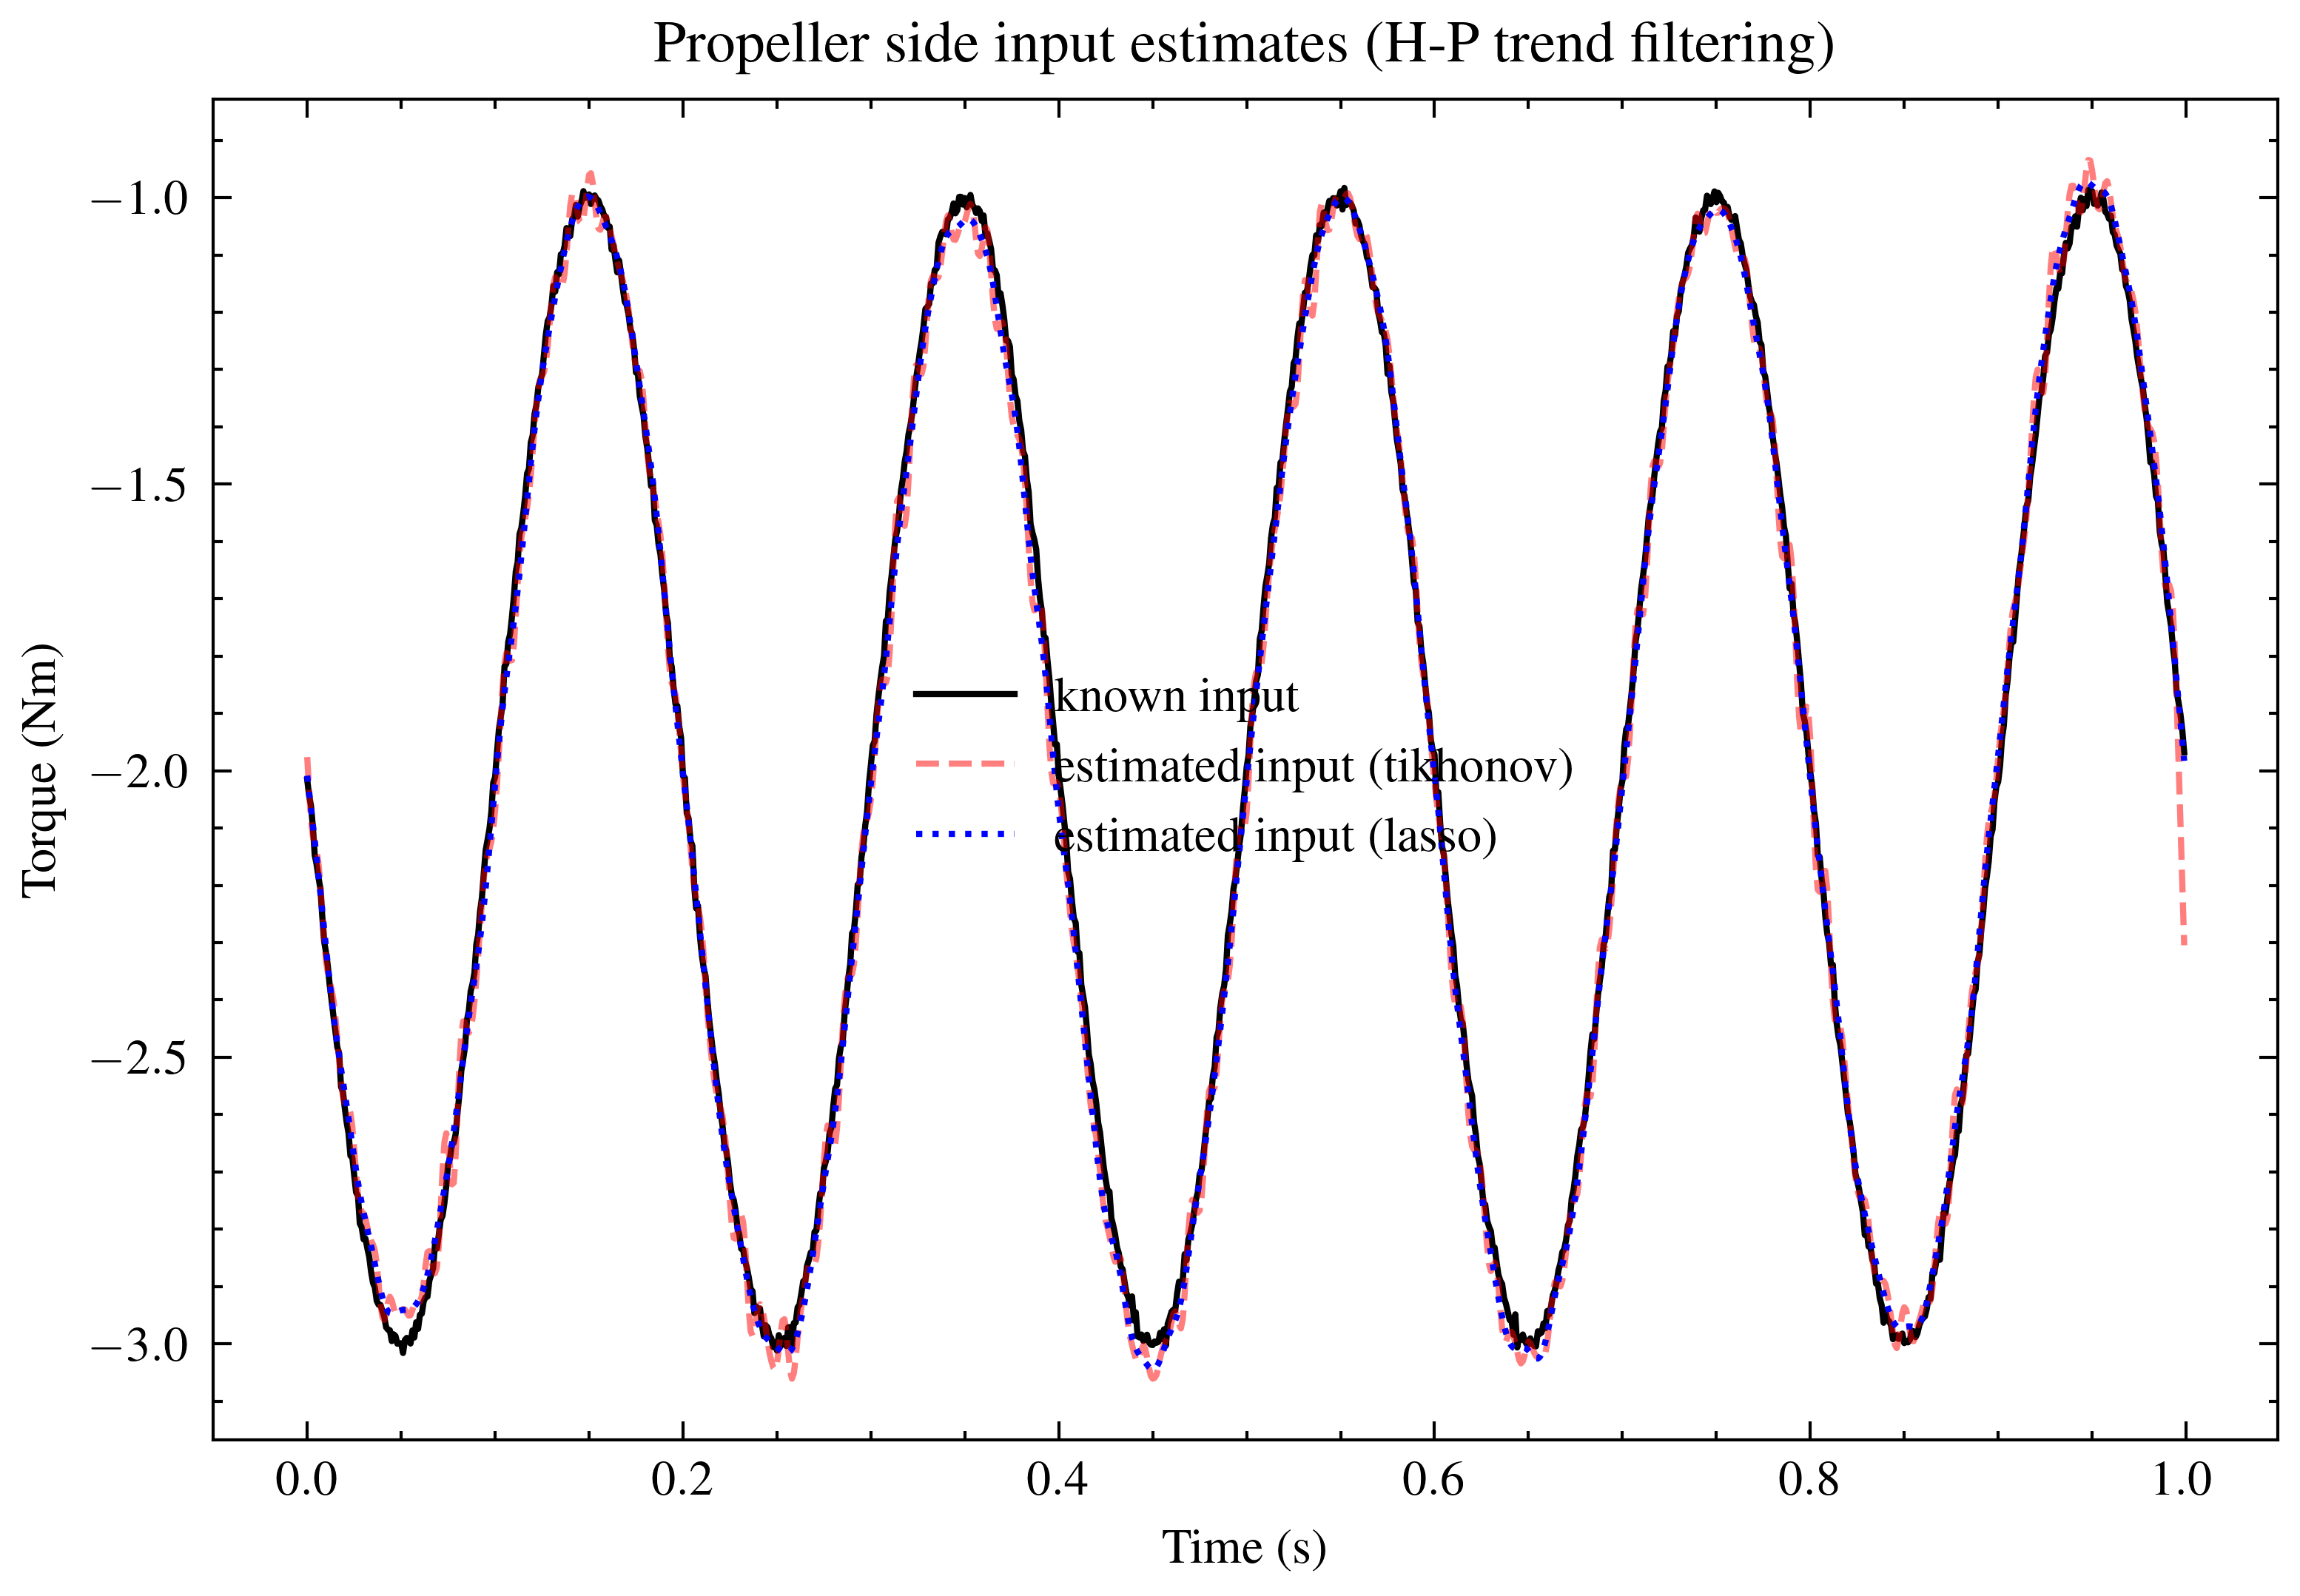

In [52]:
plt.plot(sim_time[:en], U[:en,1], label='known input')
plt.plot(sim_time[:en], tikhonov_estimate[1::2], label='estimated input (tikhonov)', alpha=0.5)
plt.plot(sim_time[:en], lasso_estimate[1::2], label='estimated input (lasso)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Propeller side input estimates (H-P trend filtering)')
plt.show()

# TODO:
Solving the convex optimization problem with unknown states results in None.
* Look into minimal state-space representation
* try other solvers